# 3D tracers with restoring  (50km coarsen)

We had initially run some simulations where tracers were restarted every month. However, I think this was not long enough. This is partially supported by the zonal channel where diffusivity tensor estimated at the end of two months was quite bad at reproducting buoyancy fluxes. So, it would seem that 1 month (in a simulation where eddy energies and mean flow are weaker) would not do a great job. We actually discovered this too. This is the final test, where a long stabalized restored tracer is used. 

In [48]:
# load modules 

import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
import os 
from xgcm import Grid
from xarrayutils import aggregate
import copy
# Pseudo Inversion 
from scipy.linalg import pinv, eig

In [4]:
data_dir = '/swot/SUM04/dbalwada/channel_model/05km/run_multi_tracer_restored_all_tracers/'

# 

iters = range(13426560, 10473120+518400*4, 1440)
model_vars = ['uVeltave','vVeltave','wVeltave', 'Ttave', 
             'UTtave', 'VTtave','WTtave','UUtave', 'UVtave', 'VVtave', 'TTtave', 'ETAtave']
ds_model = open_mdsdataset(data_dir , delta_t=300,  
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/utils.py:423: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [5]:
ds_inst = open_mdsdataset(data_dir, delta_t=300, 
                         prefix = ['U', 'V','T','Eta','PTRACER01','PTRACER02',
                                   'PTRACER03', 'PTRACER05', 'PTRACER06'], iters = [17210880],
                         ignore_unknown_vars=True, geometry='cartesian')

In [6]:
data_dir = '/swot/SUM04/dbalwada/channel_model/05km/run_multi_tracer_restored_all_tracers/'

# brief comment on how often was the model data saved 
# the mode outputs fields every 5 days, averages are also
# calculated over 5 days (*this creates stupid amounts of 
# unnecessary data, and was definitely a terrible idea in hidsight).
# 

iters = range(10473120, 10473120+518400*4, 1440)
model_vars = ['tracer1_diag', 'tracer2_diag', 'tracer3_diag', 'tracer4_diag', 'tracer5_diag',
              'tracer6_diag', 'tracer7_diag', 'tracer8_diag', 'tracer9_diag', 'tracer10_diag',
              'tracer11_diag', 'tracer12_diag', 'tracer13_diag', 'tracer14_diag', 'tracer15_diag',
              'tracer16_diag', 'tracer17_diag', 'tracer18_diag', 'tracer19_diag', 'tracer20_diag',]
ds_tracers = open_mdsdataset(data_dir , delta_t=300,  
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

In [7]:
ds_tracers.iter.values

array([13426560, 13478400, 13530240, 13582080, 13633920, 13685760,
       13737600, 13789440, 13841280, 13893120, 13944960, 13996800,
       14048640, 14100480, 14152320, 14204160, 14256000, 14307840,
       14359680, 14411520, 14463360, 14515200, 14567040, 14618880,
       14670720, 14722560, 14774400, 14826240, 14878080, 14929920,
       14981760, 15033600, 15085440, 15137280, 15189120, 15240960,
       15292800, 15344640, 15396480, 15448320, 15500160, 15552000,
       15603840, 15655680, 15707520, 15759360, 15811200, 15863040,
       15914880, 15966720, 16018560, 16070400, 16122240, 16174080,
       16225920, 16277760, 16329600, 16381440, 16433280, 16485120,
       16536960, 16588800, 16640640, 16692480, 16744320, 16796160,
       16848000, 16899840, 16951680, 17003520, 17055360, 17107200,
       17159040, 17210880])

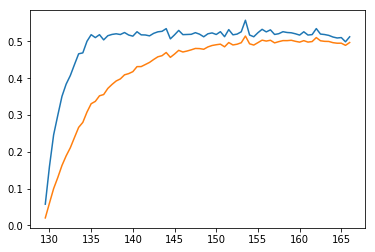

In [8]:

plt.plot(ds_tracers.time/3600/24/360, ds_tracers.TRAC01.sel(Z=-1000, 
                                            method='nearest').sel(XC=slice(0,200e3), 
                                            YC=slice(900e3,1100e3)).mean(['XC','YC']))

plt.plot(ds_tracers.time/3600/24/360, ds_tracers.TRAC02.sel(Z=-1000, 
                                              method='nearest').sel(XC=slice(0,200e3), 
                                               YC=slice(900e3,1100e3)).mean(['XC','YC']))
#ds_tracers.TRAC02.sel(Z=-1000, method='nearest').sel(XC=slice(0,200e3), YC=slice(900e3,1100e3)).mean(['XC','YC']).plot()

In [7]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

# Tracers for 3D setup (with ridge in the middle.)
$$C1 = yg/Lx$$
$$C2 = (-zg)/H$$
$$C3 = cos(2 \pi x/Lx) $$
$$C4 = sin(2 \pi x/Lx)$$
$$C5 = sin(4 \pi x/Lx)$$
$$C6 = sin( \pi y/Lx)$$
$$C7 = cos(2 \pi y /Lx)$$
$$C8 = sin(2 \pi y/Lx)$$
$$C9 = cos( \pi z/H)$$
$$C10 = sin( \pi z/H)$$

There are 20 tracers, because the tracers are restored with 2 time scales. 2 year and 6 year time scales. 

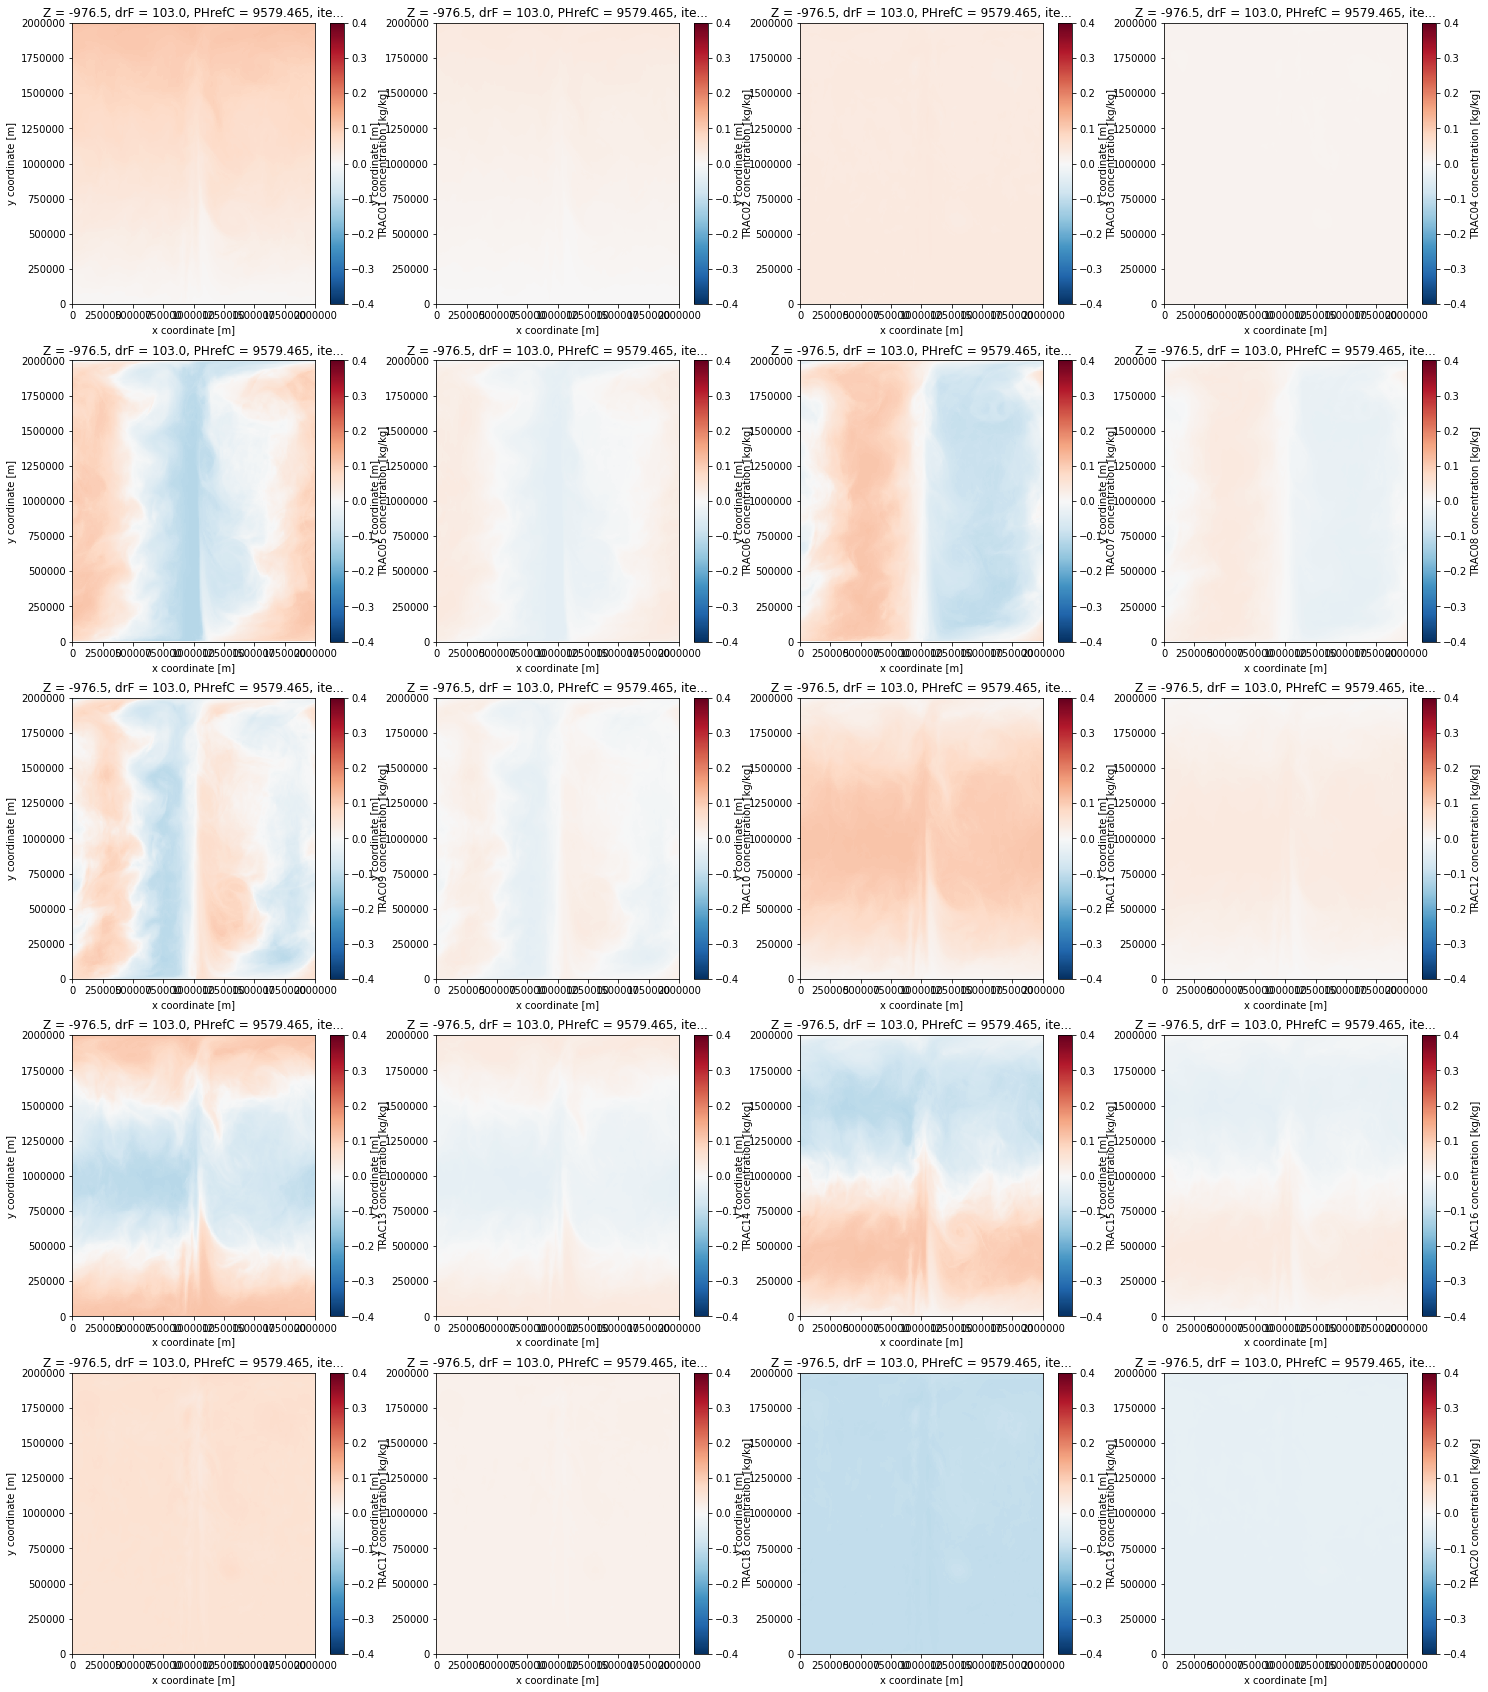

In [45]:
plt.figure(figsize=(25,30))
n=1
for i in list_trac:
    plt.subplot(5,4,n)
    n+=1
    ds_tracers[i].sel(Z=-1000,method='nearest').isel(time=0).plot(vmin=-0.4, vmax=0.4, cmap='RdBu_r')

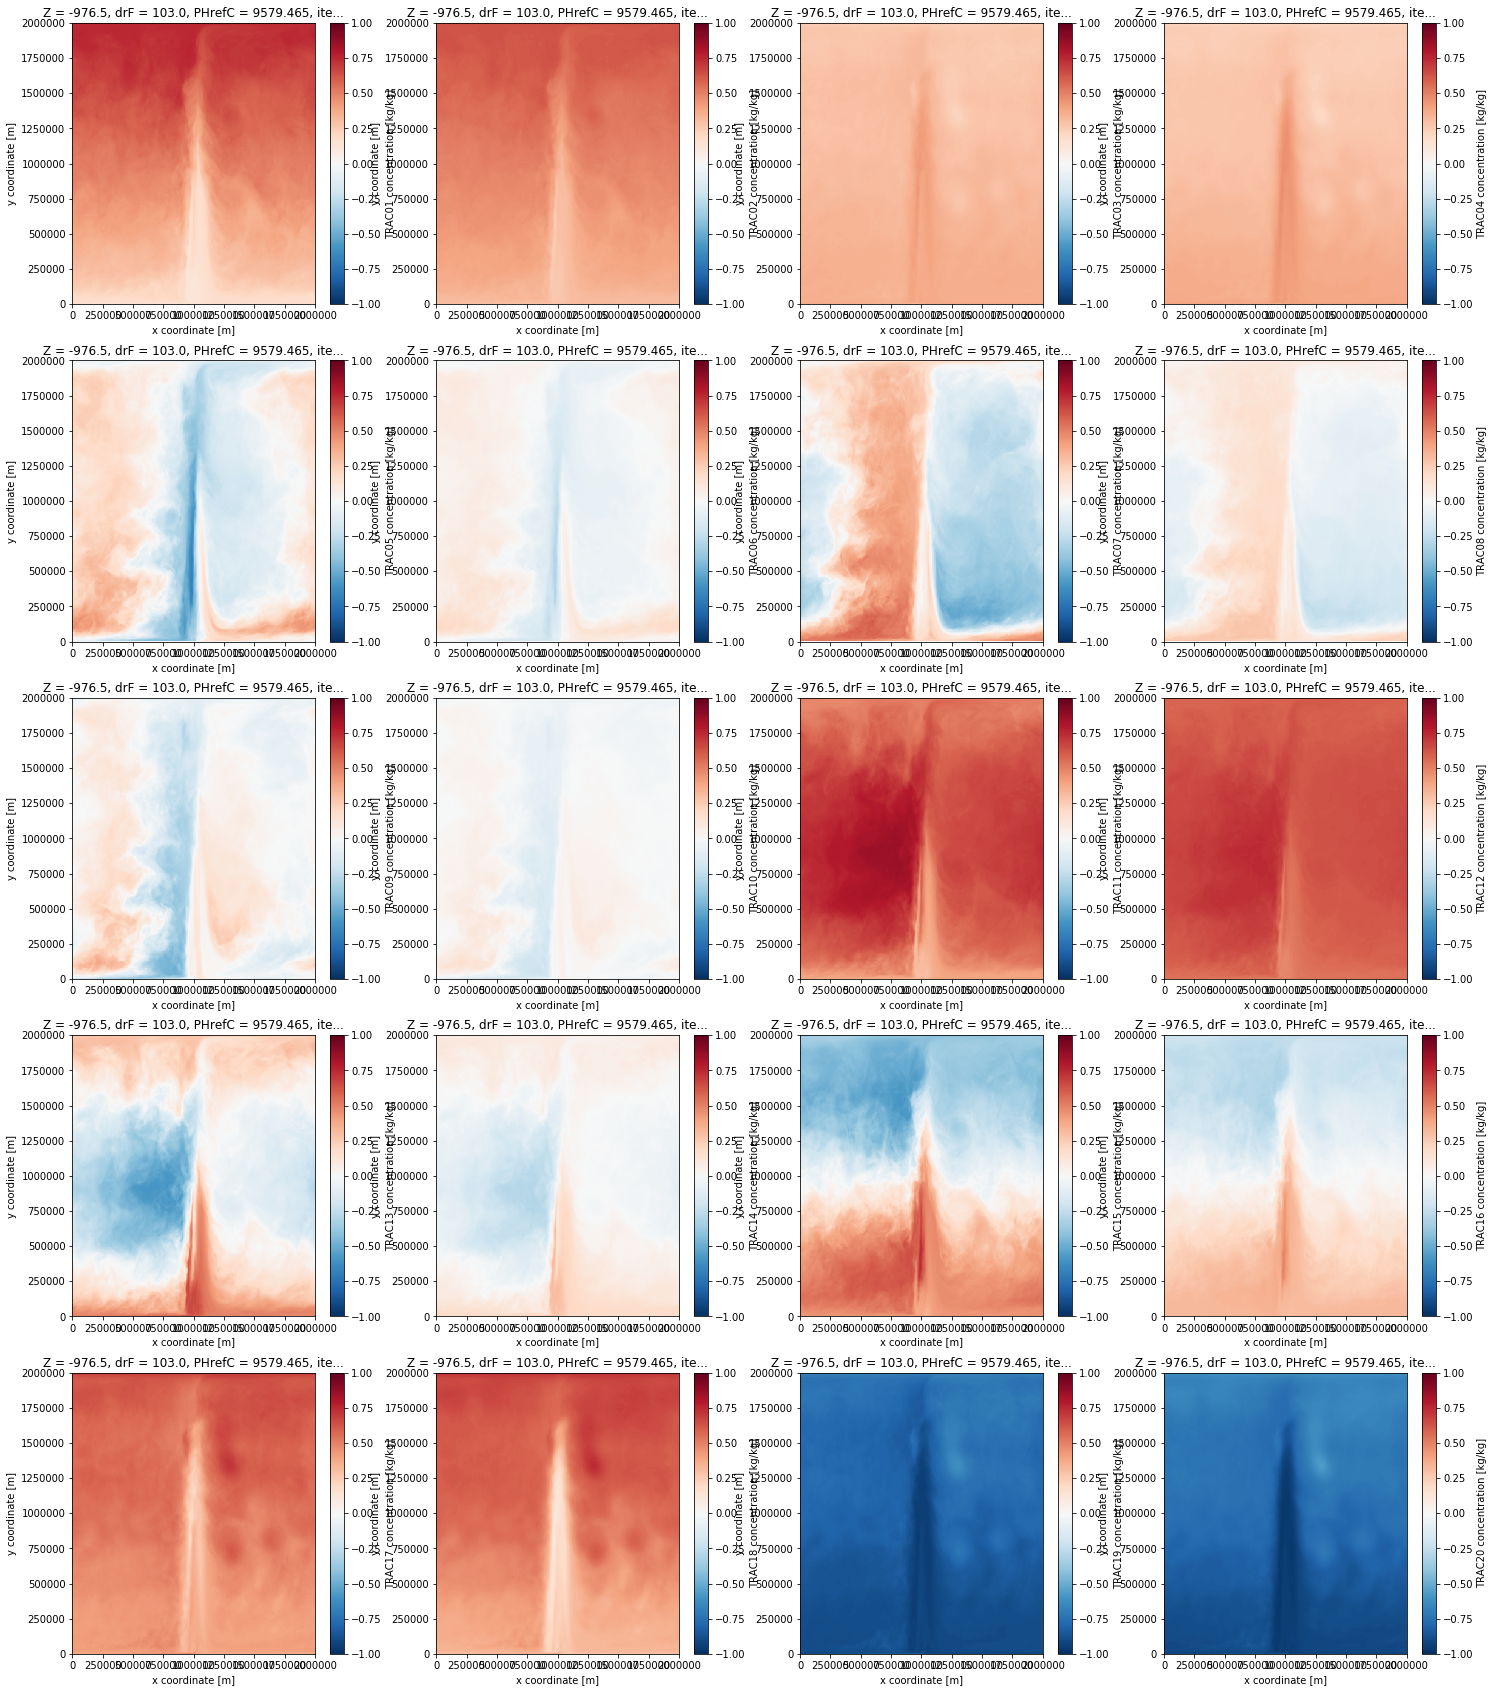

In [9]:
plt.figure(figsize=(25,30))
n=1
for i in list_trac:
    plt.subplot(5,4,n)
    n+=1
    ds_tracers[i].sel(Z=-1000,method='nearest').isel(time=-1).plot(vmin=-1, vmax=1, cmap='RdBu_r')

In [50]:
# Take time averages over appropriate period 

In [8]:
Model_Tav = ds_model.isel(time=slice(24,75)).mean('time')

In [9]:
Trac_Tav = ds_tracers.isel(time=slice(24,75)).mean('time')

In [10]:
Model_Tav.load()

<xarray.Dataset>
Dimensions:   (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
    rA        (YC, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    dxG       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    dyG       (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    Depth     (YC, XC) >f4 0.0 

In [520]:
Model_Tav.to_netcdf('Model_Tav_AGU.nc')

In [11]:
Trac_Tav.load()

<xarray.Dataset>
Dimensions:   (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
    rA        (YC, XC) >f4 25000000.0 25000000.0 ... 25000000.0 25000000.0
    dxG       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    dyG       (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    Depth     (YC, XC) >f4 0.0 

In [521]:
Trac_Tav.to_netcdf('Trac_Tav_AGU.nc')

In [203]:
X = Trac_Tav.XC
Y = Trac_Tav.YC
Z = Trac_Tav.Z

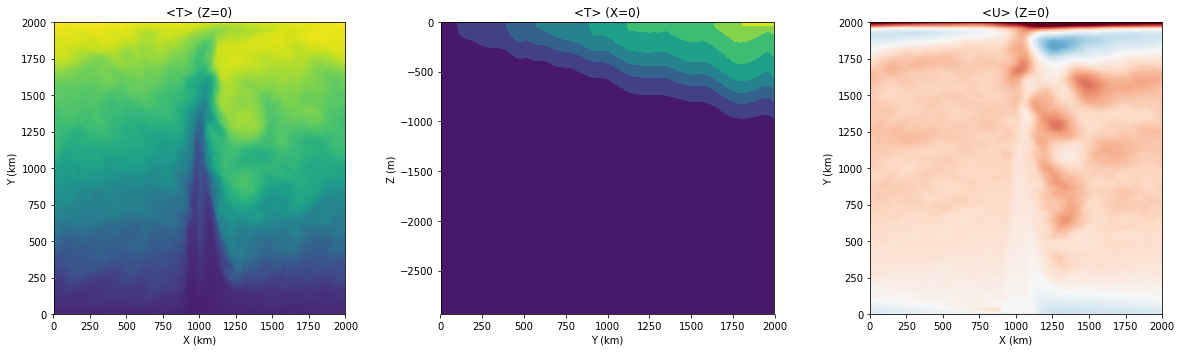

In [13]:
# see what the output looks like. 

fig, ax = plt.subplots(1, 3, figsize=(17, 5))

ax[0].pcolormesh(X/1e3, Y/1e3, ds_model.Ttave.isel(time=-1, Z=0))
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_title('<T> (Z=0)')
ax[0].set_aspect('equal')

ax[1].contourf(Y/1e3, Z, ds_model.Ttave.isel(time=-1, XC=0))
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (m)')
ax[1].set_title('<T> (X=0)')

ax[2].pcolormesh(X/1e3, Y/1e3, Model_Tav.uVeltave.isel(Z=0), vmin=-0.4, vmax=0.4, cmap='RdBu_r')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')
ax[2].set_title('<U> (Z=0)')
ax[2].set_aspect('equal')

plt.tight_layout()

# Poster Plots

In [173]:
import matplotlib.colors as colors

In [ ]:
MKE = grid.interp(Model_Tav.uVeltave,'X')**2 + \
    grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')**2
    
KE = grid.interp(Model_Tav.UUtave,'X')**2 + \
    grid.interp(Model_Tav.VVtave, 'Y', boundary='extend')**2

In [ ]:
ETAmean = ds_model.ETAtave.mean('time').load()

In [522]:
ds_inst.to_netcdf('Inst_fields_AGU.nc')

In [446]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


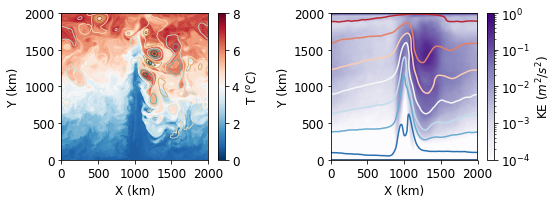

In [272]:
#norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max())
levs = [-0.7,-0.55,-0.35,-0.15,0.15, 0.35,0.55,0.7]
fig, ax = plt.subplots(1,2, figsize=(8,3))

im = ax[0].pcolormesh(X/1e3, Y/1e3, ds_inst['T'].isel(Z=5,time=0), 
                      vmin=0, vmax=8, cmap='RdBu_r', rasterized=True)
cbar = fig.colorbar(im, ax=ax[0])
cbar.ax.set_ylabel('T ($^oC$)')
ax[0].contour(X/1e3, Y/1e3, (ds_inst.Eta.isel(time=0) - ETAmean), 
              levels=levs, cmap='BrBG', linewidths=0.75, rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
#ax[0].set_title('Surface Temperature \n SSH Anomaly')


im = ax[1].pcolormesh(X/1e3,Y/1e3, KE.isel(Z=0),  norm=colors.LogNorm(vmin=1e-4, vmax=1),
                   vmin=1e-4, vmax=1, cmap='Purples', rasterized=True)
cbar = fig.colorbar(im, ax=ax[1])
cbar.ax.set_ylabel('KE ($m^2/s^2$)')
ax[1].contour(X/1e3, Y/1e3, Model_Tav.Ttave.isel(Z=0), levels=np.linspace(0,8,9),
              cmap='RdBu_r', rasterized=True)
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
#ax[1].set_title('Surface Kinetic Energy \n Mean SST')

plt.tight_layout()

plt.savefig('fields.pdf', dpi=100)

In [ ]:
# Choose 2 tracers (1,5) - with Z and X gradients 

In [284]:
X = ds_inst.XC
Y = ds_inst.YC
Z = ds_inst.Z

In [285]:
Lx=2000e3

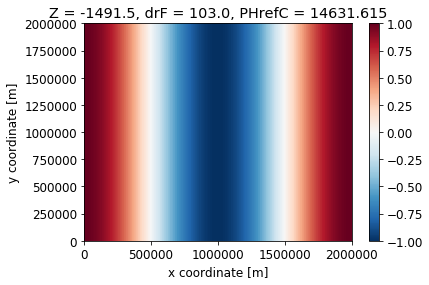

In [339]:
C3.sel(Z=-1500, method='nearest').plot(vmax=1)

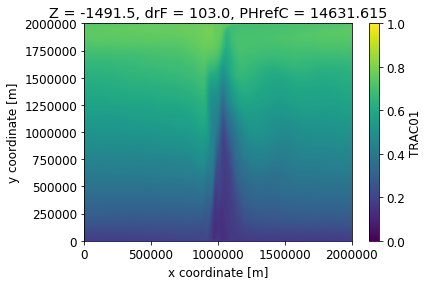

In [295]:
Trac_Tav.TRAC01.sel(Z=-1500, method='nearest').plot(vmax=1)

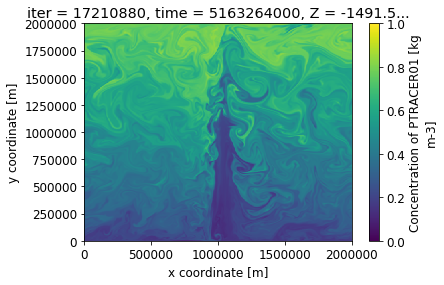

In [296]:
ds_inst.PTRACER01.sel(Z=-1500, method='nearest').plot(vmax=1)

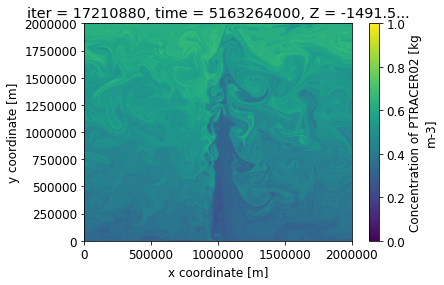

In [297]:
ds_inst.PTRACER02.sel(Z=-1500, method='nearest').plot(vmax=1)

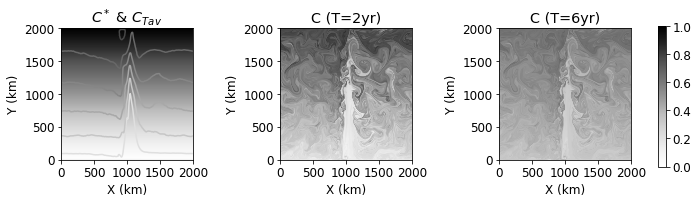

In [348]:
fig, ax = plt.subplots(1,3, figsize=(10,3))

im = ax[0].pcolormesh(X/1e3, Y/1e3, C1.sel(Z=-1500, method='nearest'), vmax=1, 
                      cmap='Greys', rasterized=True)
#fig.colorbar(im, ax=ax[0])
ax[0].contour(X/1e3, Y/1e3, Trac_Tav.TRAC01.sel(Z=-1500, method='nearest'), 
              vmin=0, vmax=1,levels=np.linspace(0,1,10), cmap='Greys', rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_title('$C^*$ & $C_{Tav}$')

im = ax[1].pcolormesh(X/1e3, Y/1e3, ds_inst.PTRACER01.sel(Z=-1500, method='nearest').isel(time=-1)
                 , vmax=1, cmap='Greys', rasterized=True)
#fig.colorbar(im, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
ax[1].set_title('C (T=2yr)')

im = ax[2].pcolormesh(X/1e3, Y/1e3, ds_inst.PTRACER02.sel(Z=-1500, method='nearest').isel(time=-1)
                 , vmax=1, cmap='Greys', rasterized=True)
#fig.colorbar(im, ax=ax[2])
ax[2].set_aspect('equal')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')
ax[2].set_title('C (T=6yr)')

plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)
#fig.colorbar(im, ax=ax.ravel().tolist())

plt.savefig('trac_2times_ygrad.pdf', dpi=400)


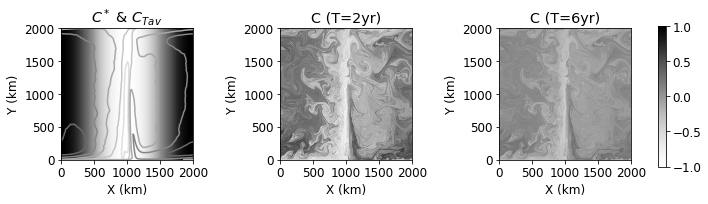

In [349]:
fig, ax = plt.subplots(1,3, figsize=(10,3))

im = ax[0].pcolormesh(X/1e3, Y/1e3, C3.sel(Z=-1500, method='nearest'), vmin=-1,vmax=1, 
                      cmap='Greys', rasterized=True)
#fig.colorbar(im, ax=ax[0])
ax[0].contour(X/1e3, Y/1e3, Trac_Tav.TRAC05.sel(Z=-1500, method='nearest'), 
             vmin=-1,vmax=1,levels=np.linspace(-1,1,10), cmap='Greys', rasterized=True)
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_title('$C^*$ & $C_{Tav}$')

im = ax[1].pcolormesh(X/1e3, Y/1e3, ds_inst.PTRACER05.sel(Z=-1500, method='nearest').isel(time=-1)
                 , vmin=-1, vmax=1, cmap='Greys', rasterized=True)
#fig.colorbar(im, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
ax[1].set_title('C (T=2yr)')

im = ax[2].pcolormesh(X/1e3, Y/1e3, ds_inst.PTRACER06.sel(Z=-1500, method='nearest').isel(time=-1)
                 , vmin=-1, vmax=1, cmap='Greys', rasterized=True)
#fig.colorbar(im, ax=ax[2])
ax[2].set_aspect('equal')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')
ax[2].set_title('C (T=6yr)')

plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)
#fig.colorbar(im, ax=ax.ravel().tolist())

plt.savefig('trac_2times_xgrad.pdf', dpi=400)


# Next

In [14]:
list_tracers = ['TRAC01', 'TRAC02','TRAC03','TRAC04','TRAC05',
                'TRAC06','TRAC07','TRAC08','TRAC09','TRAC10',
                'TRAC11', 'TRAC12','TRAC13','TRAC14','TRAC15',
                'TRAC16','TRAC17','TRAC18','TRAC19','TRAC20']

list_vels = ['uVeltave','vVeltave','wVeltave']
vels = {'uVeltave':'U', 'vVeltave':'V', 'wVeltave':'W'}

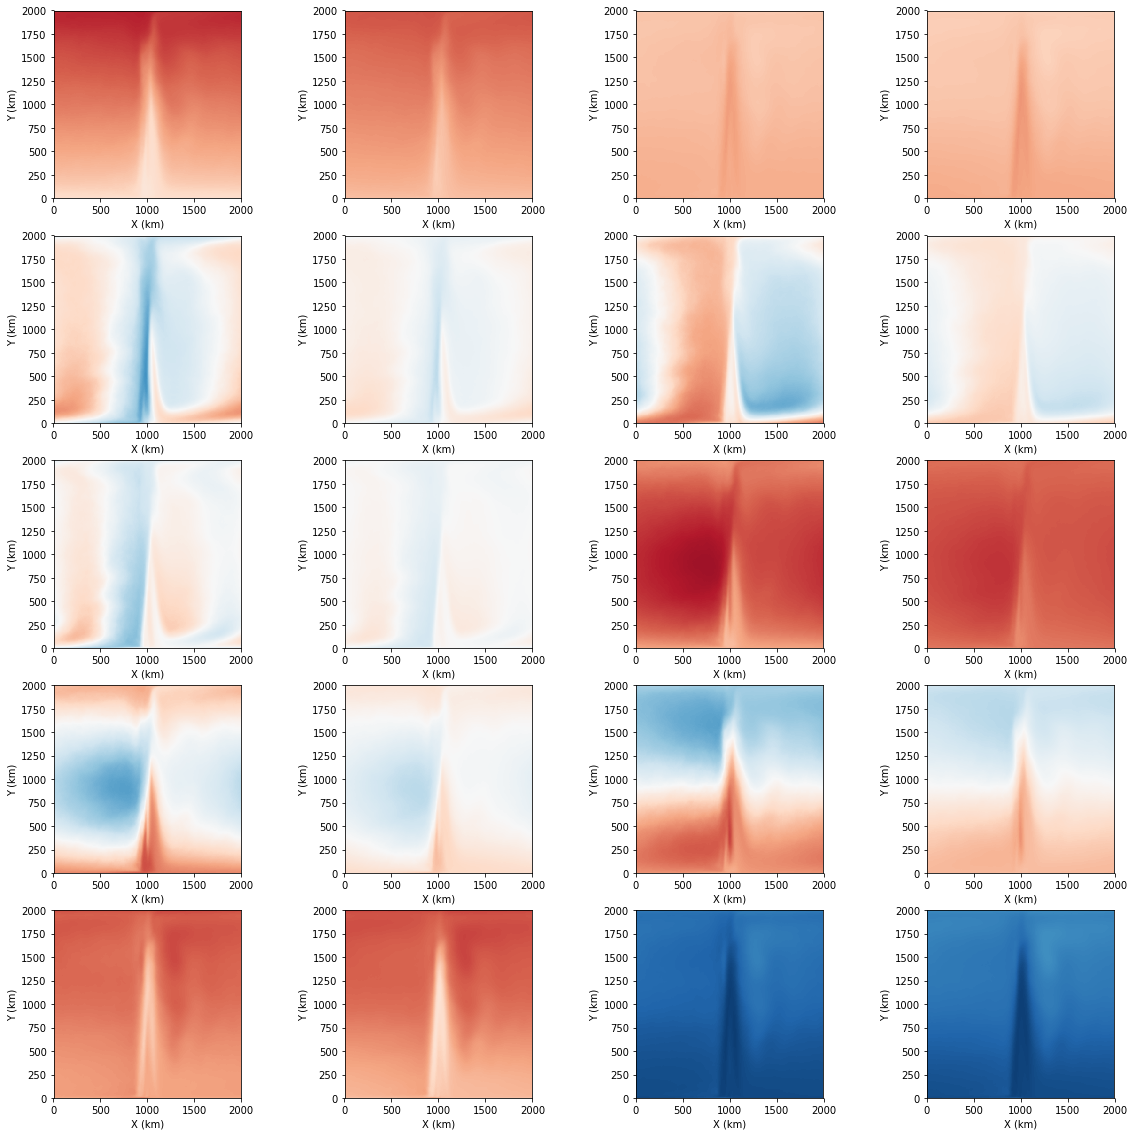

In [19]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20), squeeze=True)
axf = ax.flatten()
n=0
for key in list_tracers: 
    axf[n].pcolormesh(X/1e3, Y/1e3, Trac_Tav[key].sel(Z=-1000, method='nearest'), 
                      vmin=-1, vmax=1, cmap='RdBu_r')
    axf[n].set_xlabel('X (km)')
    axf[n].set_ylabel('Y (km)')
    axf[n].set_aspect('equal')
    
    n+=1
    
#fig.suptitle('<Tracers> (Z=0)')

Lets get into the meat

In [15]:
# Define the coarse grid

Lcoarse = 50e3 # needs to be a multiple of the domain size.
idmax   = int( (Model_Tav.dyC[0,0].values * len(Model_Tav.YC))/Lcoarse) # numper of grid points to average over
nreps   = int( len(Model_Tav.YC)/idmax )

YCicoarse = np.repeat(range(idmax),nreps)
XCicoarse = np.repeat(range(idmax),nreps)

In [16]:
grid = Grid(Model_Tav, periodic='X')

In [17]:
# Interpolate mean velocities to all be on same point.# Interp 
Model_Tav['WmeanC'] = grid.interp(Model_Tav.wVeltave, 'Z', boundary='extend')
Model_Tav['VmeanC'] = grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')
Model_Tav['UmeanC'] = grid.interp(Model_Tav.uVeltave, 'X')

In [18]:
Model_Tav.coords['XCicoarse'] = ('XC', XCicoarse)
Model_Tav.coords['YCicoarse'] = ('YC', YCicoarse)

In [19]:
# coarse grain mean velocities

Vels_coarse = xr.Dataset()

for i in vels:
    Vels_coarse[vels[i]] = (Model_Tav[vels[i]+'meanC'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')

Vels_coarse.coords['YCcoarse'] = ('YCicoarse', Model_Tav.YC.groupby('YCicoarse').mean('YC'))
Vels_coarse.coords['XCcoarse'] = ('XCicoarse', Model_Tav.XC.groupby('XCicoarse').mean('XC'))

In [20]:
# Move eddy fluxes to center point

for key in list_tracers: 
        Trac_Tav['V'+key] = grid.interp(Trac_Tav['V'+key], 'Y', boundary='extend')
        Trac_Tav['U'+key] = grid.interp(Trac_Tav['U'+key], 'X')

In [21]:
# create coarse grained version of fluxes and mean tracers# create 

Trac_Tav.coords['YCicoarse'] = ('YC', YCicoarse)
Trac_Tav.coords['XCicoarse'] = ('XC', XCicoarse)

Trac_coarse = (Trac_Tav.groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')

Trac_coarse.coords['Ycoarse'] = ('YCicoarse', Trac_Tav.YC.groupby('YCicoarse').mean('YC'))
Trac_coarse.coords['Xcoarse'] = ('XCicoarse', Trac_Tav.XC.groupby('XCicoarse').mean('XC'))

In [22]:
Xcoarse = Trac_coarse['Xcoarse']
Ycoarse = Trac_coarse['Ycoarse']

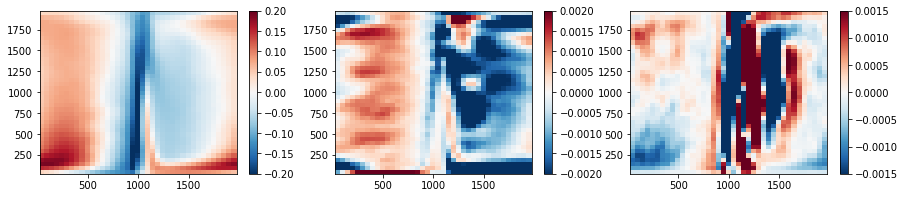

In [23]:
fig, ax = plt.subplots(1,3,figsize=(15,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC06'].sel(Z=-1000, method='nearest').T ,
                vmin=-0.2, vmax=0.2, cmap='RdBu_r')
fig.colorbar(im, ax=ax[0])

im =ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['UTRAC06'].sel(Z=-1000, method='nearest').T ,
                 vmin = -0.002, vmax=0.002, cmap='RdBu_r')
fig.colorbar(im, ax=ax[1])

im = ax[2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['VTRAC06'].sel(Z=-1000, method='nearest').T ,
                 vmin = -0.0015, vmax=0.0015, cmap='RdBu_r')
fig.colorbar(im, ax=ax[2])

In [24]:
# flux datasets 

for i in list_tracers: 
    Trac_coarse['Up'+i+'p'] = Trac_coarse['U'+i] - Vels_coarse['U'] * Trac_coarse[i]    
    Trac_coarse['Vp'+i+'p'] = Trac_coarse['V'+i] - Vels_coarse['V'] * Trac_coarse[i]
    Trac_coarse['Wp'+i+'p'] = Trac_coarse['W'+i] - Vels_coarse['W'] * Trac_coarse[i]

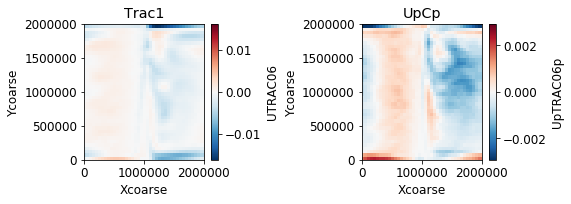

In [49]:

plt.figure(figsize=(8,3))
font = {'size'   : 12}

plt.rc('font', **font)

plt.subplot(121)
Trac_coarse['UTRAC06'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')
plt.title('Trac1')

plt.subplot(122)
Trac_coarse['UpTRAC06p'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')
plt.title('UpCp')

plt.tight_layout()

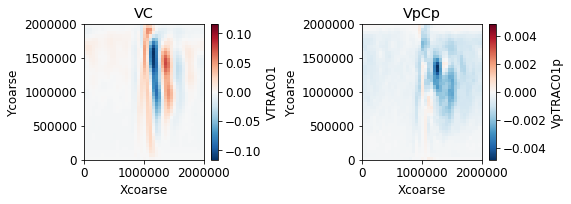

In [34]:
plt.figure(figsize=(8,3))
font = {'size'   : 12}

plt.rc('font', **font)

plt.subplot(121)
Trac_coarse['VTRAC01'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')
plt.title('VC')

plt.subplot(122)
Trac_coarse['VpTRAC01p'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')
plt.title('VpCp')

plt.tight_layout()

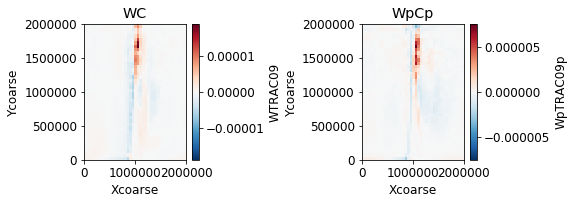

In [35]:
plt.figure(figsize=(8,3))
font = {'size'   : 12}

plt.rc('font', **font)

plt.subplot(121)
Trac_coarse['WTRAC09'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')
plt.title('WC')

plt.subplot(122)
Trac_coarse['WpTRAC09p'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')
plt.title('WpCp')

plt.tight_layout()

In [25]:
# To calculate the tracer gradients we need a staggered coordinate

# make staggered coordinates
temp = np.repeat(idmax, nreps/2)
temp2 = np.repeat(idmax-1, nreps/2)
YSicoarse = np.concatenate([YCicoarse[int(nreps/2):], temp])
XSicoarse = np.concatenate([temp2, XCicoarse[:-int(nreps/2)]])


In [26]:
trac_stag = xr.Dataset()

for i in list_tracers: 
    trac_stag[i] = Trac_Tav[i]

In [27]:
trac_stag.coords['XSicoarse'] = ('XC', XSicoarse)
trac_stag.coords['YSicoarse'] = ('YC', YSicoarse)

In [28]:
# Z grads (don't need staggered grid)

for i in list_tracers:
    Trac_coarse[i+'_Z'] = -grid.diff(grid.interp(Trac_coarse[i], 'Z', boundary='extend'),
                                    'Z', boundary='extend')/Trac_coarse.drF

In [29]:
# Y gradient
# only average in Y direction on staggered points to take Y average. 
# average in X direction is on center points

tracsav_stag = (trac_stag.groupby('YSicoarse').mean('YC')).groupby('XCicoarse').mean('XC')

for i in list_tracers:
    temp = tracsav_stag[i].diff('YSicoarse')/Lcoarse
    # dy on the end points in Y direction are not full size
    temp[:,0,:] = temp[:,0,:] * 4/3
    temp[:,-1,:] = temp[:,-1,:] * 4/3 
    
    temp = xr.DataArray(temp.data, dims=['XCicoarse', 'YCicoarse', 'Z'],
                       coords=[Trac_coarse.XCicoarse, Trac_coarse.YCicoarse, Trac_coarse.Z])
    
    Trac_coarse[i+'_Y'] = temp

In [30]:
# X grads 
# only averate in X direction on center points

tracsav_stag = (trac_stag.groupby('YCicoarse').mean('YC')).groupby('XSicoarse').mean('XC')

for i in list_tracers:
    temp = (tracsav_stag[i].data - np.roll(tracsav_stag[i].data,1,axis=0))/Lcoarse
    temp = xr.DataArray(temp.data, dims=['XCicoarse', 'YCicoarse', 'Z'],
                       coords=[Trac_coarse.XCicoarse, Trac_coarse.YCicoarse, Trac_coarse.Z])
        
    Trac_coarse[i+'_X'] = temp

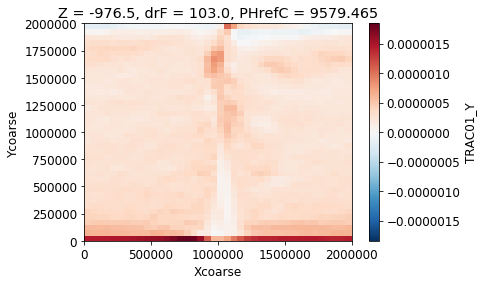

In [50]:
Trac_coarse['TRAC01_Y'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')

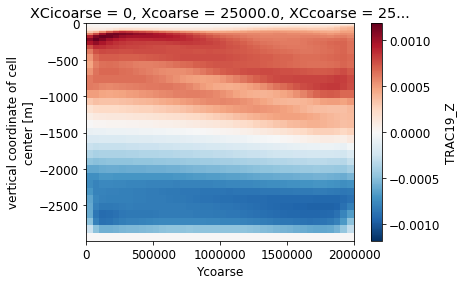

In [43]:
Trac_coarse['TRAC19_Z'].sel(XCicoarse=0, method='nearest').plot(x='Ycoarse', y='Z')

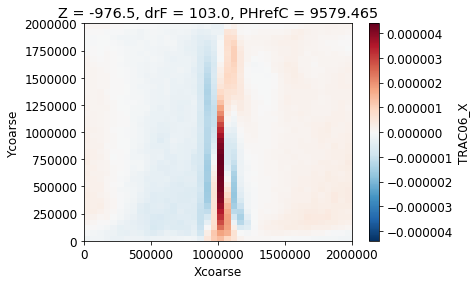

In [44]:
Trac_coarse['TRAC06_X'].sel(Z=-1000, method='nearest').plot(x='Xcoarse',y='Ycoarse')


In [31]:
# Put fluxes into separate xarrays and add dimension corresponding to tracer number
# U'C'
testxr1 = Trac_coarse['UpTRAC01p']
testxr1['tracer_num'] = 1

UpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_coarse['Up'+i+'p']
    temp['tracer_num'] = n 
    n=n+1
    
    UpCp = xr.concat([UpCp, temp], dim='tracer_num')
       
# V'C'
testxr1 = Trac_coarse['VpTRAC01p']
testxr1['tracer_num'] = 1

VpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_coarse['Vp'+i+'p']
    temp['tracer_num'] = n 
    n=n+1
    
    VpCp = xr.concat([VpCp, temp], dim='tracer_num')
    
# W'C'
testxr1 = Trac_coarse['WpTRAC01p']
testxr1['tracer_num'] = 1

WpCp = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_coarse['Wp'+i+'p']
    temp['tracer_num'] = n 
    n=n+1
    
    WpCp = xr.concat([WpCp, temp], dim='tracer_num')

In [32]:
# Put tracer gradients into xarrays
# dCdx
testxr1 = Trac_coarse['TRAC01_X']
testxr1['tracer_num'] = 1

dCdx = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_coarse[i+'_X']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdx = xr.concat([dCdx, temp], dim='tracer_num')
    
# dCdy
testxr1 = Trac_coarse['TRAC01_Y']
testxr1['tracer_num'] = 1

dCdy = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_coarse[i+'_Y']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdy = xr.concat([dCdy, temp], dim='tracer_num')   
    
# dCdz
testxr1 = Trac_coarse['TRAC01_Z']
testxr1['tracer_num'] = 1

dCdz = testxr1 

n=2
for i in list_tracers[1:]: 
    temp = Trac_coarse[i+'_Z']
    temp['tracer_num'] = n 
    n=n+1
    
    dCdz = xr.concat([dCdz, temp], dim='tracer_num')

In [523]:
UpCp.to_netcdf('UpCp_AGU.nc')
VpCp.to_netcdf('VpCp_AGU.nc')

In [527]:
WpCp.to_netcdf('WpCp_AGU.nc')
dCdz.to_netcdf('dCdz_AGU.nc')

In [524]:
dCdx.to_netcdf('dCdx_AGU.nc')
dCdy.to_netcdf('dCdy_AGU.nc')

In [33]:
# Function to calculate the diffusivity tensor 

def calc_tensor(uc,vc,wc, cx,cy,cz):
    Aflux = np.array([uc, vc, wc])
    Agrad = np.array([cx, cy, cz])


    if ~(np.isnan(Agrad).any() | np.isnan(Aflux).any()):
        return -(Aflux.dot(pinv(Agrad)))
    else:
        return np.nan*(Aflux.dot(Agrad.T))

# Plots for AGU

In [525]:
dCdy

<xarray.DataArray 'TRAC01_Y' (tracer_num: 20, XCicoarse: 40, YCicoarse: 40, Z: 40)>
array([[[[ 1.538492e-06, ...,  7.362699e-07],
         ...,
         [ 1.413107e-07, ..., -1.006908e-06]],

        ...,

        [[ 1.540515e-06, ...,  7.619424e-07],
         ...,
         [ 1.482900e-07, ..., -1.024809e-06]]],


       ...,


       [[[-1.634211e-06, ..., -7.731160e-08],
         ...,
         [ 5.740642e-08, ..., -1.560210e-06]],

        ...,

        [[-1.636710e-06, ..., -1.055264e-07],
         ...,
         [ 5.910238e-08, ..., -1.576708e-06]]]], dtype=float32)
Coordinates:
  * Z           (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
    drF         (Z) >f4 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0
    PHrefC      (Z) >f4 49.05 147.15 245.25 ... 26756.775 27767.205 28777.635
  * YCicoarse   (YCicoarse) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
  * XCicoarse   (XCicoarse) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
    Ycoarse     (YCic

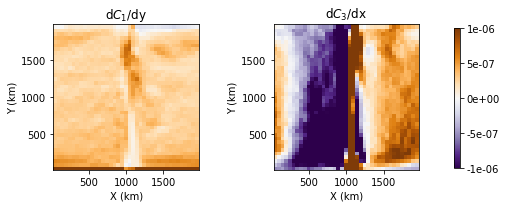

In [34]:
fig, ax = plt.subplots(1,2, figsize=(8,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, dCdy.isel(
    tracer_num=0).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-1e-6, vmax=1e-6, rasterized=True)
ax[0].set_title('d$C_1$/dy')
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, dCdx.isel(
    tracer_num=4).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-1e-6, vmax=1e-6, rasterized=True)
ax[1].set_title('d$C_3$/dx')
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax, format='%.0e')
#fig.colorbar(im, ax=ax.ravel().tolist())

plt.savefig('trac_grads.pdf', dpi=400)

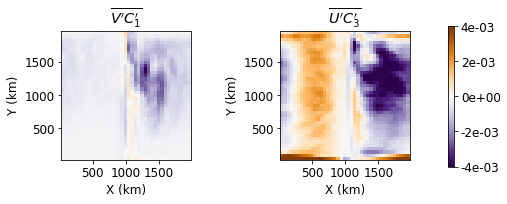

In [395]:
fig, ax = plt.subplots(1,2, figsize=(8,3))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, VpCp.isel(
    tracer_num=0).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-4e-3, vmax=4e-3, rasterized=True)
ax[0].set_title('$\overline{V\'C_1\'}$')
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')

im =ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, UpCp.isel(
    tracer_num=4).sel(Z=-1500, method='nearest').T , cmap='PuOr_r', 
               vmin=-4e-3, vmax=4e-3, rasterized=True)
ax[1].set_title('$\overline{U\'C_3\'}$')
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')

plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax, format='%.0e')
#fig.colorbar(im, ax=ax.ravel().tolist())

plt.savefig('trac_fluxes.pdf', dpi=400)

# Use restored tracers, as if there is no restoration. 

In [36]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_fast.load() # need to load because we will take transpose and a

CPU times: user 12.1 s, sys: 178 ms, total: 12.2 s
Wall time: 12.1 s


In [35]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensor_slow = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(2,20,2)),
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_slow.load() # need to load because we will take transpose and a

CPU times: user 12 s, sys: 765 ms, total: 12.8 s
Wall time: 12 s


In [37]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)


Ktensor_all = xr.apply_ufunc(calc_tensor, 
                       UpCp,
                       VpCp,
                       WpCp,
                       dCdx,
                       dCdy,
                       dCdz,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_all.load() # need to load because we will take transpose and a

CPU times: user 12.4 s, sys: 82 ms, total: 12.5 s
Wall time: 12.5 s


# Error in Fluxes when using restored tracers 

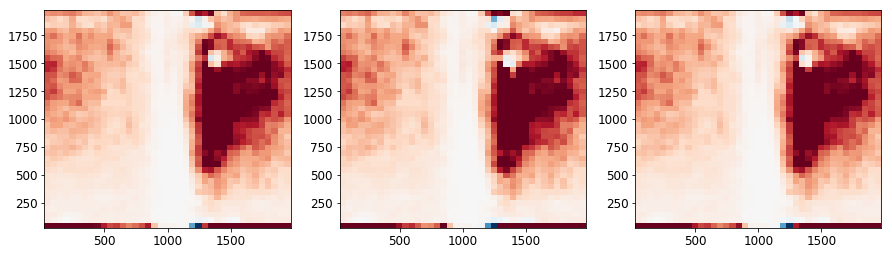

In [51]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, 
                 Ktensor_fast.isel(i=0,j=0).sel(Z=-1000, method='nearest').T ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, 
                 Ktensor_slow.isel(i=0,j=0).sel(Z=-1000, method='nearest').T ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

im = ax[2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, 
                 Ktensor_all.isel(i=0,j=0).sel(Z=-1000, method='nearest').T ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

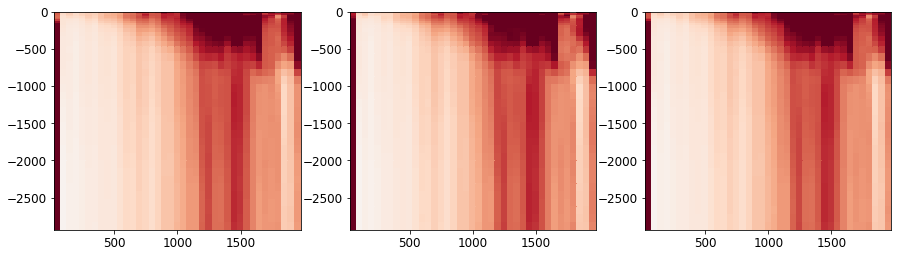

In [52]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

im = ax[0].pcolormesh(Ycoarse/1e3, Z, 
                 Ktensor_fast.isel(i=0,j=0).sel(XCicoarse=0, method='nearest').T ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

im = ax[1].pcolormesh(Ycoarse/1e3, Z, 
                 Ktensor_slow.isel(i=0,j=0).sel(XCicoarse=0, method='nearest').T ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, 
                 Ktensor_all.isel(i=0,j=0).sel(XCicoarse=0, method='nearest').T ,
                vmin=-9000, vmax=9000, cmap='RdBu_r')

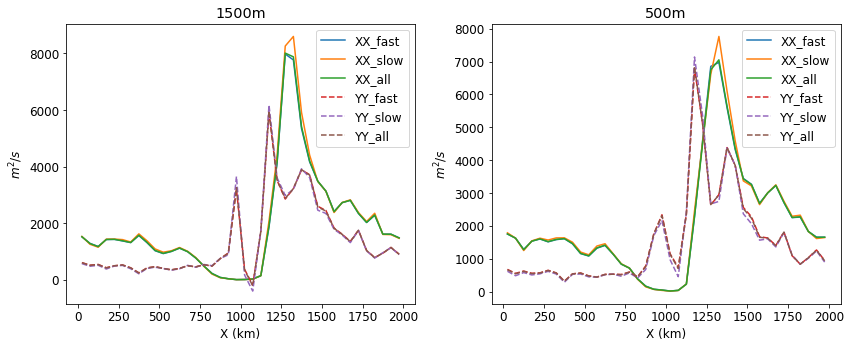

In [53]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         , label='XX_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         , label='XX_slow')
plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=0,j=0).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         , label='XX_all')

plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         ,'--',  label='YY_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         ,'--', label='YY_slow')
plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=1,j=1).sel(Z=-1500, method='nearest').sel(YCicoarse=10) 
         ,'--', label='YY_all')
plt.legend()
plt.title('1500m')
plt.xlabel('X (km)')
plt.ylabel('$m^2/s$')

plt.subplot(122)
plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         , label='XX_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         , label='XX_slow')
plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=0,j=0).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         , label='XX_all')

plt.plot(Xcoarse/1e3, Ktensor_fast.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         ,'--',  label='YY_fast')
plt.plot(Xcoarse/1e3, Ktensor_slow.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         ,'--', label='YY_slow')
plt.plot(Xcoarse/1e3, Ktensor_all.isel(i=1,j=1).sel(Z=-500, method='nearest').sel(YCicoarse=10) 
         ,'--', label='YY_all')
plt.legend()
plt.title('500m')
plt.xlabel('X (km)')
plt.ylabel('$m^2/s$')
plt.tight_layout()

# Errors in resproducing tracer fluxes 

In [52]:
recUflux_fast = Ktensor_fast.sel(i=0, j=0)*dCdx + Ktensor_fast.sel(i=0, j=1)*dCdy + \
            Ktensor_fast.sel(i=0, j=2)*dCdz
recVflux_fast = Ktensor_fast.sel(i=1, j=0)*dCdx + Ktensor_fast.sel(i=1, j=1)*dCdy + \
            Ktensor_fast.sel(i=1, j=2)*dCdz
recWflux_fast = Ktensor_fast.sel(i=2, j=0)*dCdx + Ktensor_fast.sel(i=2, j=1)*dCdy +  \
            Ktensor_fast.sel(i=2, j=2)*dCdz
    
errU_fast = np.abs(UpCp + recUflux_fast)/np.abs(UpCp)
errV_fast = np.abs(VpCp + recVflux_fast)/np.abs(VpCp)
errW_fast = np.abs(WpCp + recWflux_fast)/np.abs(WpCp)    

In [39]:
recUflux_slow = Ktensor_slow.sel(i=0, j=0)*dCdx + Ktensor_slow.sel(i=0, j=1)*dCdy + \
            Ktensor_slow.sel(i=0, j=2)*dCdz
recVflux_slow = Ktensor_slow.sel(i=1, j=0)*dCdx + Ktensor_slow.sel(i=1, j=1)*dCdy + \
            Ktensor_slow.sel(i=1, j=2)*dCdz
recWflux_slow = Ktensor_slow.sel(i=2, j=0)*dCdx + Ktensor_slow.sel(i=2, j=1)*dCdy +  \
            Ktensor_slow.sel(i=2, j=2)*dCdz
    
errU_slow = np.abs(UpCp + recUflux_slow)/np.abs(UpCp)
errV_slow = np.abs(VpCp + recVflux_slow)/np.abs(VpCp)
errW_slow = np.abs(WpCp + recWflux_slow)/np.abs(WpCp)    

In [40]:
recUflux_all = Ktensor_all.sel(i=0, j=0)*dCdx + Ktensor_all.sel(i=0, j=1)*dCdy + \
            Ktensor_all.sel(i=0, j=2)*dCdz
recVflux_all = Ktensor_all.sel(i=1, j=0)*dCdx + Ktensor_all.sel(i=1, j=1)*dCdy + \
            Ktensor_all.sel(i=1, j=2)*dCdz
recWflux_all = Ktensor_all.sel(i=2, j=0)*dCdx + Ktensor_all.sel(i=2, j=1)*dCdy +  \
            Ktensor_all.sel(i=2, j=2)*dCdz
    
errU_all = np.abs(UpCp + recUflux_all)/np.abs(UpCp)
errV_all = np.abs(VpCp + recVflux_all)/np.abs(VpCp)
errW_all = np.abs(WpCp + recWflux_all)/np.abs(WpCp)  

Text(0.5, 1.0, 'Err Fast - WC')

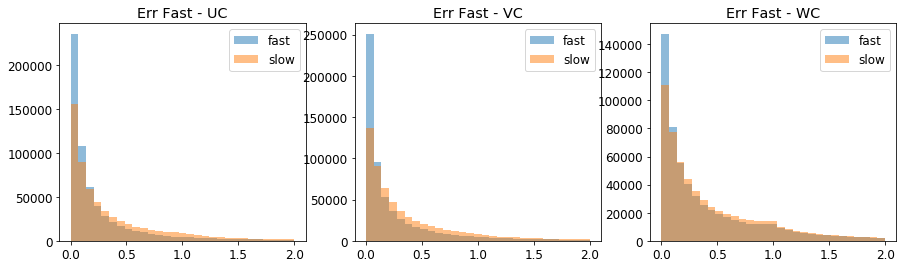

In [53]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_fast.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_fast.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - UC')

plt.subplot(132)
[_,_,_] = errV_fast.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_fast.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - VC')

plt.subplot(133)
[_,_,_] = errW_fast.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_fast.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Fast - WC')

Text(0.5, 1.0, 'Err slow - WC')

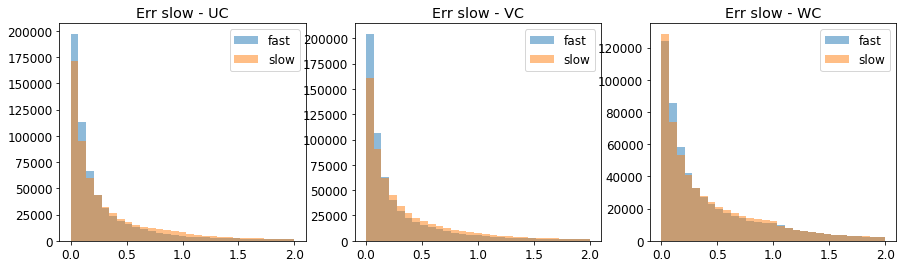

In [58]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_slow.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_slow.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err slow - UC')

plt.subplot(132)
[_,_,_] = errV_slow.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_slow.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err slow - VC')

plt.subplot(133)
[_,_,_] = errW_slow.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_slow.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err slow - WC')

Text(0.5, 1.0, 'Err all - WC')

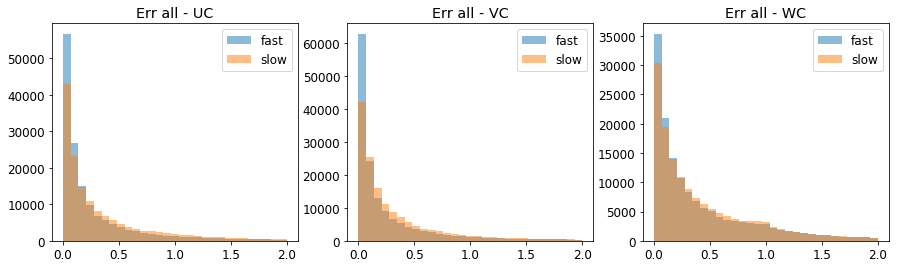

In [56]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_all.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_all.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err all - UC')

plt.subplot(132)
[_,_,_] = errV_all.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_all.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err all - VC')

plt.subplot(133)
[_,_,_] = errW_all.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_all.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err all - WC')

Can do basic metrics etc...
It is interesting to see that the eddy diffusivity estimated using the slow tracers only, works marginally better for the fast tracers. hmm? 

# Errors in reproducing buoyancy fluxes

In [54]:
Tmean = Model_Tav.Ttave
Tmean.coords['YCicoarse'] = ('YC', YCicoarse)
Tmean.coords['XCicoarse'] = ('XC', XCicoarse)
T_coarse = xr.Dataset()
T_coarse['T'] = Tmean.groupby('YCicoarse').mean('YC')
T_coarse['T'] = T_coarse['T'].groupby('XCicoarse').mean('XC')
T_coarse.coords['Ycoarse'] = ('YCicoarse', Tmean.YC.groupby('YCicoarse').mean('YC'))
T_coarse.coords['Xcoarse'] = ('XCicoarse', Tmean.XC.groupby('XCicoarse').mean('XC'))

In [55]:
# Z grads
T_coarse['T_Z'] = -grid.diff(grid.interp(T_coarse['T'], 'Z', boundary='extend'),
                                    'Z', boundary='extend')/Tmean.drF

In [56]:
Tstag = Tmean
Tstag.coords['YSicoarse'] = ('YC', YSicoarse)
Tstag.coords['XSicoarse'] = ('XC', XSicoarse)

In [57]:
# Y grads 
Tstag_sav = Tstag.groupby('YSicoarse').mean('YC')
Tstag_sav = Tstag_sav.groupby('XCicoarse').mean('XC')

temp = Tstag_sav.diff('YSicoarse')/Lcoarse
temp[:,0,:] = temp[:,0,:] * 4/3
temp[:,-1,:] = temp[:,-1,:] * 4/3   
    
temp = xr.DataArray(temp.data, dims=['Z', 'YCicoarse', 'XCicoarse'],
                    coords=[ T_coarse.Z, T_coarse.YCicoarse,T_coarse.XCicoarse])
    
T_coarse['T_Y'] = temp

In [58]:
# X grads 
# only averate in X direction on center points
Tstag_sav = Tstag.groupby('YCicoarse').mean('YC')
Tstag_sav = Tstag_sav.groupby('XSicoarse').mean('XC')


temp = (Tstag_sav.data - np.roll(Tstag_sav.data,1,axis=2))/Lcoarse
temp = xr.DataArray(temp.data, dims=['Z', 'YCicoarse', 'XCicoarse'],
                    coords=[T_coarse.Z ,T_coarse.YCicoarse, T_coarse.XCicoarse])
        
T_coarse['T_X'] = temp

In [59]:
Model_Tav['UTtave'] = grid.interp(Model_Tav.UTtave, 'X')
Model_Tav['VTtave'] = grid.interp(Model_Tav.VTtave, 'Y', boundary='extend')
Model_Tav['WTtave'] = grid.interp(Model_Tav.WTtave, 'Z', boundary='extend')

In [60]:
Model_Tav.coords['YCicoarse'] = ('YC', YCicoarse)
Model_Tav.coords['XCicoarse'] = ('XC', XCicoarse)

T_coarse['UT'] = (Model_Tav['UTtave'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')
T_coarse['VT'] = (Model_Tav['VTtave'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')
T_coarse['WT'] = (Model_Tav['WTtave'].groupby('YCicoarse').mean('YC')).groupby('XCicoarse').mean('XC')

In [61]:
T_coarse['UpTp'] = T_coarse['UT'] - Vels_coarse['U'] *T_coarse['T']
T_coarse['VpTp'] = T_coarse['VT'] - Vels_coarse['V'] *T_coarse['T']
T_coarse['WpTp'] = T_coarse['WT'] - Vels_coarse['W'] *T_coarse['T']

In [529]:
T_coarse.to_netcdf('Tcoarse_AGU.nc')

In [67]:
# Recreated B fluxes fast

recUB_fast = Ktensor_fast.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_fast.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_fast.sel(i=0, j=2)*T_coarse.T_Z
recVB_fast = Ktensor_fast.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_fast.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_fast.sel(i=1, j=2)*T_coarse.T_Z
recWB_fast = Ktensor_fast.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_fast.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_fast.sel(i=2, j=2)*T_coarse.T_Z

errUB_fast = np.abs(T_coarse.UpTp + recUB_fast)/np.abs(T_coarse.UpTp)
errVB_fast = np.abs(T_coarse.VpTp + recVB_fast)/np.abs(T_coarse.VpTp)
errWB_fast = np.abs(T_coarse.WpTp + recWB_fast)/np.abs(T_coarse.WpTp)

In [68]:
# Recreated B fluxes slow

recUB_slow = Ktensor_slow.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_slow.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_slow.sel(i=0, j=2)*T_coarse.T_Z
recVB_slow = Ktensor_slow.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_slow.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_slow.sel(i=1, j=2)*T_coarse.T_Z
recWB_slow = Ktensor_slow.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_slow.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_slow.sel(i=2, j=2)*T_coarse.T_Z

errUB_slow = np.abs(T_coarse.UpTp + recUB_slow)/np.abs(T_coarse.UpTp)
errVB_slow = np.abs(T_coarse.VpTp + recVB_slow)/np.abs(T_coarse.VpTp)
errWB_slow = np.abs(T_coarse.WpTp + recWB_slow)/np.abs(T_coarse.WpTp)

In [69]:
# Recreated B fluxes all

recUB_all = Ktensor_all.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_all.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_all.sel(i=0, j=2)*T_coarse.T_Z
recVB_all = Ktensor_all.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_all.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_all.sel(i=1, j=2)*T_coarse.T_Z
recWB_all = Ktensor_all.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_all.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_all.sel(i=2, j=2)*T_coarse.T_Z

errUB_all = np.abs(T_coarse.UpTp + recUB_all)/np.abs(T_coarse.UpTp)
errVB_all = np.abs(T_coarse.VpTp + recVB_all)/np.abs(T_coarse.VpTp)
errWB_all = np.abs(T_coarse.WpTp + recWB_all)/np.abs(T_coarse.WpTp)

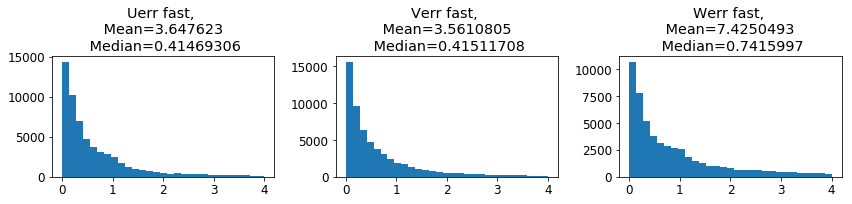

In [70]:
#  all the errors
bins = np.linspace(0,4,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_fast.plot.hist(bins=bins)
m1 = errUB_fast.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_fast.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Uerr fast, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(132)
[_,_,_] =errVB_fast.plot.hist(bins=bins)
m1 = errVB_fast.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_fast.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Verr fast, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_fast.plot.hist(bins=bins)
m1 = errWB_fast.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_fast.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Werr fast, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

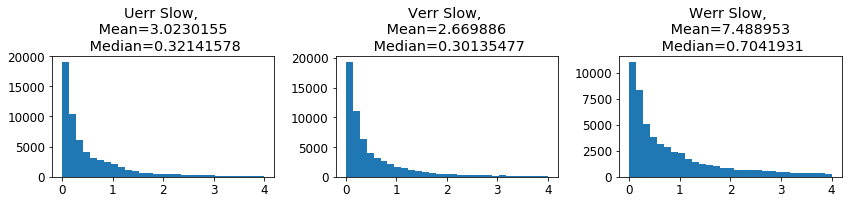

In [71]:
#  all the errors
bins = np.linspace(0,4,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_slow.plot.hist(bins=bins)
m1 = errUB_slow.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_slow.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Uerr Slow, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errVB_slow.plot.hist(bins=bins)
m1 = errVB_slow.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_slow.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Verr Slow, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_slow.plot.hist(bins=bins)
m1 = errWB_slow.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_slow.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Werr Slow, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

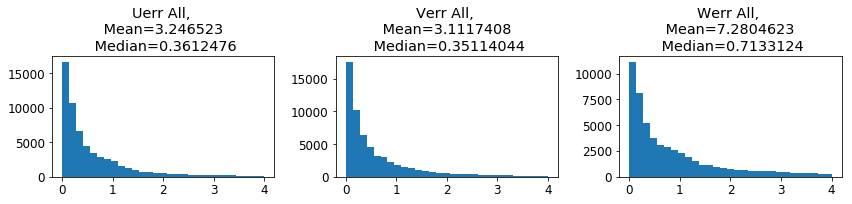

In [72]:
#  all the errors
bins = np.linspace(0,4,30)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_all.plot.hist(bins=bins)
m1 = errUB_all.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_all.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Uerr All, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errVB_all.plot.hist(bins=bins)
m1 = errVB_all.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_all.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Verr All, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_all.plot.hist(bins=bins)
m1 = errWB_all.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_all.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Werr All, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

NameError: name 'recVB_slow' is not defined

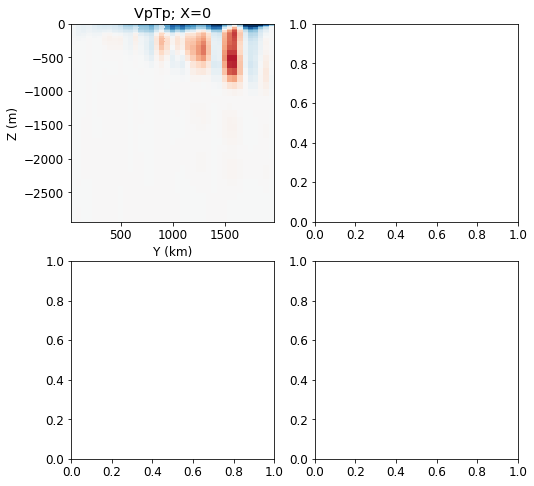

In [62]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].pcolormesh(Ycoarse/1e3, Z, T_coarse.VpTp.sel(XCicoarse=0), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; X=0')
ax[0,0].set_xlabel('Y (km)')
ax[0,0].set_ylabel('Z (m)')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, -recVB_slow.sel(XCicoarse=0).T, vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; X=0')
ax[0,1].set_xlabel('Y (km)')
ax[0,1].set_ylabel('Z (m)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, T_coarse.VpTp.sel(XCicoarse=30), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; X=1300km')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, -recVB_slow.sel(XCicoarse=30).T, vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; X=1300km')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()
plt.savefig('mer_flux_reconstruction_X.pdf')

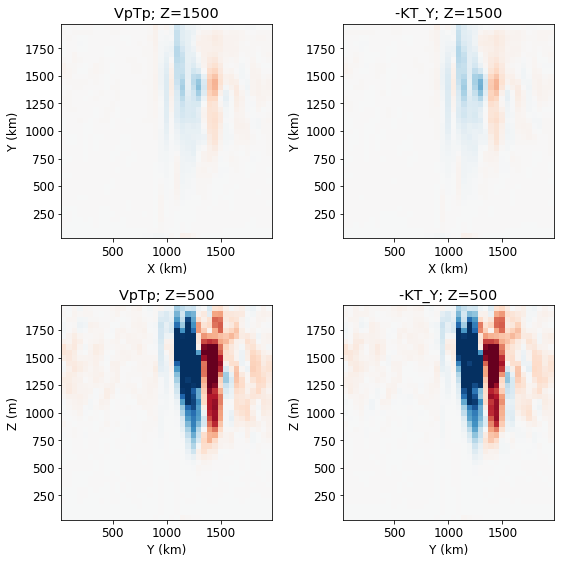

In [75]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_slow.sel(Z=-1500, method='nearest').T, vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_slow.sel(Z=-500, method='nearest').T, vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()
plt.savefig('mer_flux_reconstruction_Z.pdf')

# Use tracers with 2 times scales, assuming linearity to cancel the influence of restoring

Looking at equation 40 on in Bachman et al 2015 

$$ \overline{\mathbf{u}'c_1'} = - (\mathbf{K} + \lambda_1 \mathbf{D}) \nabla C_1 $$ 

$$ \overline{\mathbf{u}'c_2'} = - (\mathbf{K} + \lambda_2 \mathbf{D}) \nabla C_2 $$ 


The simple thing to do is eliminate $\mathbf{D}$. 

So 
$$ \overline{\mathbf{u}'c_1'} \nabla C_1 ^{-1} = - (\mathbf{K} + \lambda_1 \mathbf{D}) $$ 

$$ \overline{\mathbf{u}'c_2'} \nabla C_2 ^{-1} = - (\mathbf{K} + \lambda_2 \mathbf{D})  $$ 

So 

$$ \mathbf{K} = - \frac{\lambda_2 \overline{\mathbf{u}'c_1'} \nabla C_1 ^{-1} - \lambda_1\overline{\mathbf{u}'c_2'} \nabla C_2 ^{-1}}{ \lambda_2 - \lambda_1} $$

In [63]:
lam1 = 1/62208000.
lam2 = 1/186624000.

In [64]:
print(1/lam1/24/3600/360, 1/lam2/24/3600/360)

1.9999999999999998 6.0


In [65]:
Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)

In [526]:
Ktensor_corr.to_netcdf('Ktensor_AGU.nc')

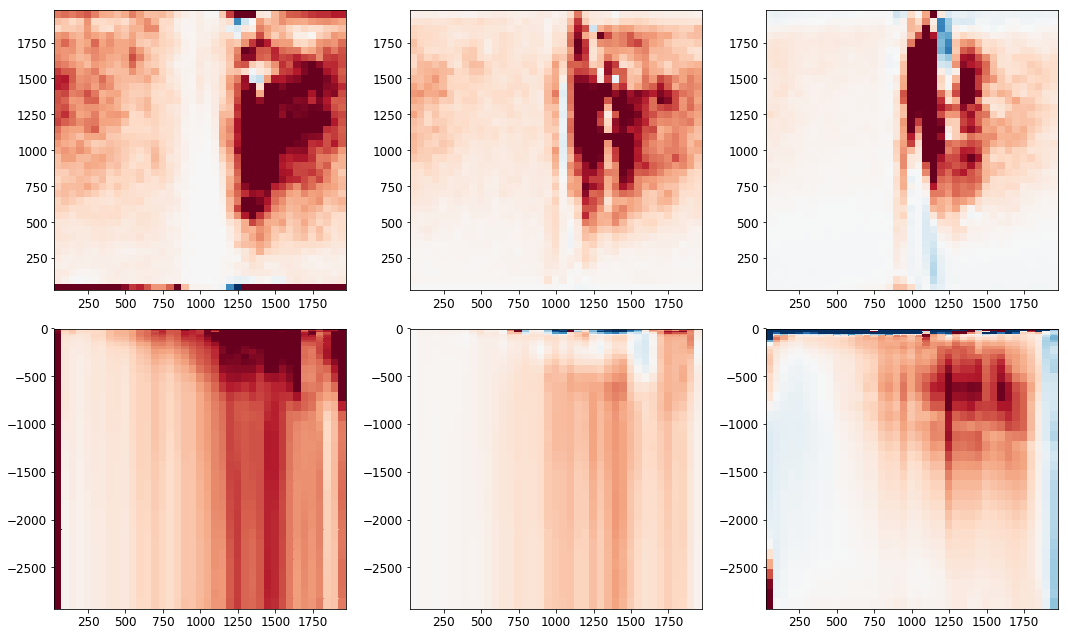

In [66]:
fig, ax = plt.subplots(2,3, figsize=(15,9))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.isel(i=0, j=0).sel(Z=-1000, method='nearest').T, 
               vmin=-9000, vmax=9000, cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.isel(i=1, j=1).sel(Z=-1000, method='nearest').T, 
               vmin=-9000, vmax=9000, cmap='RdBu_r')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.isel(i=2, j=2).sel(Z=-1000, method='nearest').T, 
               vmin=-5e-3, vmax=5e-3, cmap='RdBu_r')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCicoarse=0, method='nearest').T, 
               vmin=-9000, vmax=9000, cmap='RdBu_r')

ax[1,1].pcolormesh(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=0, method='nearest').T, 
               vmin=-9000, vmax=9000, cmap='RdBu_r')

ax[1,2].pcolormesh(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCicoarse=0, method='nearest').T, 
               vmin=-1e-3, vmax=1e-3, cmap='RdBu_r')

plt.tight_layout()

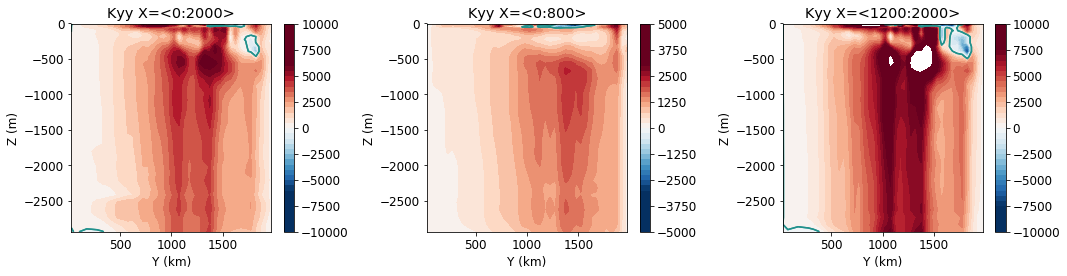

In [81]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).mean('XCicoarse').T, 
               vmin=-6000, vmax=6000, levels=np.linspace(-1e4, 1e4, 41), cmap='RdBu_r')

plt.colorbar()
plt.contour(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).mean('XCicoarse').T, 
               vmin=-6000, vmax=6000, levels=[-0.001, 0.001], color='k')

plt.title('Kyy X=<0:2000>')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.subplot(132)
plt.contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(0,18)).mean('XCicoarse').T, 
               vmin=-3000, vmax=3000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
plt.colorbar()
plt.contour(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(0,18)).mean('XCicoarse').T, 
               vmin=-6000, vmax=6000, levels=[-0.001, 0.001], color='k')
plt.title('Kyy X=<0:800>')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.subplot(133)
plt.contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(22,40)).mean('XCicoarse').T, 
               vmin=-7500, vmax=7500, levels=np.linspace(-1e4, 10e3, 41), cmap='RdBu_r')
plt.colorbar()
plt.contour(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(22,40)).mean('XCicoarse').T, 
               vmin=-6000, vmax=6000, levels=[-0.001, 0.001], color='k')
plt.title('Kyy X=<1200:2000>')
plt.xlabel('Y (km)')
plt.ylabel('Z (m)')

plt.tight_layout()
# maybe there is an indication of a mid depth max...??

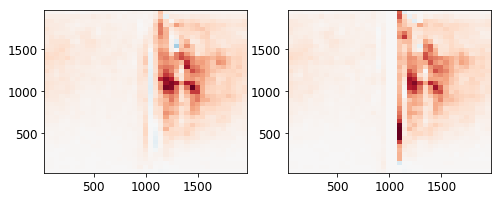

In [82]:
# Anything funny near ridge

plt.figure(figsize=(8,3))

plt.subplot(121)
plt.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.sel(Z=-1500, method='nearest').isel(i=1, j=1).T, 
               vmin=-19000, vmax=19000, cmap='RdBu_r')

plt.subplot(122)
plt.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Ktensor_corr.sel(Z=-2700, method='nearest').isel(i=1, j=1).T, 
               vmin=-19000, vmax=19000, cmap='RdBu_r')

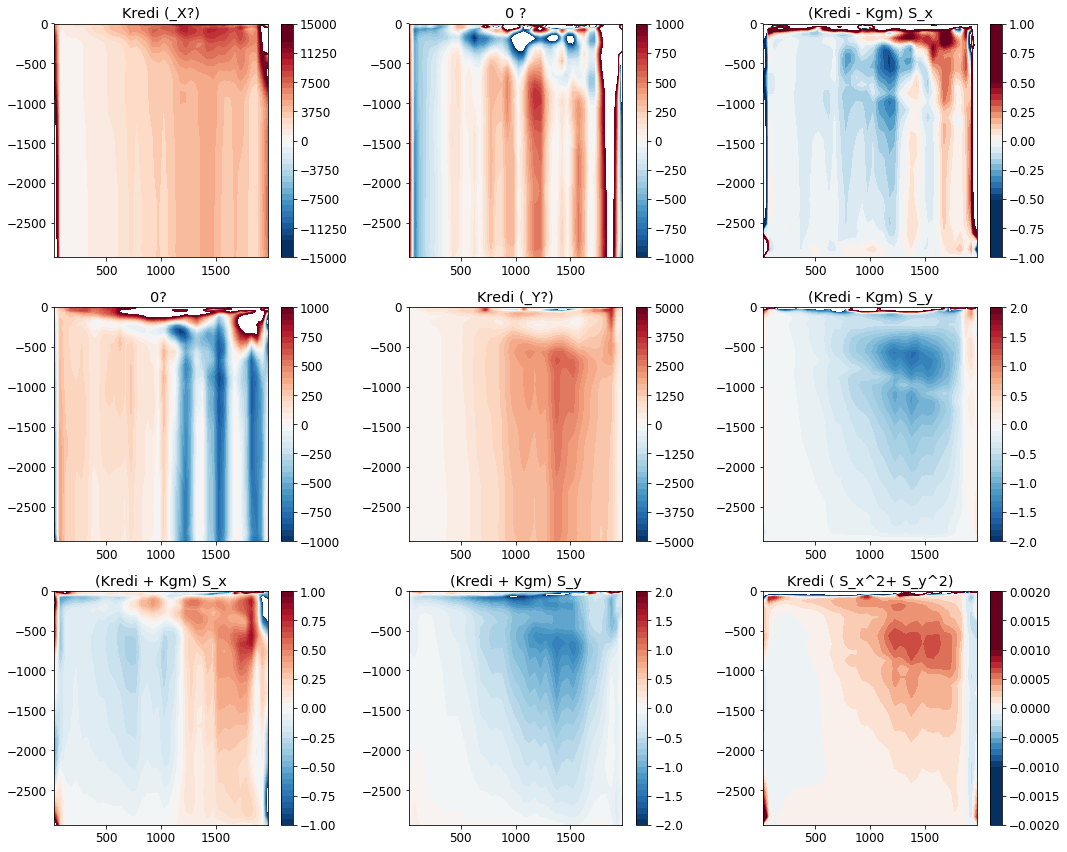

In [396]:
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('Kredi (_X?)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('(Kredi - Kgm) S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('Kredi (_Y?)')


im = ax[1,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('(Kredi - Kgm) S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('(Kredi + Kgm) S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('(Kredi + Kgm) S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('Kredi ( S_x^2+ S_y^2)')

plt.tight_layout()

## Using K tensor to recreate the fluxes

In [67]:
recUflux_corr = Ktensor_corr.sel(i=0, j=0)*dCdx + Ktensor_corr.sel(i=0, j=1)*dCdy + \
                Ktensor_corr.sel(i=0, j=2)*dCdz
recVflux_corr = Ktensor_corr.sel(i=1, j=0)*dCdx + Ktensor_corr.sel(i=1, j=1)*dCdy + \
                Ktensor_corr.sel(i=1, j=2)*dCdz
recWflux_corr = Ktensor_corr.sel(i=2, j=0)*dCdx + Ktensor_corr.sel(i=2, j=1)*dCdy +  \
                Ktensor_corr.sel(i=2, j=2)*dCdz
    
errU_corr = np.abs(UpCp + recUflux_corr)/np.abs(UpCp)
errV_corr = np.abs(VpCp + recVflux_corr)/np.abs(VpCp)
errW_corr = np.abs(WpCp + recWflux_corr)/np.abs(WpCp)   

Text(0.5, 1.0, 'Err Corr - WC')

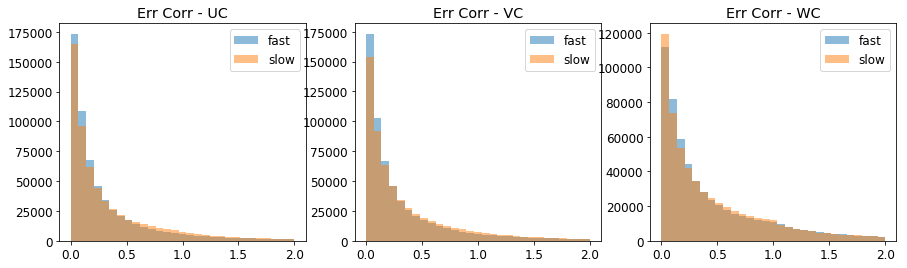

In [85]:
bins = np.linspace(0,2,30)

plt.figure(figsize=(15,4))

plt.subplot(131)
[_,_,_] = errU_corr.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errU_corr.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Corr - UC')

plt.subplot(132)
[_,_,_] = errV_corr.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errV_corr.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Corr - VC')

plt.subplot(133)
[_,_,_] = errW_corr.sel(tracer_num=slice(1,19,2)).plot.hist(bins=bins, alpha=0.5,label='fast')
[_,_,_] = errW_corr.sel(tracer_num=slice(2,20,2)).plot.hist(bins=bins, alpha=0.5,label='slow')
plt.legend()
plt.title('Err Corr - WC')

In [68]:
font = {'family' : 'normal',
        'size'   : 12}

plt.rc('font', **font)

In [69]:
len(bins)

30

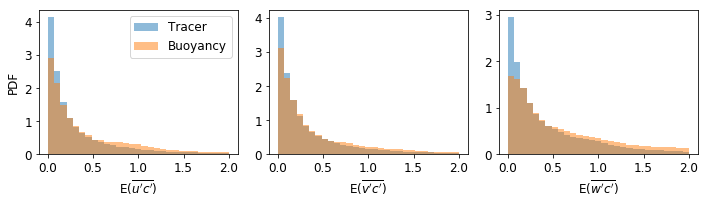

In [72]:
bins = np.linspace(0,2,30)
weights = np.tile(bins[1], 30)

plt.figure(figsize=(10,3))

plt.subplot(131)
[_,_,_] = errU_corr.plot.hist(bins=bins, alpha=0.5,label='Tracer', density=True)
[_,_,_] = errUB_corr.plot.hist(bins=bins, alpha=0.5,label='Buoyancy', density=True)
plt.legend()
plt.xlabel('E($\overline{u\'c\'}$)')
plt.title('')
plt.ylabel('PDF')


plt.subplot(132)
[_,_,_] = errV_corr.plot.hist(bins=bins, alpha=0.5, density=True)
[_,_,_] = errVB_corr.plot.hist(bins=bins, alpha=0.5, density=True)
plt.xlabel('E($\overline{v\'c\'}$)')
plt.title('')

plt.subplot(133)
[_,_,_] = errW_corr.plot.hist(bins=bins, alpha=0.5,density=True)
[_,_,_] = errWB_corr.plot.hist(bins=bins, alpha=0.5,density=True)
plt.title('')
plt.xlabel('E($\overline{w\'c\'}$)')

plt.tight_layout()
#plt.savefig('error_pdf.pdf')

In [73]:
print(errU_corr.median(['XCicoarse','YCicoarse','Z','tracer_num']).values)
print(errV_corr.median(['XCicoarse','YCicoarse','Z','tracer_num']).values)
print(errW_corr.median(['XCicoarse','YCicoarse','Z','tracer_num']).values)

0.18340948
0.19600031
0.32404286


In [74]:
print(errUB_corr.median(['XCicoarse','YCicoarse','Z']).values)
print(errVB_corr.median(['XCicoarse','YCicoarse','Z']).values)
print(errWB_corr.median(['XCicoarse','YCicoarse','Z']).values)

0.3202991
0.2805936
0.7160916


In [ ]:
# Patterns of error 

In [123]:
errU_corr.tracer_num

<xarray.DataArray 'tracer_num' (tracer_num: 20)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])
Coordinates:
  * tracer_num  (tracer_num) int64 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20

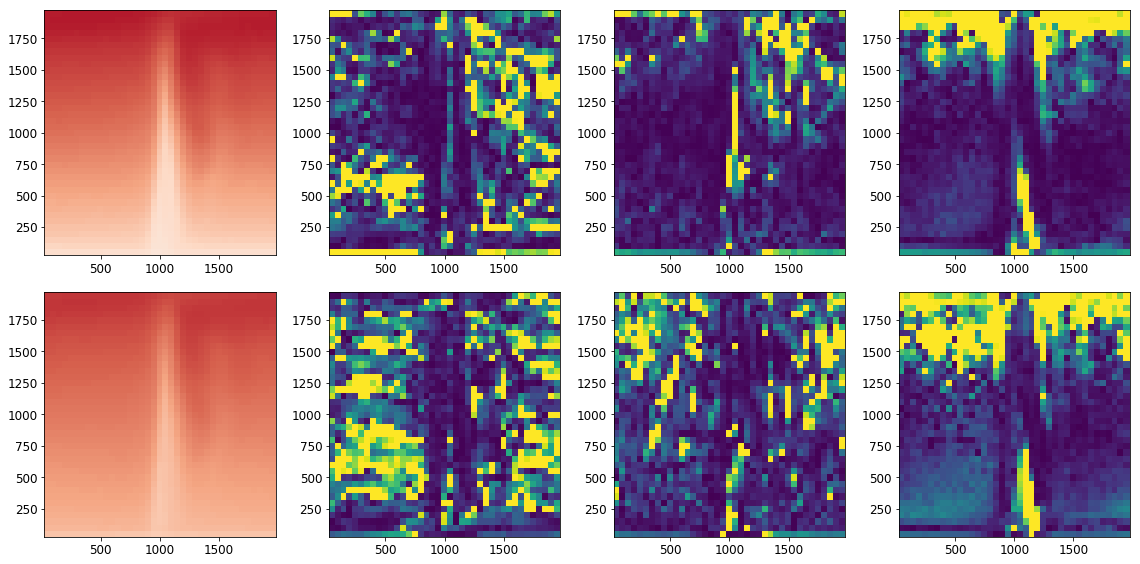

In [86]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'01'].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'02'].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=2).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=2).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=2).sel(Z=-500, method='nearest').T,
              vmax=1.)
plt.tight_layout()


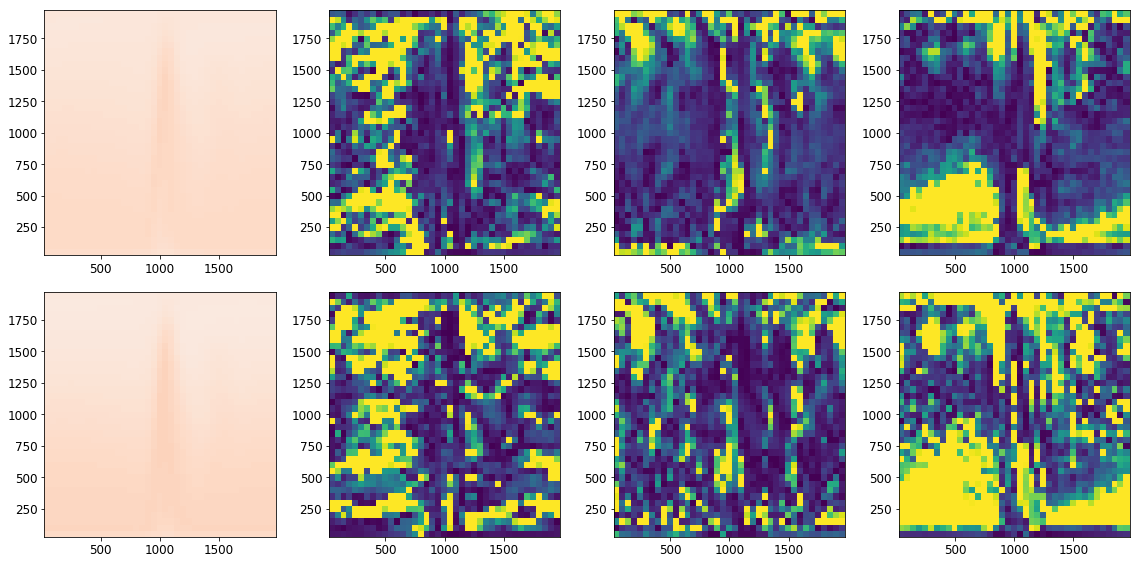

In [87]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=3 
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n+1)].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

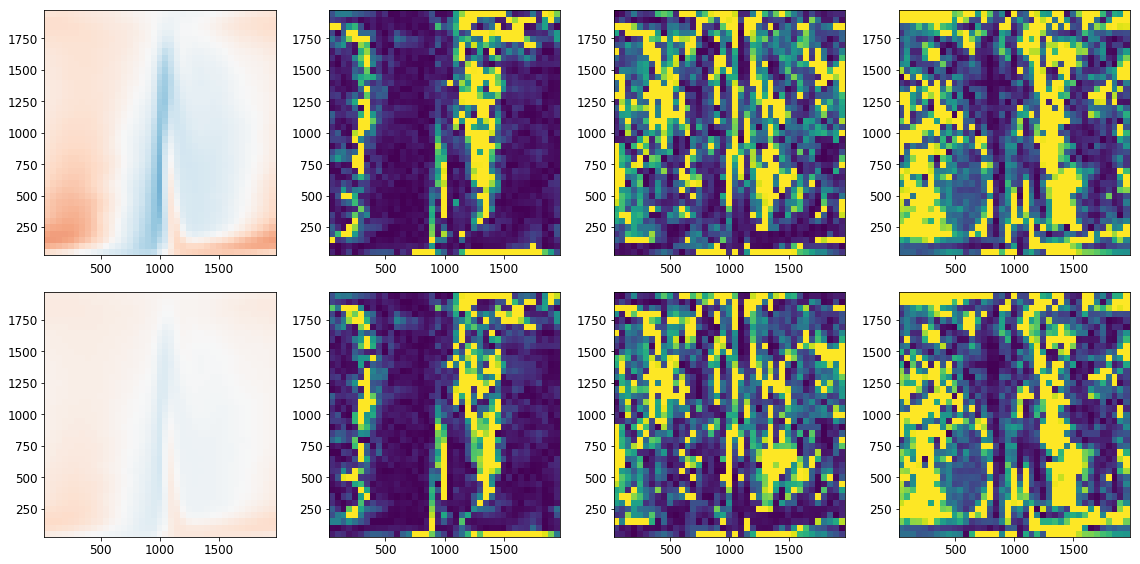

In [88]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=5
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n+1)].sel(Z=-500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

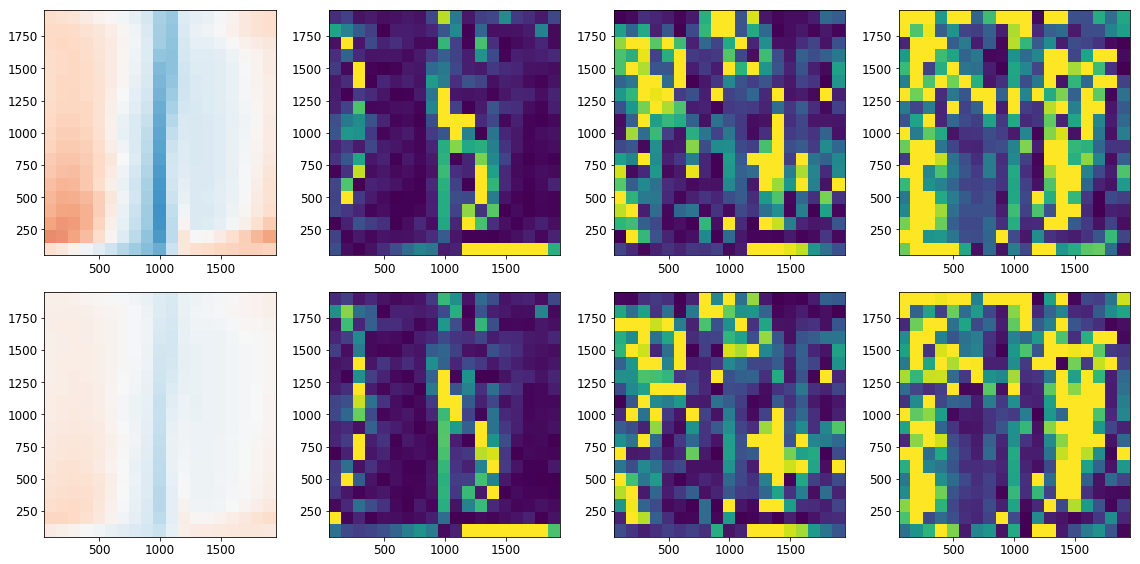

In [132]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=5
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

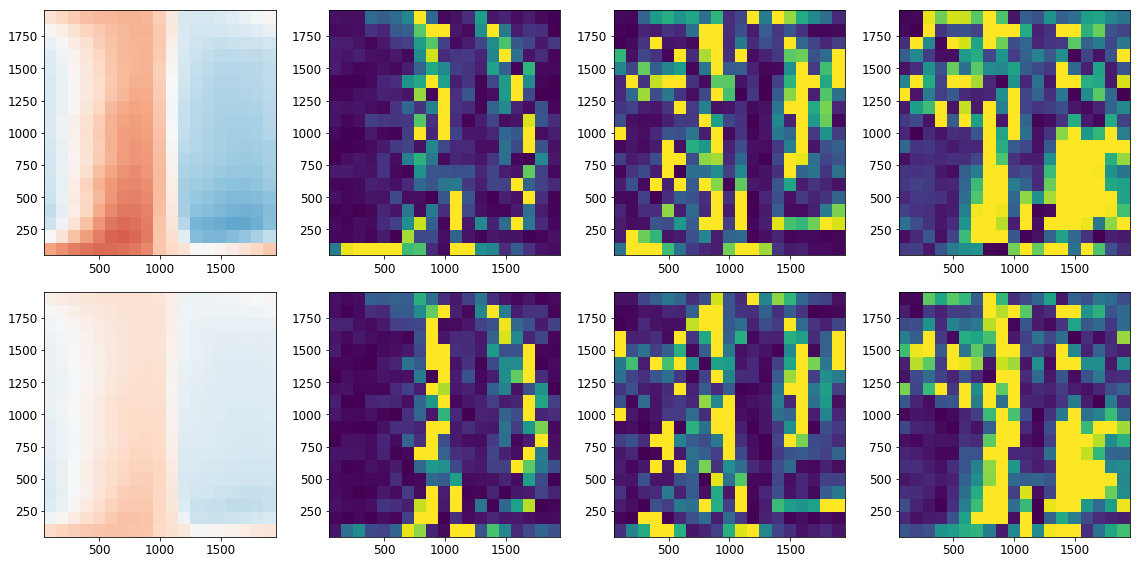

In [133]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=7
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

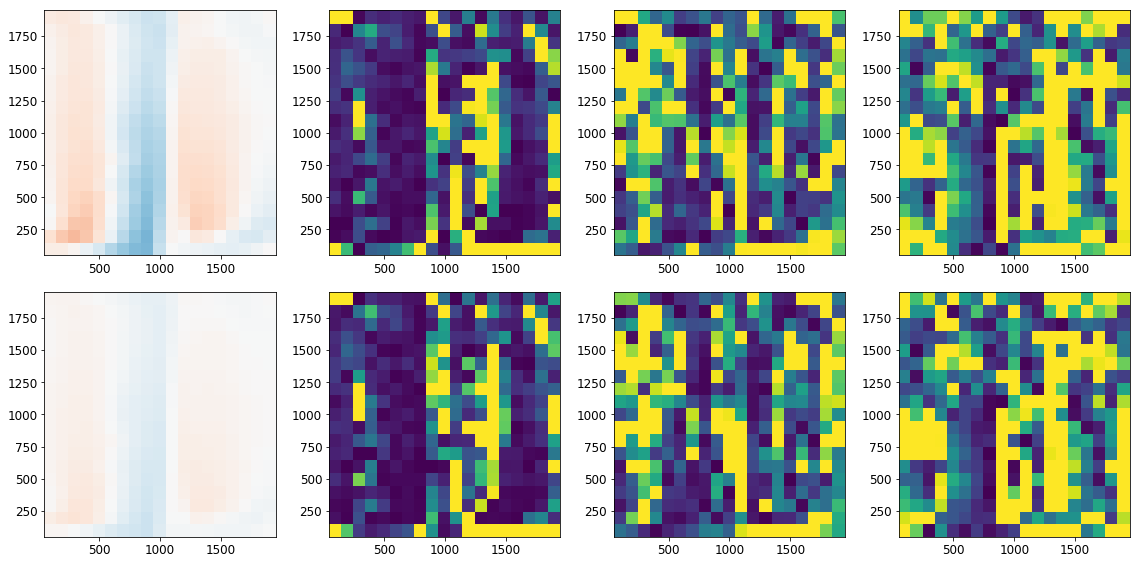

In [137]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=9
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+'0'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

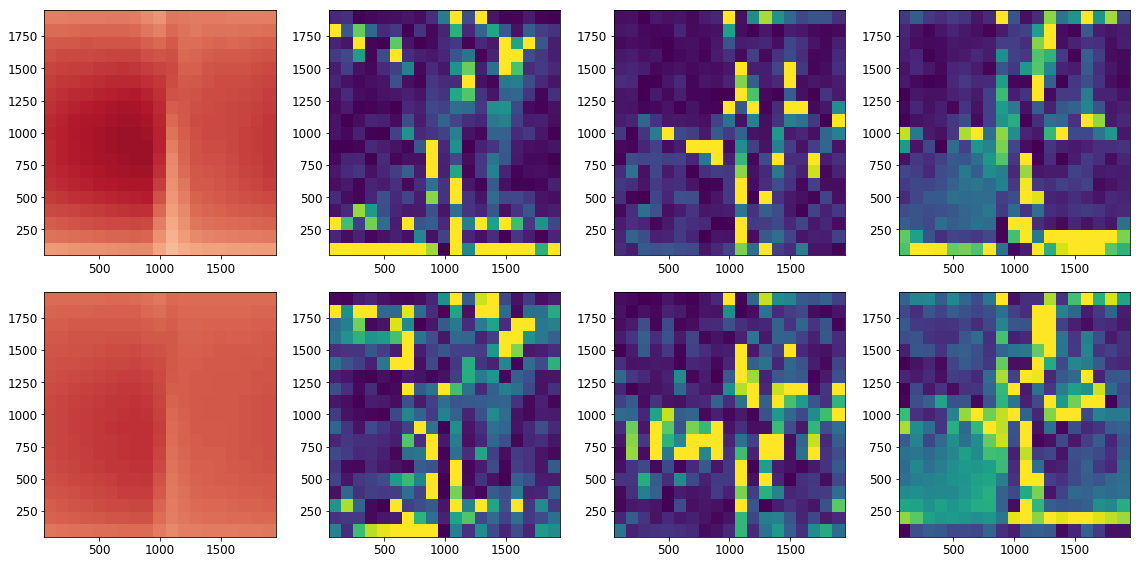

In [139]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=11
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

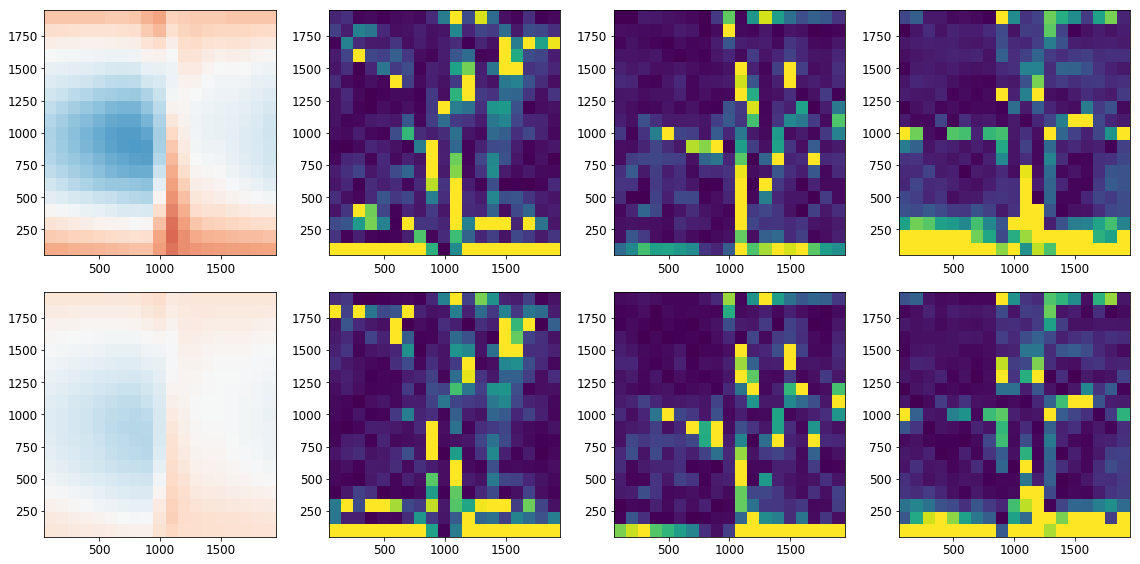

In [140]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=13
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

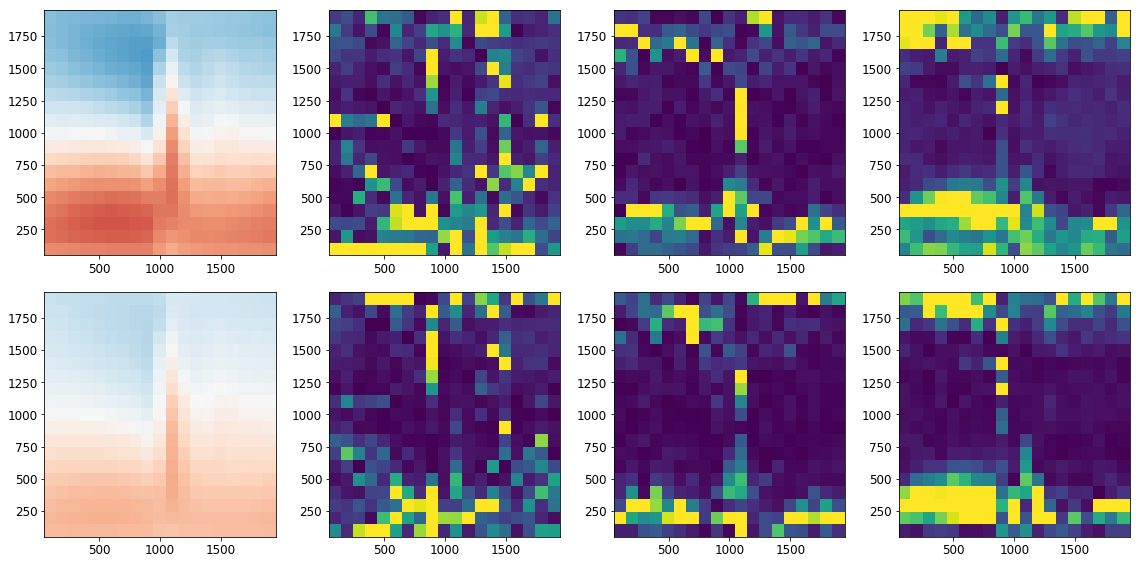

In [141]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))
n=15
ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, Trac_coarse['TRAC'+str(n+1)].sel(Z=-1500, method='nearest').T,
              vmin=-1, vmax=1., cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errU_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errV_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)

ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errW_corr.sel(tracer_num=n+1).sel(Z=-1500, method='nearest').T,
              vmax=1.)
plt.tight_layout()

### Recreated B fluxes

In [71]:
recUB_corr = Ktensor_corr.sel(i=0, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=0, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=0, j=2)*T_coarse.T_Z
recVB_corr = Ktensor_corr.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=1, j=2)*T_coarse.T_Z
recWB_corr = Ktensor_corr.sel(i=2, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=2, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=2, j=2)*T_coarse.T_Z

errUB_corr = np.abs(T_coarse.UpTp + recUB_corr)/np.abs(T_coarse.UpTp)
errVB_corr = np.abs(T_coarse.VpTp + recVB_corr)/np.abs(T_coarse.VpTp)
errWB_corr = np.abs(T_coarse.WpTp + recWB_corr)/np.abs(T_coarse.WpTp)

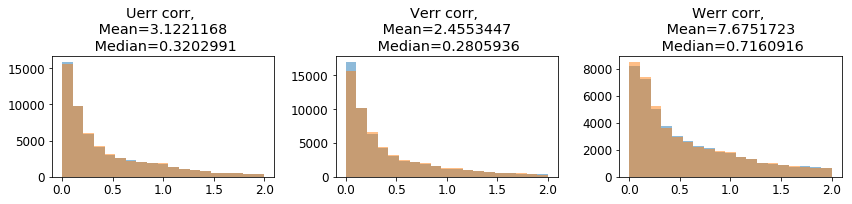

In [90]:
#  all the errors
bins = np.linspace(0,2,20)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errUB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errUB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_corr.median(['XCicoarse','YCicoarse','Z']).values

plt.title('Uerr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errVB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errVB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errVB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.title('Verr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errWB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errWB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.title('Werr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

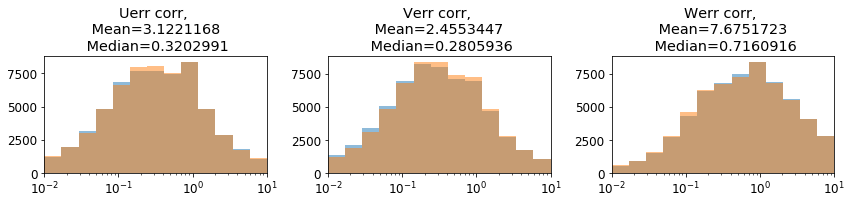

In [433]:
#  all the errors
bins = np.logspace(-2,1,14)
plt.figure(figsize=(12,3))

plt.subplot(131)
[_,_,_] =errUB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errUB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errUB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errUB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.xscale('log')
plt.xlim([0.01, 10])
plt.title('Uerr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))


plt.subplot(132)
[_,_,_] =errVB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errVB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errVB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errVB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.xscale('log')
plt.xlim([0.01, 10])
plt.title('Verr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))

plt.subplot(133)
[_,_,_] =errWB_corr.plot.hist(bins=bins, alpha=0.5)
[_,_,_] =errWB_slow.plot.hist(bins=bins, alpha=0.5)
m1 = errWB_corr.mean(['XCicoarse','YCicoarse','Z']).values
m2 = errWB_corr.median(['XCicoarse','YCicoarse','Z']).values
plt.xscale('log')
plt.xlim([0.01, 10])
plt.title('Werr corr, \n Mean=' + str(m1)+ ' \n Median='+str(m2))
plt.tight_layout()

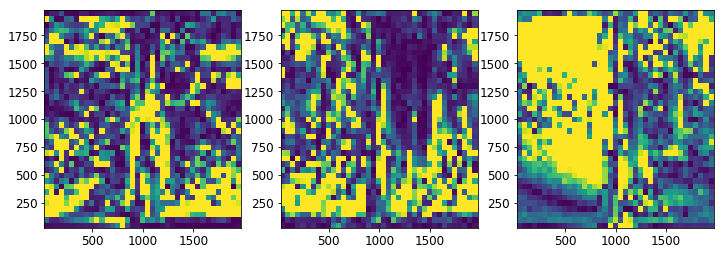

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errUB_corr.sel(Z=-500, method='nearest'),
              vmax=1.)

ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errVB_corr.sel(Z=-500, method='nearest'),
              vmax=1.)

ax[2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errWB_corr.sel(Z=-500, method='nearest'),
              vmax=1.)

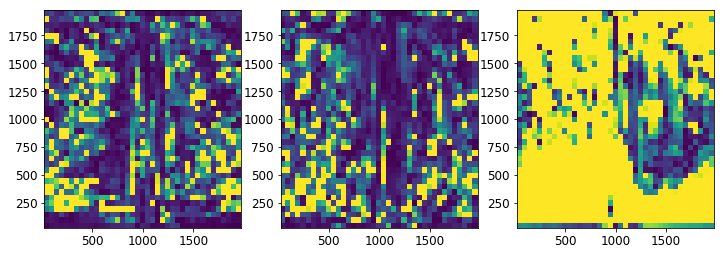

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errUB_corr.sel(Z=-1500, method='nearest'),
              vmax=1.)

ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errVB_corr.sel(Z=-1500, method='nearest'),
              vmax=1.)

ax[2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errWB_corr.sel(Z=-1500, method='nearest'),
              vmax=1.)

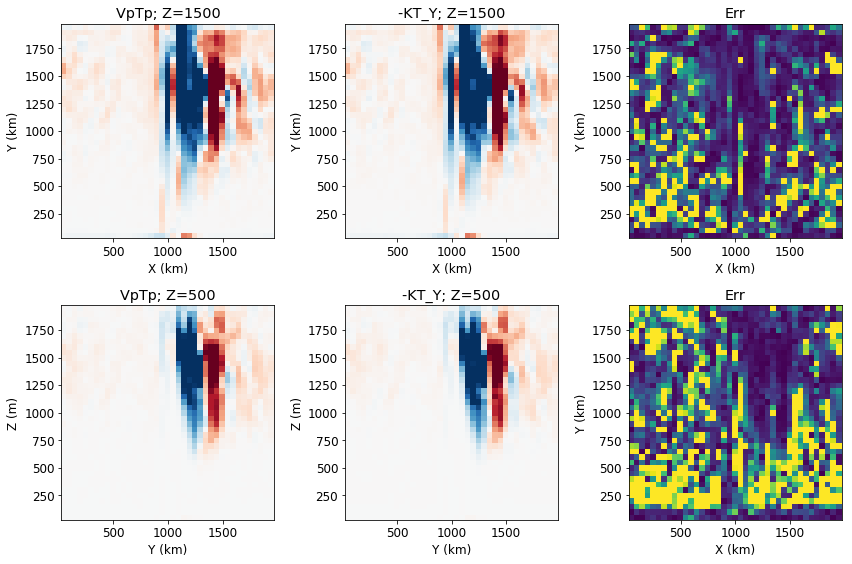

In [93]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'), vmin=-0.001, vmax=0.001, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_corr.sel(Z=-1500, method='nearest').T, vmin=-0.001, vmax=0.001, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errVB_corr.sel(Z=-1500, method='nearest'), vmin=0, vmax=1)
ax[0,2].set_title('Err')
ax[0,2].set_xlabel('X (km)')
ax[0,2].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_corr.sel(Z=-500, method='nearest').T, vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, errVB_corr.sel(Z=-500, method='nearest'), vmin=0, vmax=1)
ax[1,2].set_title('Err')
ax[1,2].set_xlabel('X (km)')
ax[1,2].set_ylabel('Y (km)')

plt.tight_layout()

# It appears that errors are large when the fluxes are small. 

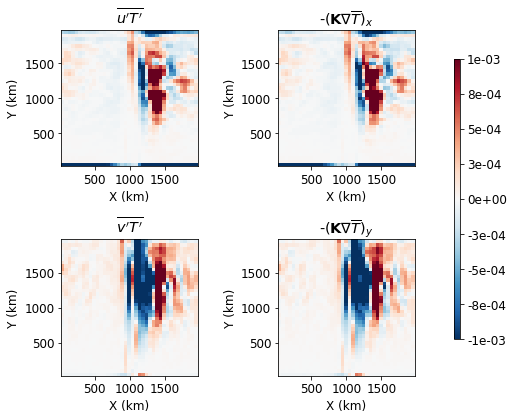

In [75]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.UpTp.sel(Z=-1500, method='nearest'),
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[0,0].set_aspect('equal')
ax[0,0].set_title('$\overline{u\'T\'}$')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recUB_corr.sel(Z=-1500, method='nearest').T, 
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[0,1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_x$')
ax[0,1].set_aspect('equal')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'),
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[1,0].set_aspect('equal')
ax[1,0].set_title('$\overline{v\'T\'}$')
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Y (km)')

im = ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recVB_corr.sel(Z=-1500, method='nearest').T, 
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)
ax[1,1].set_aspect('equal')
ax[1,1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_y$')
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Y (km)')


plt.tight_layout()


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax, format='%.0e')
#fig.colorbar(im, ax=ax.ravel().tolist())

#plt.savefig('reconstructed_temp_eddy_flux_1500m.pdf', dpi=400)

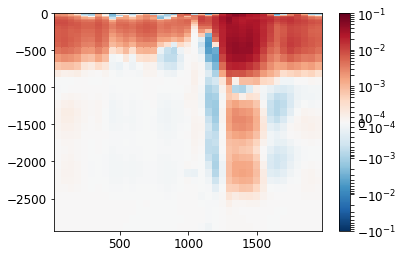

In [107]:
plt.pcolormesh(Xcoarse/1e3, Z, -recUB_corr.sel(YCicoarse=20, method='nearest').T, 
                    cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=5e-4, vmin=-0.1, vmax=0.1),  
                      rasterized=True)
plt.colorbar()

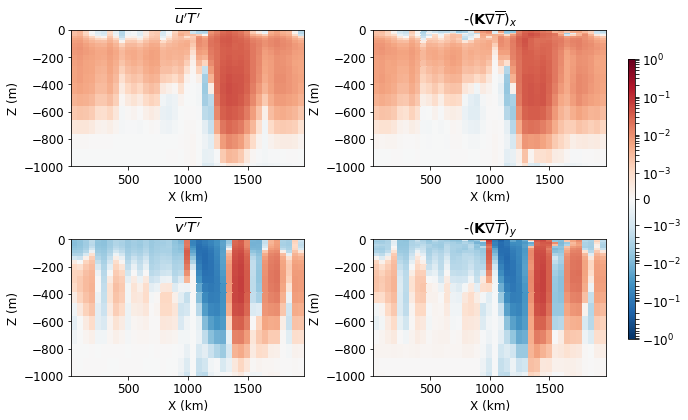

In [104]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

ax[0,0].pcolormesh(Xcoarse/1e3, Z, T_coarse.UpTp.sel(YCicoarse=20, method='nearest'),
                   vmin=-1, vmax=1, cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=1e-3), 
                 rasterized=True)
#ax[0,0].set_aspect('equal')
ax[0,0].set_ylim([-1000,0])
ax[0,0].set_title('$\overline{u\'T\'}$')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Z (m)')

im = ax[0,1].pcolormesh(Xcoarse/1e3, Z, -recUB_corr.sel(YCicoarse=20, method='nearest').T, 
                    cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=1e-3, vmin=-1, vmax=1),  
                      rasterized=True)
#fig.colorbar(im, ax =ax[1])
ax[0,1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_x$')
#ax[0,1].set_aspect('equal')
ax[0,1].set_ylim([-1000, 0])
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Z (m)')

ax[1,0].pcolormesh(Xcoarse/1e3, Z, T_coarse.VpTp.sel(YCicoarse=20, method='nearest'),
                   vmin=-1, vmax=1, cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=1e-3), 
                 rasterized=True)
#ax[1,0].set_aspect('equal')
ax[1,0].set_ylim([-1000,0])
ax[1,0].set_title('$\overline{v\'T\'}$')
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Z (m)')

im = ax[1,1].pcolormesh(Xcoarse/1e3, Z, -recVB_corr.sel(YCicoarse=20, method='nearest').T, 
                    cmap='RdBu_r', norm = colors.SymLogNorm(linthresh=1e-3, vmin=-1, vmax=1),  
                      rasterized=True)
#fig.colorbar(im, ax =ax[1])
ax[1,1].set_title(r'-$(\mathbf{K} \nabla \overline{T})_y$')
#ax[1,1].set_aspect('equal')
ax[1,1].set_ylim([-1000, 0])
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Z (m)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)


plt.savefig('reconstructed_temp_eddy_flux_Y_1000km.pdf', dpi=400)

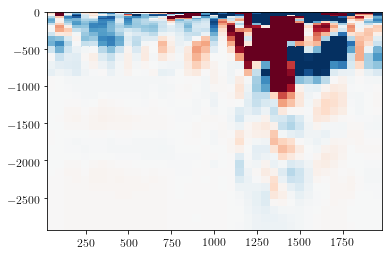

In [473]:
plt.pcolormesh(Xcoarse/1e3, Z,  T_coarse.UpTp.sel(YCicoarse=20, method='nearest')+
                 recUB_corr.sel(YCicoarse=20, method='nearest').T, 
                   vmin=-0.001, vmax=0.001, cmap='RdBu_r', rasterized=True)

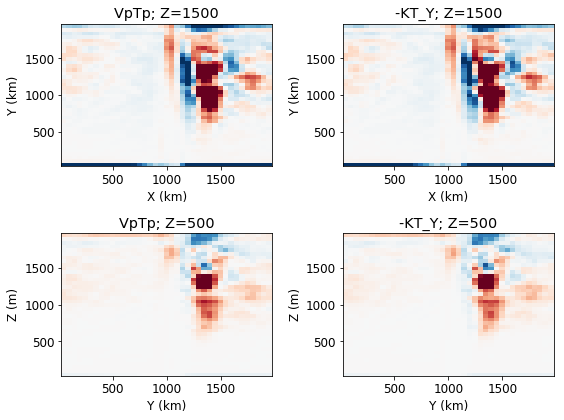

In [435]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.UpTp.sel(Z=-1500, method='nearest'), vmin=-0.001, vmax=0.001, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recUB_corr.sel(Z=-1500, method='nearest').T, vmin=-0.001, vmax=0.001, cmap='RdBu_r')
ax[0,1].set_title('-KT_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')



ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.UpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, -recUB_corr.sel(Z=-500, method='nearest').T, vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-KT_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')



plt.tight_layout()

# It appears that errors are large when the fluxes are small. 

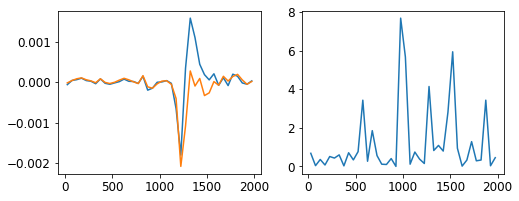

In [108]:
plt.figure(figsize=(8,3) )

plt.subplot(121)
plt.plot(Xcoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest').sel(YCicoarse=10))
plt.plot(Xcoarse/1e3, -recVB_corr.sel(Z=-500, method='nearest').sel(YCicoarse=10))

plt.subplot(122)
plt.plot(Xcoarse/1e3, errVB_corr.sel(Z=-500, method='nearest').sel(YCicoarse=10))


(-0.004, 0.004)

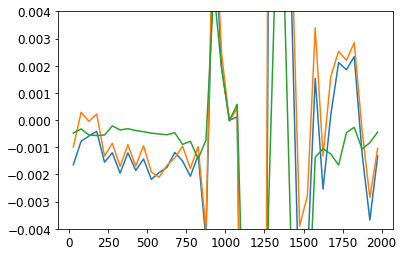

In [326]:
#plt.subplot(121)
plt.plot(Xcoarse/1e3, T_coarse.VpTp.sel(Z=-100, method='nearest').sel(YCicoarse=10))
plt.plot(Xcoarse/1e3, -recVB_corr.sel(Z=-100, method='nearest').sel(YCicoarse=10))
plt.plot(Xcoarse/1e3, -recVB_AT.sel(Z=-100, method='nearest').sel(YCicoarse=10))

plt.ylim([-4e-3, 4e-3])

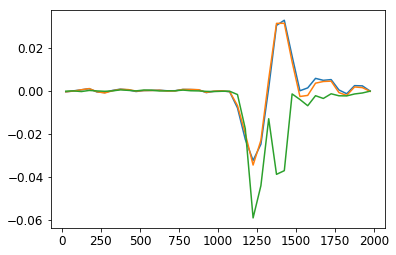

In [332]:
#plt.subplot(121)
plt.plot(Xcoarse/1e3, T_coarse.VpTp.sel(Z=-600, method='nearest').sel(YCicoarse=20))
plt.plot(Xcoarse/1e3, -recVB_corr.sel(Z=-600, method='nearest').sel(YCicoarse=20))
plt.plot(Xcoarse/1e3, -recVB_AT.sel(Z=-600, method='nearest').sel(YCicoarse=20))


Marginal improvement when using corrected fluxes, in contrast to the slow fluxes.

We will just use the corrected tensor from now on. 

 ## Decompose into Symmetric and Antisymmetric Parts

In [109]:
Ktensor_corrT = Ktensor_corr.transpose('XCicoarse','YCicoarse','Z','j','i')

ST = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
AT = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

ST = xr.DataArray(ST, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
AT = xr.DataArray(AT, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [113]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsST, eigvecsST = xr.apply_ufunc(eig, ST, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


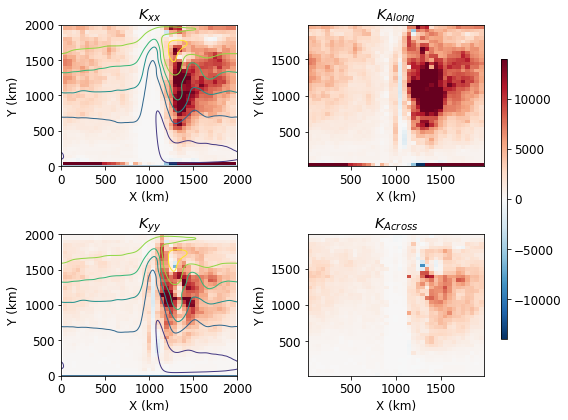

In [156]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=0,j=0).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[0,0].contour(X/1e3, Y/1e3, Model_Tav.ETAtave, levels=np.linspace(-0.5,0.5, 7)
               , rasterized=True, linewidths=1.)
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')
ax[0,0].set_title('$K_{xx}$')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, np.real(eigvalsST).isel(ii=0).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')
ax[0,1].set_title('$K_{Along}$')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=1,j=1).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[1,0].contour(X/1e3, Y/1e3, Model_Tav.ETAtave, levels=np.linspace(-0.5,0.5, 7)
               , rasterized=True, linewidths=1.)
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Y (km)')
ax[1,0].set_title('$K_{yy}$')

im =ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, np.real(eigvalsST).isel(ii=1).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', rasterized=True)
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Y (km)')
ax[1,1].set_title('$K_{Across}$')

plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

#plt.savefig('Khor_1500m.pdf', dpi=400)

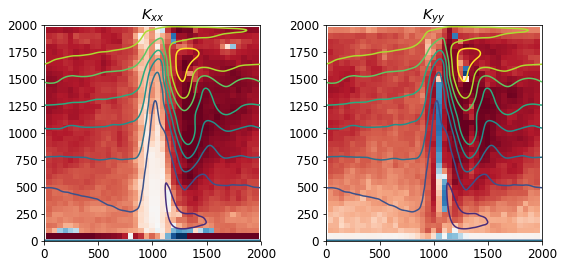

In [158]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=0,j=0).sel(Z=-1500, method='nearest').T,
                  vmin=-14000, vmax=14000, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=100))
ax[0].contour(X/1e3, Y/1e3, Model_Tav.ETAtave, levels=np.linspace(-0.5,0.5, 9))
ax[0].set_aspect('equal')
ax[0].set_title('$K_{xx}$')

ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=1,j=1).sel(Z=-1500, method='nearest').T,
                  vmin=-10000, vmax=10000, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=100))
ax[1].contour(X/1e3, Y/1e3, Model_Tav.ETAtave, levels=np.linspace(-0.5,0.5, 9))
ax[1].set_aspect('equal')
ax[1].set_title('$K_{yy}$')

plt.tight_layout()



Text(0.5, 1.0, 'K_ZZ')

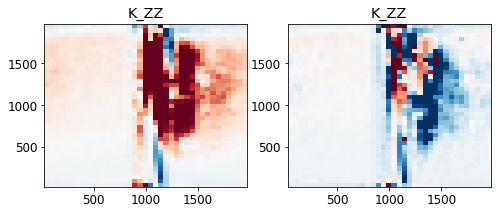

In [148]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, ST.isel(i=2,j=2).sel(Z=-1500, method='nearest').T,
                  vmin=-2e-3, vmax=2e-3, cmap='RdBu_r')
plt.title('K_ZZ')

plt.subplot(122)
plt.pcolormesh(Xcoarse/1e3, Ycoarse/1e3, np.real(eigvalsST).isel(ii=2).sel(Z=-1500, method='nearest').T,
                  vmin=-2e-3, vmax=2e-3, cmap='RdBu_r')
plt.title('K_ZZ')

In [159]:
Kalong = np.real(eigvalsST).isel(ii=0)
Kacross = np.real(eigvalsST).isel(ii=1)

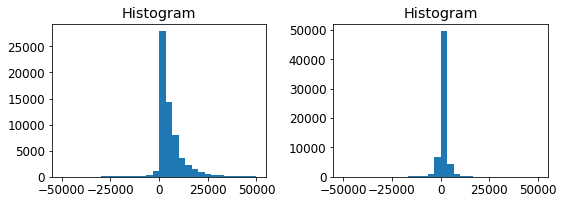

In [173]:
Kbins = np.linspace(-5e4,5e4, 31)

plt.figure(figsize=(8,3))

plt.subplot(121)
[_,_,_] = Kalong.plot.hist(bins=Kbins)
#plt.yscale('log')

plt.subplot(122)
[_,_,_] = Kacross.plot.hist(bins=Kbins)
#plt.yscale('log')
plt.tight_layout()

In [192]:
xedges=np.linspace(-8e4,8e4, 51)
yedges=np.linspace(-3e4,3e4, 51)

In [193]:
x = Kalong.values.reshape(-1)
y = Kacross.values.reshape(-1)

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.

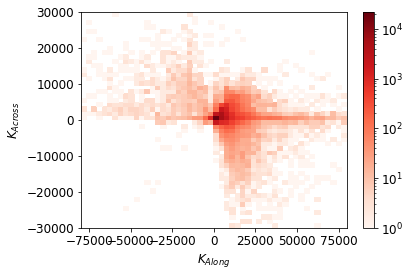

In [197]:
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, H, norm=colors.LogNorm(), cmap='Reds')
plt.colorbar()
plt.xlabel('$K_{Along}$')
plt.ylabel('$K_{Across}$')
#plt.xlim([-25e3,25e3])
#plt.ylim([-25e3,25e3])
plt.tight_layout()

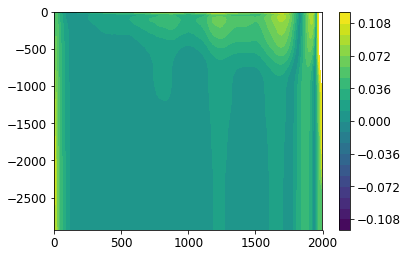

In [220]:
plt.contourf(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), vmin=-0.12, vmax=0.12, levels=np.linspace(-0.12,0.12,21))
plt.colorbar()

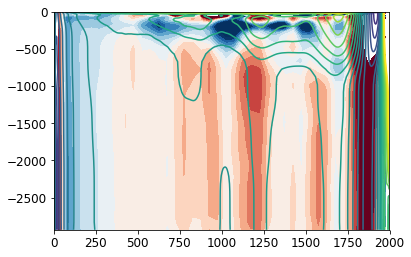

In [218]:
plt.contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-3e3, 3e3, 41), cmap='RdBu_r', rasterized=True, extend='Both')
plt.contour(Y/1e3, Z, Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG'), vmin=-0.12, vmax=0.12, levels=np.linspace(-0.12,0.12,21))


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'rasterized'
  s)


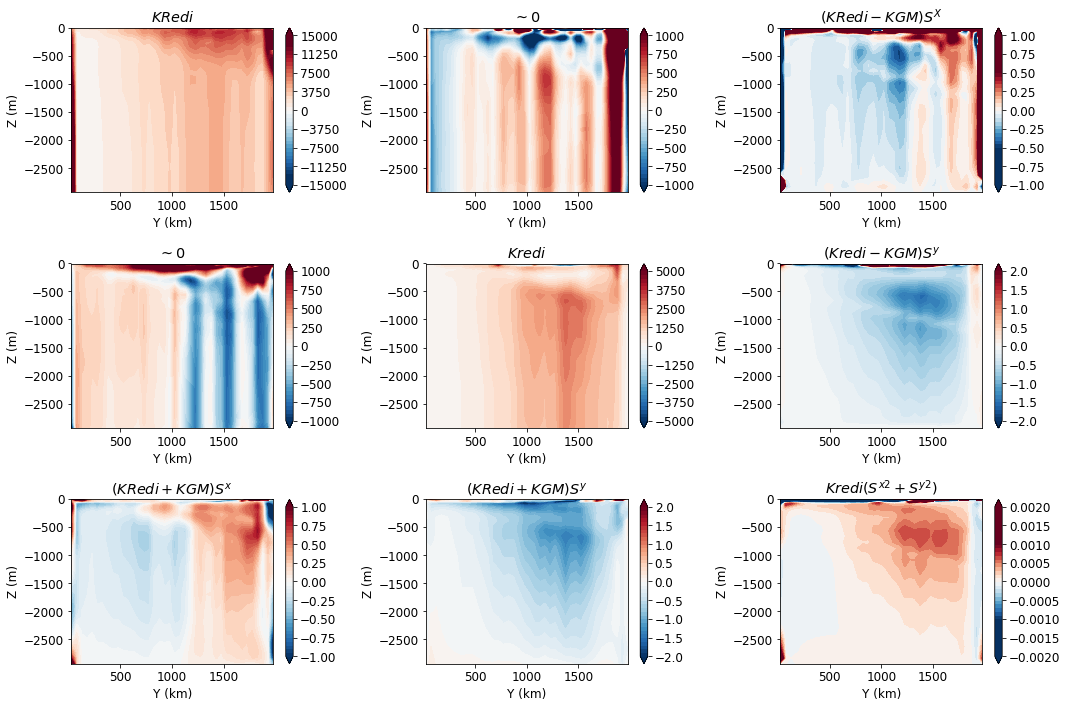

In [226]:
#  Full tensor 
fig , ax = plt.subplots(3,3,figsize=(15,10))

im = ax[0,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('$KRedi$')
ax[0,0].set_xlabel('Y (km)')
ax[0,0].set_ylabel('Z (m)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), extend='both', cmap='RdBu_r', rasterized=True)
#ax[0,1].contour(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), 
#                vmin=0, vmax=0.12, levels=np.linspace(0,0.12,11))
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('$\sim 0$')
ax[0,1].set_xlabel('Y (km)')
ax[0,1].set_ylabel('Z (m)')

im = ax[0,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('$(KRedi -KGM)S^X$')
ax[0,2].set_xlabel('Y (km)')
ax[0,2].set_ylabel('Z (m)')
##
im = ax[1,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), extend='both', cmap='RdBu_r', rasterized=True)
#ax[1,0].contour(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), 
#                vmin=0, vmax=0.12, levels=np.linspace(0,0.12,11))
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('$\sim 0$')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

im = ax[1,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('$Kredi$')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

im = ax[1,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('$(Kredi -KGM) S^y$')
ax[1,2].set_xlabel('Y (km)')
ax[1,2].set_ylabel('Z (m)')

##
im = ax[2,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('$(KRedi +KGM) S^x$')
ax[2,0].set_xlabel('Y (km)')
ax[2,0].set_ylabel('Z (m)')

im = ax[2,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('$(KRedi +KGM) S^y$')
ax[2,1].set_xlabel('Y (km)')
ax[2,1].set_ylabel('Z (m)')

im = ax[2,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('$Kredi ( S^{x2}+ S^{y2})$')
ax[2,2].set_xlabel('Y (km)')
ax[2,2].set_ylabel('Z (m)')

plt.tight_layout()

plt.savefig('Ktensor_0_400km.pdf', dpi=400)

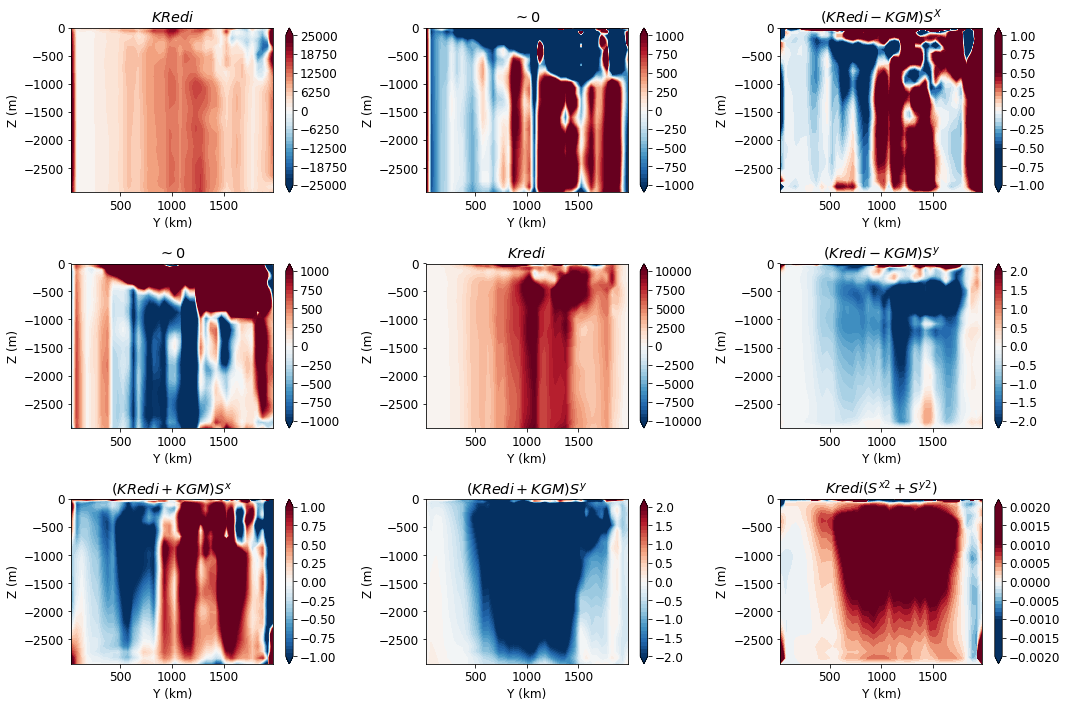

In [229]:
#  Full tensor 
fig , ax = plt.subplots(3,3,figsize=(15,10))

im = ax[0,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=0).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-23000, vmax=23000, levels=np.linspace(-25e3, 25e3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('$KRedi$')
ax[0,0].set_xlabel('Y (km)')
ax[0,0].set_ylabel('Z (m)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=1).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), extend='both', cmap='RdBu_r', rasterized=True)
#ax[0,1].contour(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), 
#                vmin=0, vmax=0.12, levels=np.linspace(0,0.12,11))
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('$\sim 0$')
ax[0,1].set_xlabel('Y (km)')
ax[0,1].set_ylabel('Z (m)')

im = ax[0,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=0, j=2).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('$(KRedi -KGM)S^X$')
ax[0,2].set_xlabel('Y (km)')
ax[0,2].set_ylabel('Z (m)')
##
im = ax[1,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=0).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), extend='both', cmap='RdBu_r', rasterized=True)
#ax[1,0].contour(Y/1e3, Z, np.abs(Model_Tav.uVeltave.sel(XG=slice(0,400e3)).mean('XG')), 
#                vmin=0, vmax=0.12, levels=np.linspace(0,0.12,11))
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('$\sim 0$')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

im = ax[1,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=1).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-10000, vmax=10000, levels=np.linspace(-10e3, 10e3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('$Kredi$')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

im = ax[1,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=1, j=2).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('$(Kredi -KGM) S^y$')
ax[1,2].set_xlabel('Y (km)')
ax[1,2].set_ylabel('Z (m)')

##
im = ax[2,0].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=0).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('$(KRedi +KGM) S^x$')
ax[2,0].set_xlabel('Y (km)')
ax[2,0].set_ylabel('Z (m)')

im = ax[2,1].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=1).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('$(KRedi +KGM) S^y$')
ax[2,1].set_xlabel('Y (km)')
ax[2,1].set_ylabel('Z (m)')

im = ax[2,2].contourf(Ycoarse/1e3, Z, Ktensor_corr.isel(i=2, j=2).sel(XCicoarse=slice(24,32)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r', rasterized=True, extend='both')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('$Kredi ( S^{x2}+ S^{y2})$')
ax[2,2].set_xlabel('Y (km)')
ax[2,2].set_ylabel('Z (m)')

plt.tight_layout()

#plt.savefig('Ktensor_0_400km.pdf', dpi=400)

### S

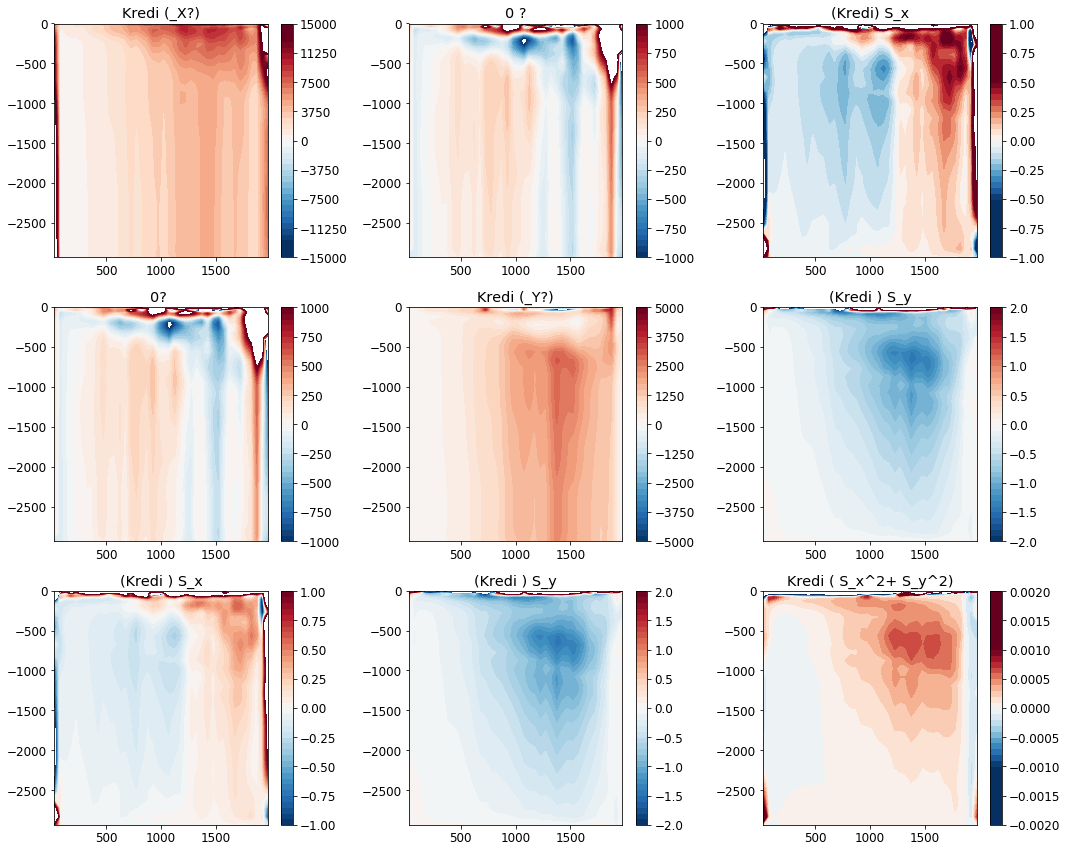

In [110]:
# 
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('Kredi (_X?)')

im = ax[0,1].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, ST.isel(i=0, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('(Kredi) S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('Kredi (_Y?)')


im = ax[1,2].contourf(Ycoarse/1e3, Z, ST.isel(i=1, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('(Kredi ) S_y')

##
im = ax[2,0].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1, vmax=1, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('(Kredi ) S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('(Kredi ) S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, ST.isel(i=2, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('Kredi ( S_x^2+ S_y^2)')

plt.tight_layout()

### A

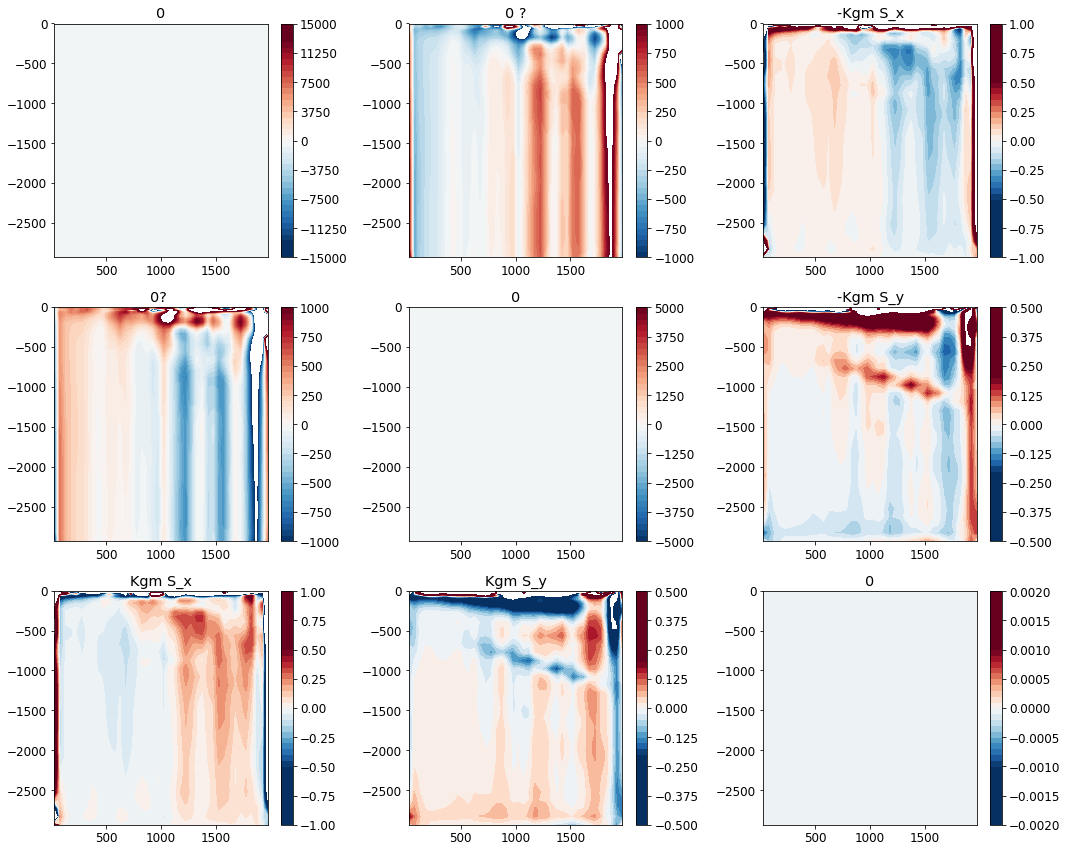

In [102]:
# 
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('0')

im = ax[0,1].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('-Kgm S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('0')


im = ax[1,2].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.2, vmax=0.2, levels=np.linspace(-0.5, 0.5, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('-Kgm S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=0).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('Kgm S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=1).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-0.2, vmax=0.2, levels=np.linspace(-0.5, 0.5, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('Kgm S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=2).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('0')

plt.tight_layout()

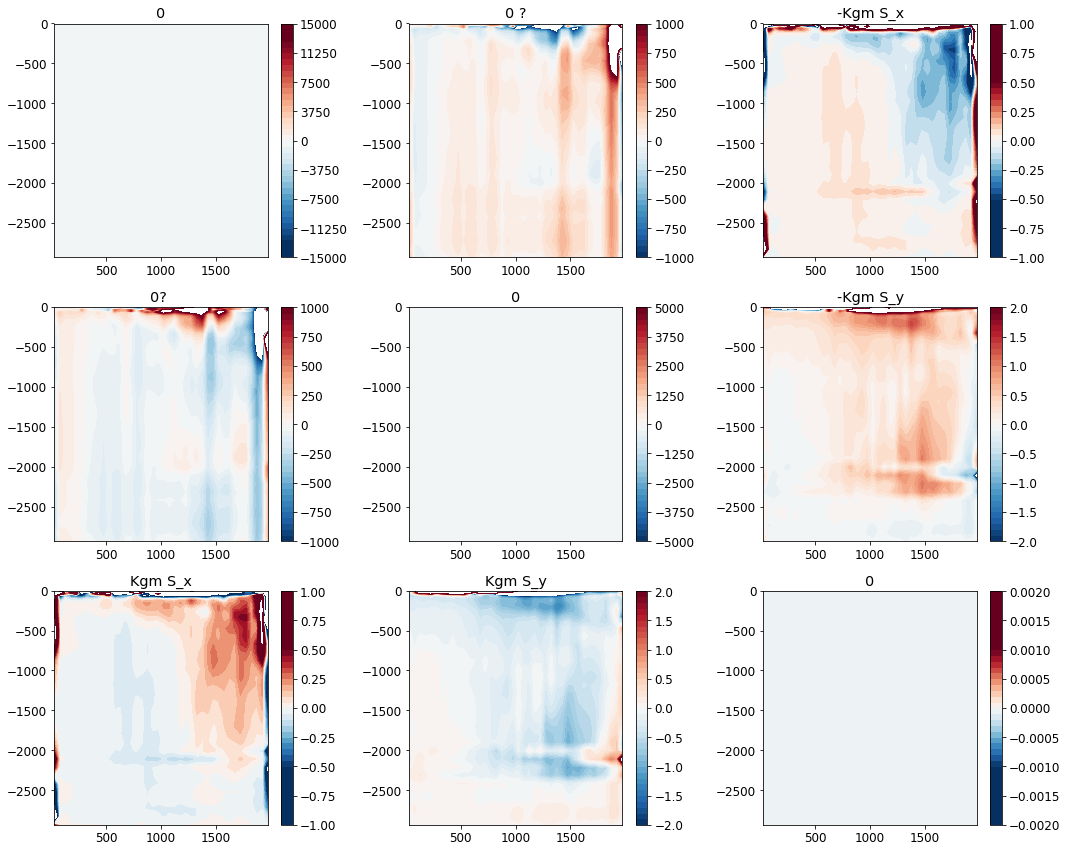

In [103]:
# 
fig , ax = plt.subplots(3,3,figsize=(15,12))

im = ax[0,0].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=0).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-13000, vmax=13000, levels=np.linspace(-15e3, 15e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,0])
ax[0,0].set_title('0')

im = ax[0,1].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=1).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,1])
ax[0,1].set_title('0 ?')

im = ax[0,2].contourf(Ycoarse/1e3, Z, AT.isel(i=0, j=2).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[0,2])
ax[0,2].set_title('-Kgm S_x')

##
im = ax[1,0].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=0).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-1000, vmax=1000, levels=np.linspace(-1e3, 1e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,0])
ax[1,0].set_title('0? ')

im = ax[1,1].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=1).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-5000, vmax=5000, levels=np.linspace(-5e3, 5e3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,1])
ax[1,1].set_title('0')


im = ax[1,2].contourf(Ycoarse/1e3, Z, AT.isel(i=1, j=2).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[1,2])
ax[1,2].set_title('-Kgm S_y')


##
im = ax[2,0].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=0).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-0.5, vmax=0.5, levels=np.linspace(-1, 1, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,0])
ax[2,0].set_title('Kgm S_x')

im = ax[2,1].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=1).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-2, vmax=2, levels=np.linspace(-2, 2, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,1])
ax[2,1].set_title('Kgm S_y')

im = ax[2,2].contourf(Ycoarse/1e3, Z, AT.isel(i=2, j=2).sel(XCicoarse=slice(12,20)).mean('XCicoarse').T, 
               vmin=-1e-3, vmax=1e-3, levels=np.linspace(-2e-3, 2e-3, 41), cmap='RdBu_r')
fig.colorbar(im , ax = ax[2,2])
ax[2,2].set_title('0')

plt.tight_layout()

## Slopes 

In [231]:
T_coarse['Siso_X'] = - T_coarse['T_X']/ T_coarse['T_Z']
T_coarse['Siso_Y'] = - T_coarse['T_Y']/ T_coarse['T_Z']

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


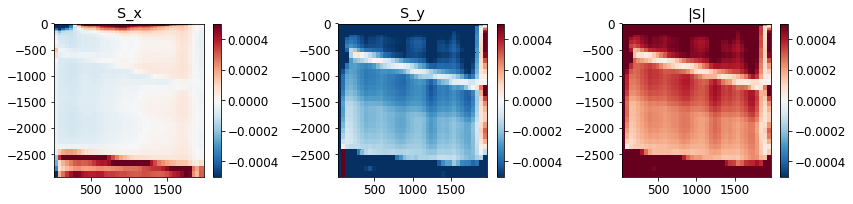

In [232]:
fig, ax = plt.subplots(1,3,figsize=(12,3))

im = ax[0].pcolormesh(Ycoarse/1e3, Z, T_coarse.Siso_X.sel(XCicoarse=slice(0,8)).mean('XCicoarse'),
                      vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[0])
ax[0].set_title('S_x')

im = ax[1].pcolormesh(Ycoarse/1e3, Z, T_coarse.Siso_Y.sel(XCicoarse=slice(0,8)).mean('XCicoarse'),
                      vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[1])
ax[1].set_title('S_y')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, ((T_coarse.Siso_Y**2 + T_coarse.Siso_X**2)**0.5  ).sel(XCicoarse=slice(0,8)).mean('XCicoarse'),
                      vmin=-5e-4, vmax=5e-4, cmap='RdBu_r')
fig.colorbar(im, ax = ax[2])
ax[2].set_title('|S|')

plt.tight_layout()

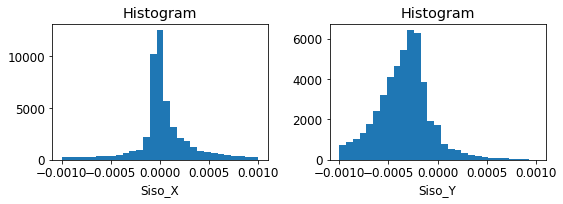

In [107]:
bins = np.linspace(-1,1,30)*1e-3

plt.figure(figsize=(8,3))
plt.subplot(121)
T_coarse.Siso_X.plot.hist(bins =bins)


plt.subplot(122)
T_coarse.Siso_Y.plot.hist(bins =bins)

plt.tight_layout()

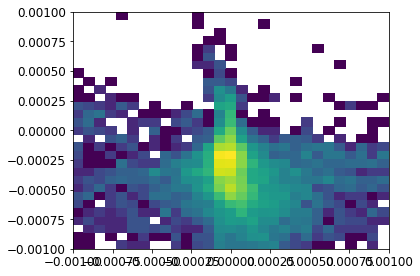

In [213]:
plt.hist2d(T_coarse.Siso_X.values.reshape(-1), T_coarse.Siso_Y.values.reshape(-1), bins=[bins,bins],norm= colors.LogNorm())
plt.xlim([-1e-3, 1e-3])
plt.ylim([-1e-3, 1e-3])

plt.tight_layout()

In [ ]:
## Kgm from only psi 2 
# Actually we get negative values if we look at the region that is upstream ... hmmm ???
# What happens if we naively use buoyancy fluxes to estimate Kgm (like can be done for zonal case?)

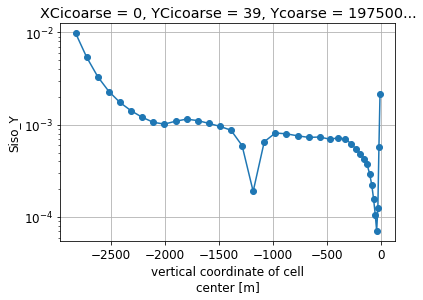

In [243]:
np.abs(T_coarse['Siso_Y'].sel(YCicoarse=1000e3, XCicoarse=0, method='nearest')).plot.line('o-')
plt.grid()
plt.yscale('log')

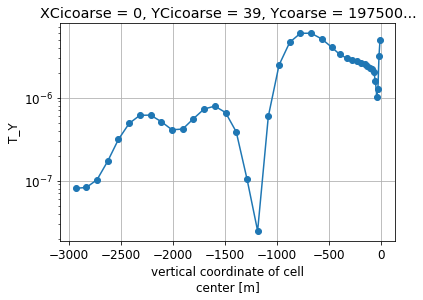

In [245]:
np.abs(T_coarse['T_Y'].sel(YCicoarse=1000e3, XCicoarse=0, method='nearest')).plot.line('o-')
plt.grid()
plt.yscale('log')

In [248]:
Ycoarse[20]

<xarray.DataArray 'Ycoarse' ()>
array(1025000., dtype=float32)
Coordinates:
    YCicoarse  int64 20
    Ycoarse    float32 1025000.0

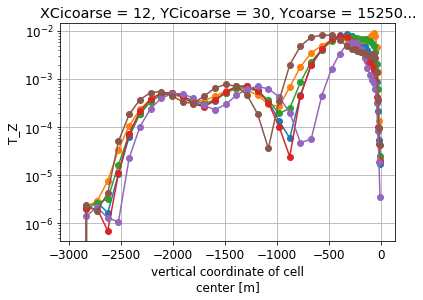

In [253]:
np.abs(T_coarse['T_Z'].sel(YCicoarse=20, XCicoarse=0, method='nearest')).plot.line('o-')
np.abs(T_coarse['T_Z'].sel(YCicoarse=20, XCicoarse=24, method='nearest')).plot.line('o-')
np.abs(T_coarse['T_Z'].sel(YCicoarse=20, XCicoarse=32, method='nearest')).plot.line('o-')
np.abs(T_coarse['T_Z'].sel(YCicoarse=20, XCicoarse=12, method='nearest')).plot.line('o-')
np.abs(T_coarse['T_Z'].sel(YCicoarse=10, XCicoarse=12, method='nearest')).plot.line('o-')
np.abs(T_coarse['T_Z'].sel(YCicoarse=30, XCicoarse=12, method='nearest')).plot.line('o-')

plt.grid()
plt.yscale('log')

In [ ]:
# Make a mask 

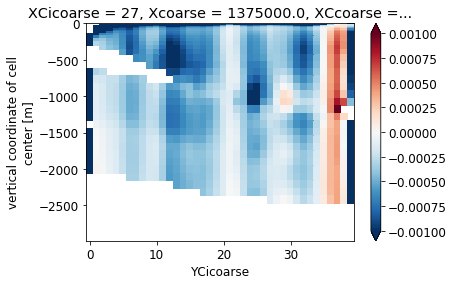

In [259]:
T_coarse['Siso_Y'].where(T_coarse.T_Z>2e-4).sel(XCicoarse=27).plot(vmin=-1e-3)

## What fraction of the tracer fluxes are captured by different parts of the tensor? 

In [260]:
# Naive attempt to calculate Kgm 
KgmY =  AT.isel(i=2, j=1)/T_coarse['Siso_Y'].where(T_coarse.T_Z>2e-4)
KgmX = AT.isel(i=2, j=0)/T_coarse['Siso_X'].where(T_coarse.T_Z>2e-4)

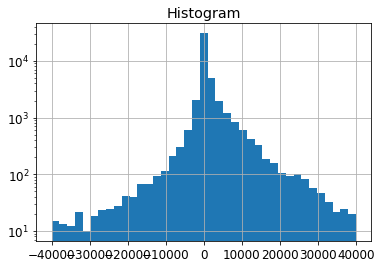

In [261]:
bins = np.linspace(-40000, 40000, 40)
KgmY.plot.hist(bins = bins)
plt.yscale('log')
#plt.xscale('log')
plt.grid()

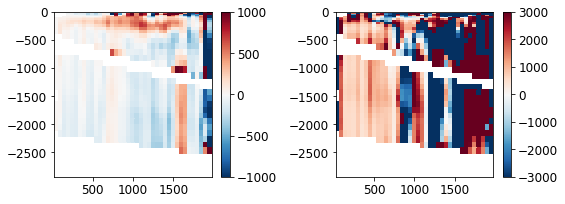

In [262]:
fig, ax = plt.subplots(1,2, figsize=(8,3))


im = ax[0].pcolormesh(Ycoarse/1e3, Z, KgmY.sel(XCicoarse=6).T, vmin=-1000, vmax=1000, cmap='RdBu_r')
fig.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(Ycoarse/1e3, Z, KgmX.sel(XCicoarse=6).T, vmin=-3000, vmax=3000, cmap='RdBu_r')
fig.colorbar(im, ax=ax[1])

plt.tight_layout()


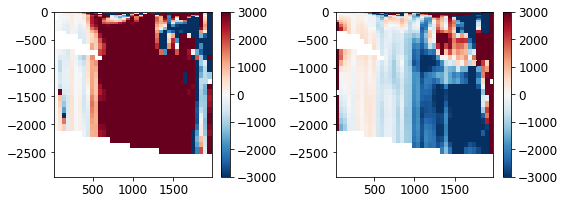

In [263]:
fig, ax = plt.subplots(1,2, figsize=(8,3))


im = ax[0].pcolormesh(Ycoarse/1e3, Z, KgmY.sel(XCicoarse=24).T, vmin=-3000, vmax=3000, cmap='RdBu_r')
fig.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(Ycoarse/1e3, Z, KgmX.sel(XCicoarse=24).T, vmin=-3000, vmax=3000, cmap='RdBu_r')
fig.colorbar(im, ax=ax[1])

plt.tight_layout()


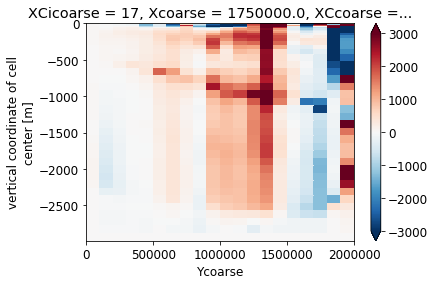

In [184]:
Kgm.sel(XCicoarse=17).plot(x='Ycoarse', y='Z', vmin=-3000)

In [264]:
Kgm = KgmY

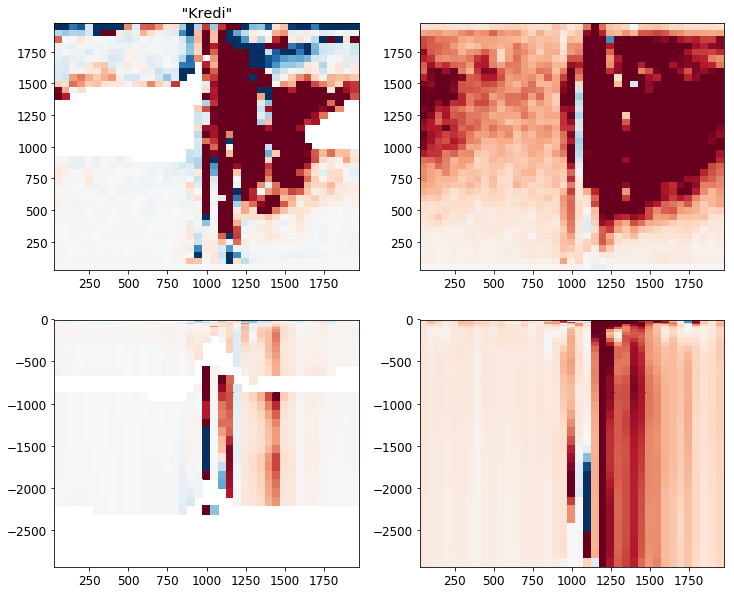

In [293]:
fig, ax = plt.subplots(2,2,figsize=(12,10)) 


ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, 
                   Kgm.sel(Z=-1000, method='nearest').T , vmin=-3000, vmax=3000, cmap='RdBu_r')
ax[0,0].set_title(' "Kgm" ')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, 
                   ST.isel(i=1,j=1).sel(Z=-1000, method='nearest').T , vmin=-3000, vmax=3000, cmap='RdBu_r')
ax[0,0].set_title(' "Kredi" ')

ax[1,0].pcolormesh(Xcoarse/1e3, Z, 
                   Kgm.sel(YCicoarse=10, method='nearest').T, vmin=-10000, vmax=10000, cmap='RdBu_r')

ax[1,1].pcolormesh(Xcoarse/1e3, Z, 
                   ST.isel(i=1,j=1).sel(YCicoarse=10, method='nearest').T, vmin=-5000, vmax=5000, cmap='RdBu_r')


In [304]:
KgmY_vermean = (KgmY * Kgm.drF).sum('Z') / Kgm.drF.sum('Z')
KgmX_vermean = (KgmX * Kgm.drF).sum('Z') / Kgm.drF.sum('Z')
KYY_vermean = (ST.isel(i=1,j=1)*ST.drF).sum('Z') / ST.drF.sum('Z')

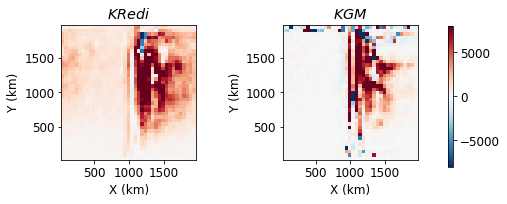

In [323]:
fig, ax = plt.subplots(1,2,figsize=(7.5,3))


im =ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, KYY_vermean.T,
            vmin=-8000, vmax=8000, cmap='RdBu_r'
            ,  rasterized=True)
#fig.colorbar(im, ax=ax[0])
ax[0].set_aspect('equal')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
ax[0].set_title('$KRedi$')


im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, KgmY_vermean.T,
            vmin=-8000, vmax=8000, cmap='RdBu_r'
            ,  rasterized=True)
#fig.colorbar(im, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Y (km)')
ax[1].set_title('$KGM$')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.86, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('K_ver_avg.pdf', dpi=400)


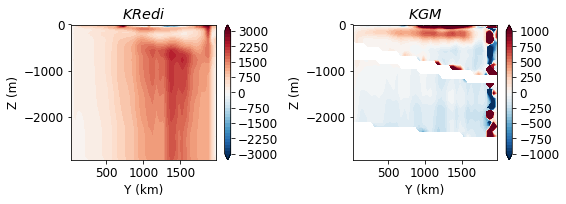

In [284]:
fig, ax = plt.subplots(1,2,figsize=(8,3))


im =ax[0].contourf(Ycoarse/1e3, Z, ST.isel(i=1,j=1).sel(XCicoarse=slice(0,16)).mean('XCicoarse').T,
            vmin=-3000, vmax=3000, cmap='RdBu_r', levels=np.linspace(-3000,3000,41)
            , extend='both', rasterized=True)
fig.colorbar(im, ax=ax[0])
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Z (m)')
ax[0].set_title('$KRedi$')


im = ax[1].contourf(Ycoarse/1e3, Z, Kgm.sel(XCicoarse=slice(0,16)).mean('XCicoarse').T,
            vmin=-1000, vmax=1000, cmap='RdBu_r', levels=np.linspace(-1000,1000,41)
            , extend='both', rasterized=True)
fig.colorbar(im, ax=ax[1])
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (m)')
ax[1].set_title('$KGM$')

plt.tight_layout()

plt.savefig('K_0_800km.pdf', dpi=400)

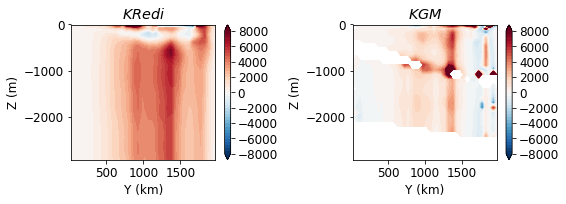

In [287]:
fig, ax = plt.subplots(1,2,figsize=(8,3))


im =ax[0].contourf(Ycoarse/1e3, Z, ST.isel(i=1,j=1).sel(XCicoarse=slice(30,40)).mean('XCicoarse').T,
            vmin=-8000, vmax=8000, cmap='RdBu_r', levels=np.linspace(-8000,8000,41)
            , extend='both', rasterized=True)
fig.colorbar(im, ax=ax[0])
ax[0].set_xlabel('Y (km)')
ax[0].set_ylabel('Z (m)')
ax[0].set_title('$KRedi$')


im = ax[1].contourf(Ycoarse/1e3, Z, Kgm.sel(XCicoarse=slice(30,40)).mean('XCicoarse').T,
            vmin=-8000, vmax=8000, cmap='RdBu_r', levels=np.linspace(-8000,8000,41)
            , extend='both', rasterized=True)
fig.colorbar(im, ax=ax[1])
ax[1].set_xlabel('Y (km)')
ax[1].set_ylabel('Z (m)')
ax[1].set_title('$KGM$')

plt.tight_layout()

plt.savefig('K_1500_2000km.pdf', dpi=400)

# Buoyancy Flux Recovery using only AT

Does not work currently. 

In [351]:
recVB_corr = Ktensor_corr.sel(i=1, j=0)*T_coarse.T_X + \
             Ktensor_corr.sel(i=1, j=1)*T_coarse.T_Y + \
             Ktensor_corr.sel(i=1, j=2)*T_coarse.T_Z
        
recVB_AT = AT.sel(i=1, j=0)*T_coarse.T_X + \
           AT.sel(i=1, j=1)*T_coarse.T_Y + \
           AT.sel(i=1, j=2)*T_coarse.T_Z        

In [352]:
# One of the struggles at the moment is with the diabaticness that is being introduced by 
# coarse graining. 

Text(0.5, 0, 'X')

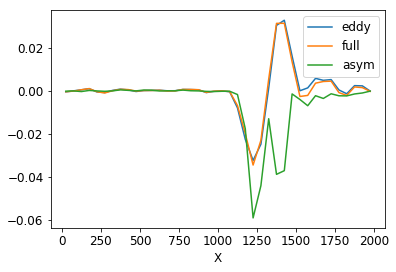

In [355]:
#plt.subplot(121)
plt.plot(Xcoarse/1e3, T_coarse.VpTp.sel(Z=-600, method='nearest').sel(YCicoarse=20), label='eddy')
plt.plot(Xcoarse/1e3, -recVB_corr.sel(Z=-600, method='nearest').sel(YCicoarse=20),label='full')
plt.plot(Xcoarse/1e3, -recVB_AT.sel(Z=-600, method='nearest').sel(YCicoarse=20), label='asym')
plt.legend()
plt.xlabel('X')

# PV fluxes

Writing the PV fluxes in the EP flux form: 

$$ u'q' = (u'v')_x + (\frac{v'^2 - u'^2}{2})_y + \frac{(b'^2)_y}{2N^2} + (f_o \frac{u'b'}{N^2})_z$$

$$ v'q' = (\frac{v'^2 - u'^2}{2})_x - \frac{(b'^2)_x}{2N^2} +  -(u'v')_y +(f_o \frac{v'b'}{N^2})_z$$

In [492]:
# no spatial averaging
upvp = grid.interp(grid.interp(Model_Tav.UVtave , 'X'), 'Y', boundary='extend') \
                   - Model_Tav.UmeanC*Model_Tav.VmeanC
vpvp = grid.interp(Model_Tav.VVtave, 'Y', boundary='extend')  - Model_Tav.VmeanC**2
upup = grid.interp(Model_Tav.UUtave, 'X') - Model_Tav.UmeanC**2

uptp = Model_Tav.UTtave - Model_Tav.UmeanC*Model_Tav.Ttave
vptp = Model_Tav.VTtave - Model_Tav.VmeanC*Model_Tav.Ttave

tptp = Model_Tav.TTtave - Model_Tav.Ttave**2

N2 = -grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 
                 'Z', boundary='extend')/Model_Tav.drF

In [494]:
dx = 5e3
dy = 5e3

In [495]:
g=9.81
alpha=2e-4
f0= -1.1e-4 
beta = 1.4e-11

In [496]:
# upqp
upqp1 =  grid.interp(grid.diff(upvp, 'X')/dx ,'X')
upqp2 = 0.5*grid.interp( grid.diff(vpvp -upup, 'Y', boundary='extend')/dy, 
                    'Y', boundary='extend')
upqp3 = 0.5*g*alpha/N2*grid.interp(grid.diff(tptp, 'Y', boundary='extend')/dy,
                          'Y', boundary='extend')
upqp4 = -f0*grid.interp( grid.diff(uptp/N2 ,'Z', boundary='extend'),
                      'Z', boundary='extend')/Model_Tav.drF
upqp = upqp1 + upqp2 + upqp3 + upqp4

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:997: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


In [497]:
# vpqp
vpqp1 = 0.5*grid.interp( grid.diff(vpvp -upup, 'X')/dx,'X')
vpqp2 = -0.5*g*alpha/N2*grid.interp(grid.diff(tptp, 'X')/dx,'X')
vpqp3 = -grid.interp(grid.diff(upvp, 'Y', boundary='extend')/dy ,
                      'Y', boundary='extend')
vpqp4 = -f0*grid.interp( grid.diff(vptp/N2 ,'Z', boundary='extend'),
                      'Z', boundary='extend')/Model_Tav.drF
vpqp = vpqp1 + vpqp2 + vpqp3 + vpqp4

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:997: RuntimeWarning: invalid value encountered in add
  return 0.5*(data_left + data_right)


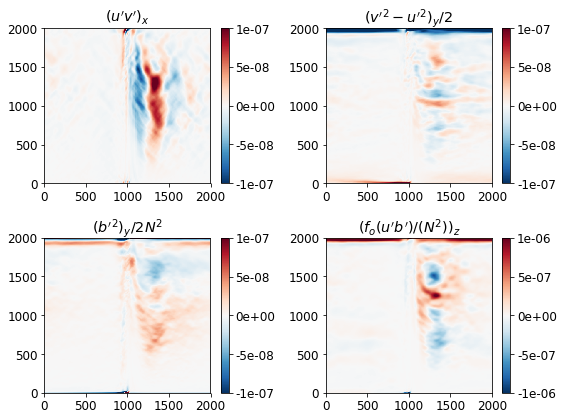

In [134]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

im = ax[0,0].pcolormesh(X/1e3, Y/1e3, upqp1.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('$(u\'v\')_x$')
fig.colorbar(im, ax=ax[0,0], format='%.0e')

im = ax[0,1].pcolormesh(X/1e3, Y/1e3, upqp2.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('$(v\'^2 - u\'^2)_y$/2 ')
fig.colorbar(im, ax=ax[0,1], format='%.0e')

im = ax[1,0].pcolormesh(X/1e3, Y/1e3, upqp3.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[1,0].set_title('$(b\'^2)_y/2N^2$')
fig.colorbar(im, ax=ax[1,0], format='%.0e')

im = ax[1,1].pcolormesh(X/1e3, Y/1e3, upqp4.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[1,1].set_title('$(f_o (u\'b\')/(N^2))_z$')

fig.colorbar(im, ax=ax[1,1], format='%.0e')

plt.tight_layout()

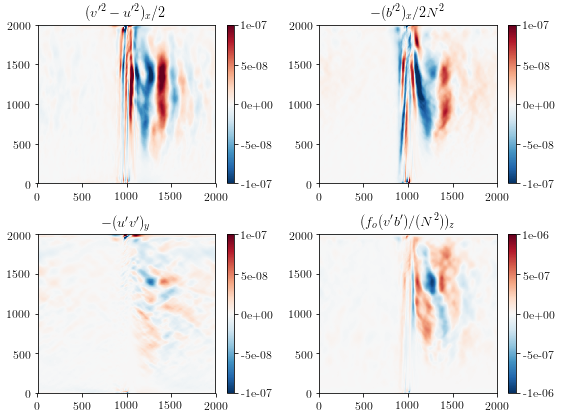

In [498]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

im = ax[0,0].pcolormesh(X/1e3, Y/1e3, vpqp1.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('$(v\'^2 - u\'^2)_x$/2 ')
fig.colorbar(im, ax=ax[0,0], format='%.0e')

im = ax[0,1].pcolormesh(X/1e3, Y/1e3, vpqp2.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('$-(b\'^2)_x/2N^2$')
fig.colorbar(im, ax=ax[0,1], format='%.0e')

im = ax[1,0].pcolormesh(X/1e3, Y/1e3, vpqp3.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[1,0].set_title('$-(u\'v\')_y$')
fig.colorbar(im, ax=ax[1,0], format='%.0e')

im = ax[1,1].pcolormesh(X/1e3, Y/1e3, vpqp4.sel(Z=-1500, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[1,1].set_title('$(f_o (v\'b\')/(N^2))_z$')

fig.colorbar(im, ax=ax[1,1], format='%.0e')

plt.tight_layout()

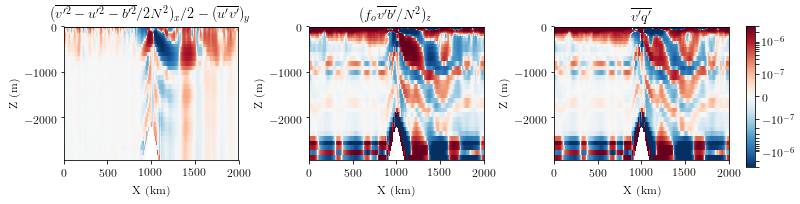

In [519]:
fig, ax = plt.subplots(1,3, figsize=(12,3))

im = ax[0].pcolormesh(X/1e3, Z, (vpqp1+vpqp2+vpqp3).sel(YC=1000e3, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[0].set_title('$(\overline{v\'^2 - u\'^2 -b\'^2}/2N^2)_x/2-(\overline{u\'v\'})_y$')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Z (m)')

im = ax[1].pcolormesh(X/1e3, Z, vpqp4.sel(YC=1000e3, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[1].set_title('$(f_o \overline{v\'b\'}/N^2)_z$')
ax[1].set_xlabel('X (km)')
ax[1].set_ylabel('Z (m)')

im = ax[2].pcolormesh(X/1e3, Z, (vpqp1+vpqp2+vpqp3+vpqp4).sel(YC=1000e3, method='nearest') ,
                        vmin=-3e-6, vmax=3e-6, cmap='RdBu_r', norm=colors.SymLogNorm(linthresh=1e-7), rasterized=True)
ax[2].set_title('$\overline{v\'q\'}$')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Z (m)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('PV_flux_components_XZ_1000km.pdf', dpi=400)

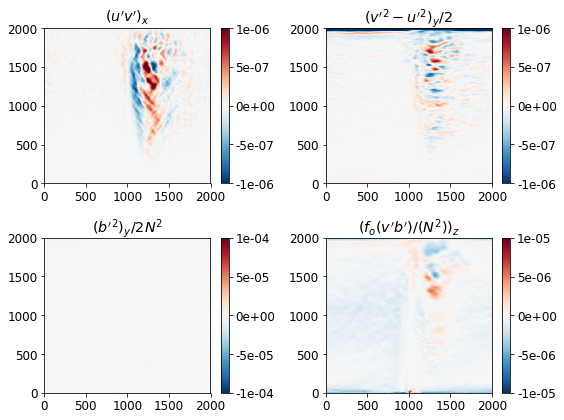

In [373]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

im = ax[0,0].pcolormesh(X/1e3, Y/1e3, upqp1.sel(Z=-200, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[0,0].set_title('$(u\'v\')_x$')
fig.colorbar(im, ax=ax[0,0], format='%.0e')

im = ax[0,1].pcolormesh(X/1e3, Y/1e3, upqp2.sel(Z=-200, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[0,1].set_title('$(v\'^2 - u\'^2)_y$/2 ')
fig.colorbar(im, ax=ax[0,1], format='%.0e')

im = ax[1,0].pcolormesh(X/1e3, Y/1e3, upqp3.sel(Z=-200, method='nearest') ,
                        vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')
ax[1,0].set_title('$(b\'^2)_y/2N^2$')
fig.colorbar(im, ax=ax[1,0], format='%.0e')

im = ax[1,1].pcolormesh(X/1e3, Y/1e3, upqp4.sel(Z=-200, method='nearest') ,
                        vmin=-1e-5, vmax=1e-5, cmap='RdBu_r')
ax[1,1].set_title('$(f_o (v\'b\')/(N^2))_z$')

fig.colorbar(im, ax=ax[1,1], format='%.0e')

plt.tight_layout()

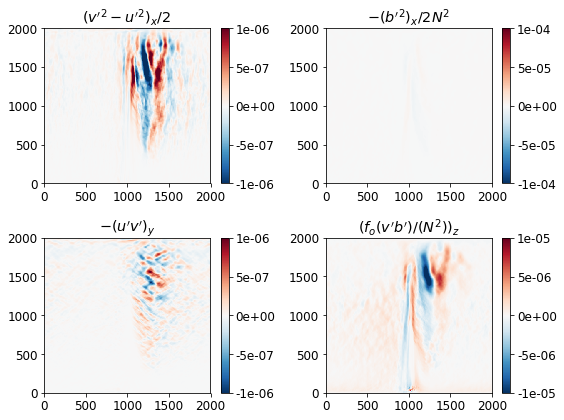

In [374]:
fig, ax = plt.subplots(2,2, figsize=(8,6))

im = ax[0,0].pcolormesh(X/1e3, Y/1e3, vpqp1.sel(Z=-200, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[0,0].set_title('$(v\'^2 - u\'^2)_x$/2 ')
fig.colorbar(im, ax=ax[0,0], format='%.0e')

im = ax[0,1].pcolormesh(X/1e3, Y/1e3, vpqp2.sel(Z=-200, method='nearest') ,
                        vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')
ax[0,1].set_title('$-(b\'^2)_x/2N^2$')
fig.colorbar(im, ax=ax[0,1], format='%.0e')

im = ax[1,0].pcolormesh(X/1e3, Y/1e3, vpqp3.sel(Z=-200, method='nearest') ,
                        vmin=-1e-6, vmax=1e-6, cmap='RdBu_r')
ax[1,0].set_title('$-(u\'v\')_y$')
fig.colorbar(im, ax=ax[1,0], format='%.0e')

im = ax[1,1].pcolormesh(X/1e3, Y/1e3, vpqp4.sel(Z=-200, method='nearest') ,
                        vmin=-1e-5, vmax=1e-5, cmap='RdBu_r')
ax[1,1].set_title('$(f_o (v\'b\')/(N^2))_z$')

fig.colorbar(im, ax=ax[1,1], format='%.0e')

plt.tight_layout()

## PV fluxes

EP fluxes in 3D 

* for now lets ignore the momentum flux parts 

In [397]:
TZ = grid.diff(Profile, 'Z', boundary='extend', to='left')/ grid.diff(Model_Tav.Z, 'Z', boundary='extend')
TZ2 = -grid.interp(grid.diff(Profile, 'Z', boundary='extend'), 'Z', boundary='extend')  / Model_Tav.drF                

In [410]:
Profile_edited = Profile.where(TZ2>1e-4)

In [411]:
TeditedZ = grid.diff(Profile_edited, 'Z', boundary='extend', to='left')/ grid.diff(Model_Tav.Z, 'Z', boundary='extend')
TeditedZ2 = -grid.interp(grid.diff(Profile_edited, 'Z', boundary='extend'), 'Z', boundary='extend')  / Model_Tav.drF                

In [399]:
TZZ = grid.diff(1/TZ, 'Z', boundary='extend', to='center')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')
TZZ2 =- grid.interp(grid.diff(1/TZ2, 'Z', boundary='extend'), 'Z', boundary='extend') / Model_Tav.drF

In [413]:
TeditedZZ = grid.diff(1/TeditedZ, 'Z', boundary='extend', to='center')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')
TeditedZZ2 =- grid.interp(grid.diff(1/TeditedZ2, 'Z', boundary='extend'), 'Z', boundary='extend') / Model_Tav.drF

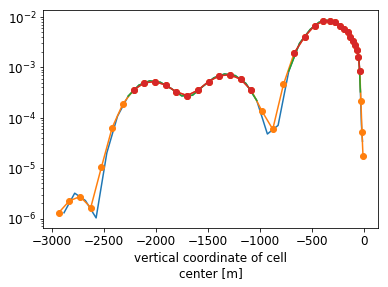

In [412]:
TZ.plot()
TZ2.plot.line('o-')
TeditedZ.plot()
TeditedZ2.plot.line('o-')
plt.yscale('log')

(-200, 150)

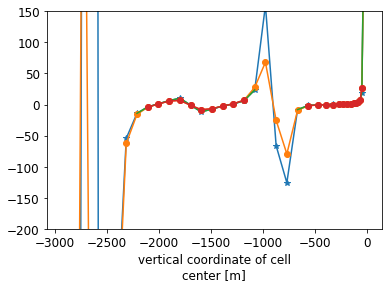

In [416]:
TZZ.plot.line('*-')
TZZ2.plot.line('o-')
TeditedZZ.plot()
TeditedZZ2.plot.line('o-')
plt.ylim([-200,150])

In [439]:
# v'q' using eddy flux of temp
vq = grid.diff(f0 * grid.interp(T_coarse.VpTp.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')), 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

In [436]:
# v'q' using 
vq2 = grid.diff(f0 * grid.interp(- recVB_corr.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')), 
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

In [428]:
Qx =  grid.diff(f0 * grid.interp(T_coarse.T_X.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/ 
                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')),
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

Qy = beta + grid.diff(f0 * grid.interp(T_coarse.T_Y.where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/ 
                  (grid.diff(T_coarse['T'].where(T_coarse['T_Z']>1.3e-4),'Z', boundary='extend')/
               grid.diff(T_coarse.Z, 'Z', boundary='extend')),
               'Z', boundary='extend')/ grid.diff(Model_Tav.Zl, 'Z', boundary='extend')

In [433]:
# v'q' using Q fluxes
recVQ_corr = -( Ktensor_corr.sel(i=1, j=0)*Qx + \
             Ktensor_corr.sel(i=1, j=1)*Qy )

In [459]:
plt.rc('text', usetex=True)

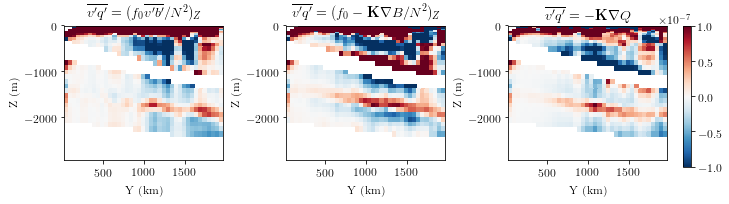

In [488]:
fig, ax = plt.subplots(1,3,figsize=(11,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, vq.sel(XCicoarse=0), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                rasterized=True)
ax[0].set_title('$\overline{v\'q\'} = (f_0 \overline{v\'b\'} /N^2)_Z$ ')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('Y (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, vq2.sel(XCicoarse=0).T, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                rasterized=True)
ax[1].set_title(r' $\overline{v^\prime q^\prime} = (f_0 -\mathbf{K} \nabla B /N^2)_Z$')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('Y (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, recVQ_corr.sel(XCicoarse=0).T, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                     rasterized=True)
ax[2].set_title(r' $\overline{v^\prime q^\prime} = -\mathbf{K} \nabla Q$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('Y (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('VQ_YZ_0km.pdf', dpi=400)

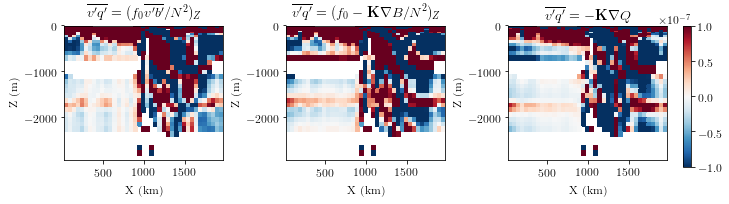

In [490]:
fig, ax = plt.subplots(1,3,figsize=(11,3))

ax[0].pcolormesh(Ycoarse/1e3, Z, vq.sel(YCicoarse=20), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                rasterized=True)
ax[0].set_title('$\overline{v\'q\'} = (f_0 \overline{v\'b\'} /N^2)_Z$ ')
ax[0].set_ylabel('Z (m)')
ax[0].set_xlabel('X (km)')

ax[1].pcolormesh(Ycoarse/1e3, Z, vq2.sel(YCicoarse=20).T, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                rasterized=True)
ax[1].set_title(r' $\overline{v^\prime q^\prime} = (f_0 -\mathbf{K} \nabla B /N^2)_Z$')
ax[1].set_ylabel('Z (m)')
ax[1].set_xlabel('X (km)')

im = ax[2].pcolormesh(Ycoarse/1e3, Z, recVQ_corr.sel(YCicoarse=20).T, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r',
                     rasterized=True)
ax[2].set_title(r' $\overline{v^\prime q^\prime} = -\mathbf{K} \nabla Q$')
ax[2].set_ylabel('Z (m)')
ax[2].set_xlabel('X (km)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.2, 0.01, 0.65])
fig.colorbar(im, cax=cbar_ax)

plt.savefig('VQ_XZ_1000km.pdf', dpi=400)

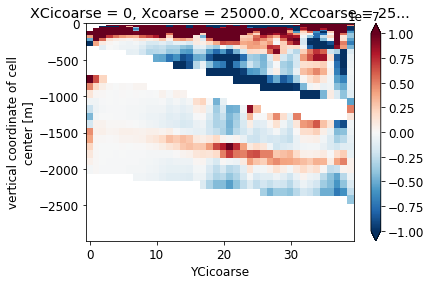

In [435]:
(recVQ_corr.sel(XCicoarse=0).T).plot(vmin=-1e-7)

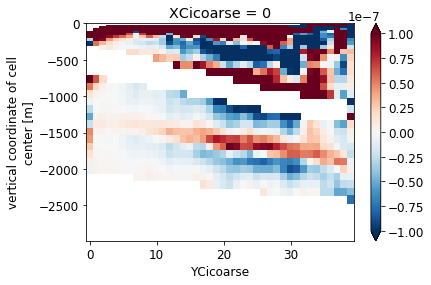

In [438]:
(vq2.sel(XCicoarse=0).T).plot(vmin=-1e-7)

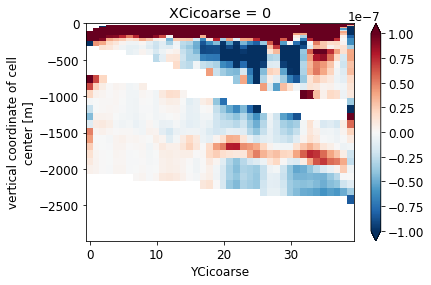

In [424]:
vq.sel(XCicoarse=0).plot(vmin=-1e-7)

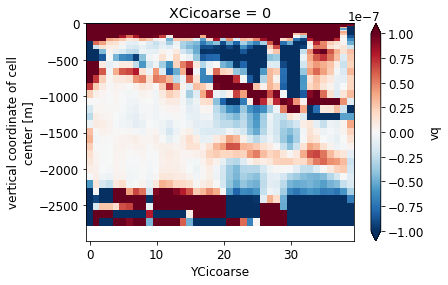

In [425]:
PV['vq'].sel(XCicoarse=0).plot(vmin=-1e-7)

In [344]:
PV = xr.Dataset()

PV['uq'] = -grid.interp( grid.diff(f0/ T_coarse['T_Z'] * T_coarse.UpTp , 'Z', boundary='extend'),
                             'Z', boundary='extend')/ T_coarse.drF

PV['vq'] = -grid.interp( grid.diff(f0/ T_coarse['T_Z'] * T_coarse.VpTp , 'Z', boundary='extend'), 
                             'Z', boundary='extend')/ T_coarse.drF

In [345]:
PV['recuq'] = -grid.interp( grid.diff(f0/ T_coarse['T_Z'] * (-recUB_corr) , 'Z', boundary='extend'),
                             'Z', boundary='extend')/ T_coarse.drF

PV['recvq'] = -grid.interp( grid.diff(f0/ T_coarse['T_Z'] * (-recVB_corr) , 'Z', boundary='extend'), 
                             'Z', boundary='extend')/ T_coarse.drF

In [346]:
# Y gradient of QGPV
PV['Q_X'] =   f0* grid.interp( grid.diff(T_coarse.Siso_X,'Z', boundary='extend'),
                               'Z', boundary='extend')/ T_coarse.drF
PV['Q_Y'] = beta  + f0*grid.interp( grid.diff(T_coarse.Siso_Y,'Z', boundary='extend'),
                               'Z', boundary='extend')/ T_coarse.drF

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xgcm/grid.py:1001: RuntimeWarning: invalid value encountered in subtract
  return data_right - data_left


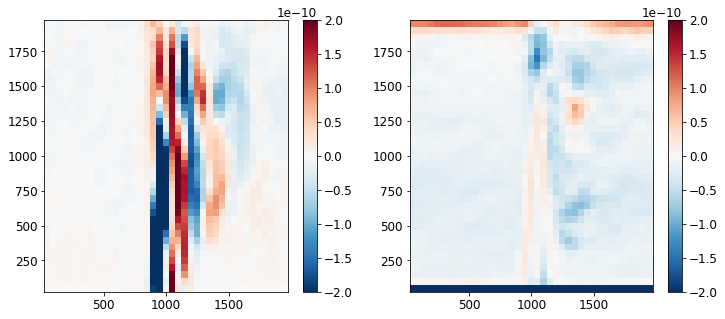

In [138]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

im = ax[0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, PV.Q_X.sel(Z=-1500, method='nearest'), 
               vmin=-2e-10, vmax=2e-10, cmap='RdBu_r')
fig.colorbar(im,  ax= ax[0])

im = ax[1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, PV.Q_Y.sel(Z=-1500, method='nearest'), 
               vmin=-2e-10, vmax=2e-10, cmap='RdBu_r')
fig.colorbar(im,  ax= ax[1])


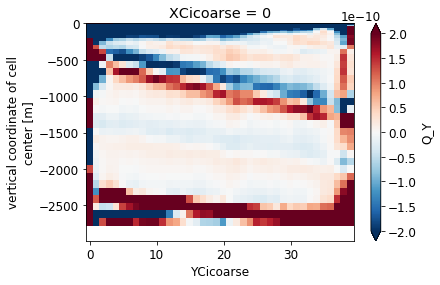

In [139]:
PV.Q_Y.sel(XCicoarse=0).plot(vmin=-2e-10)

In [347]:
# Recreate PV flux 

# we are not using the Z component (QG)

recUQ_corr = Ktensor_corr.sel(i=0, j=0)*PV.Q_X + \
             Ktensor_corr.sel(i=0, j=1)*PV.Q_Y 

recVQ_corr = Ktensor_corr.sel(i=1, j=0)*PV.Q_X + \
             Ktensor_corr.sel(i=1, j=1)*PV.Q_Y 

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


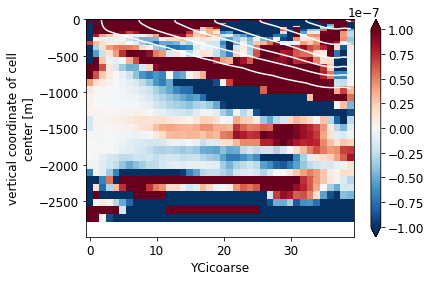

In [348]:
(-recVQ_corr).mean('XCicoarse').plot(x='YCicoarse', y='Z',vmin=-1e-7)
T_coarse['T'].mean('XCicoarse').plot.contour(levels=np.linspace(0,8,9), colors='w')

Text(0.5, 1.0, 'upqp _ using eddy T flux fine')

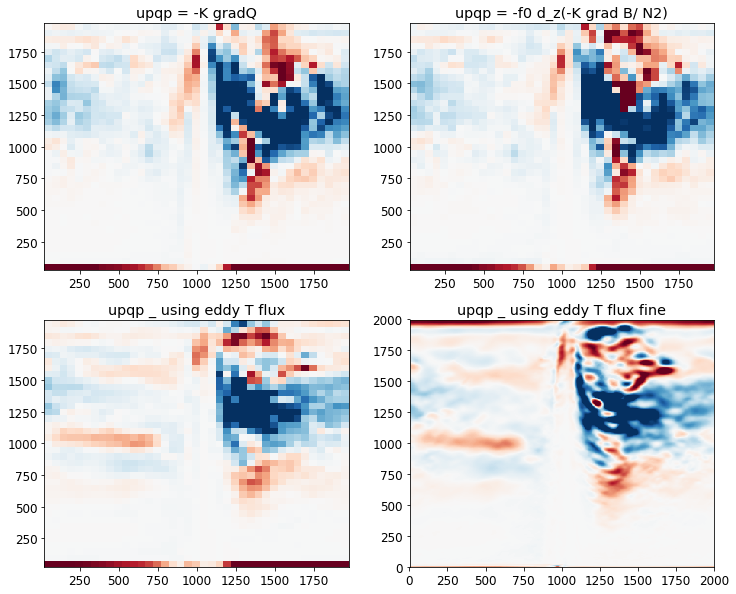

In [142]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (-recUQ_corr).sel(Z=-1000, method='nearest').T ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV.recuq).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV.uq).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[1,0].set_title('upqp _ using eddy T flux')

ax[1,1].pcolormesh(X/1e3, Y/1e3, (upqp).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[1,1].set_title('upqp _ using eddy T flux fine')

Text(0.5, 1.0, 'vpqp _ using eddy T flux fine')

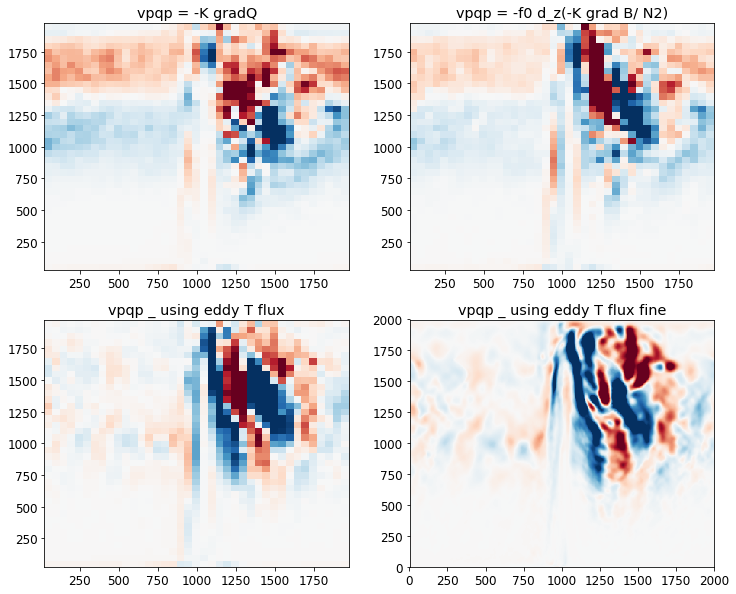

In [143]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (-recVQ_corr).sel(Z=-1000, method='nearest').T ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[0,0].set_title('vpqp = -K gradQ')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV.recvq).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[0,1].set_title('vpqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (PV.vq).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[1,0].set_title('vpqp _ using eddy T flux')

ax[1,1].pcolormesh(X/1e3, Y/1e3, (vpqp).sel(Z=-1000, method='nearest') ,
                 vmin=-1e-6,vmax=1e-6, cmap='RdBu_r')
ax[1,1].set_title('vpqp _ using eddy T flux fine')

NameError: name 'upqp' is not defined

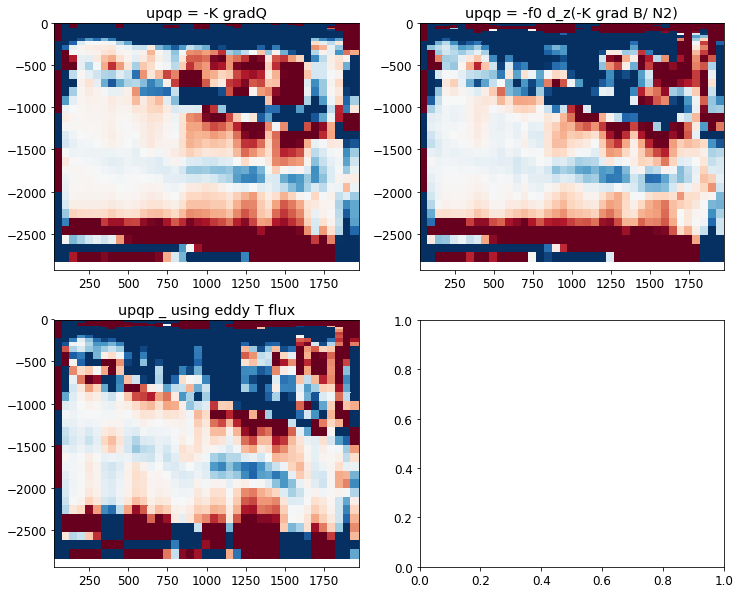

In [349]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(Ycoarse/1e3, Z, (-recUQ_corr).sel(XCicoarse=0, method='nearest').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, (PV.recuq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV.uq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[1,0].set_title('upqp _ using eddy T flux')

ax[1,1].pcolormesh(Y/1e3, Z, (upqp).sel(XC=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[1,1].set_title('upqp _ using eddy T flux fine')

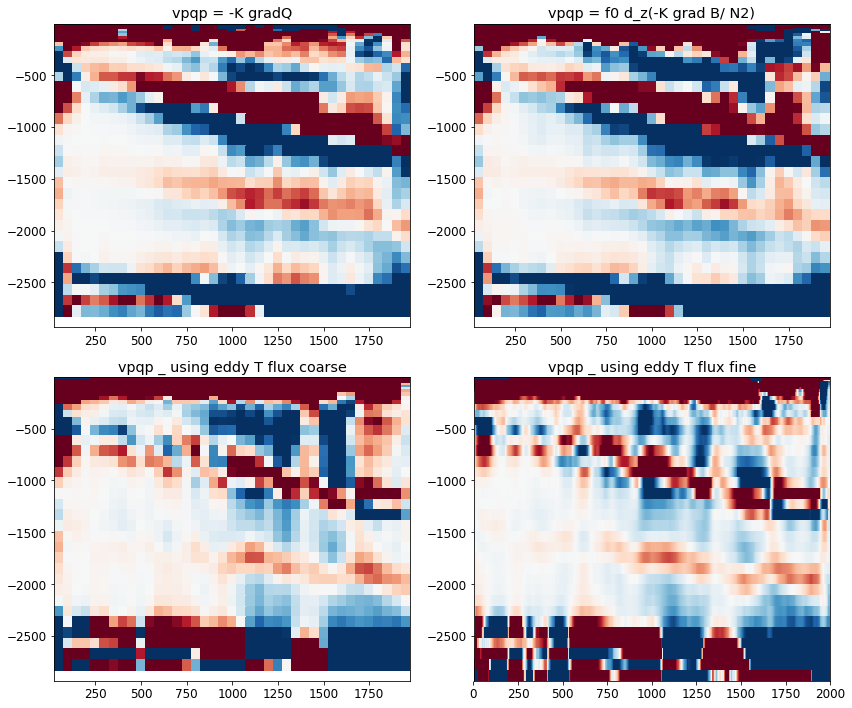

In [146]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].pcolormesh(Ycoarse/1e3, Z, (-recVQ_corr).sel(XCicoarse=0, method='nearest').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('vpqp = -K gradQ')

ax[0,1].pcolormesh(Ycoarse/1e3, Z, (PV.recvq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('vpqp = f0 d_z(-K grad B/ N2)')

ax[1,0].pcolormesh(Ycoarse/1e3, Z, (PV.vq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[1,0].set_title('vpqp _ using eddy T flux coarse')

ax[1,1].pcolormesh(Y/1e3, Z, (vpqp).sel(XC=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r')
ax[1,1].set_title('vpqp _ using eddy T flux fine')

plt.tight_layout()

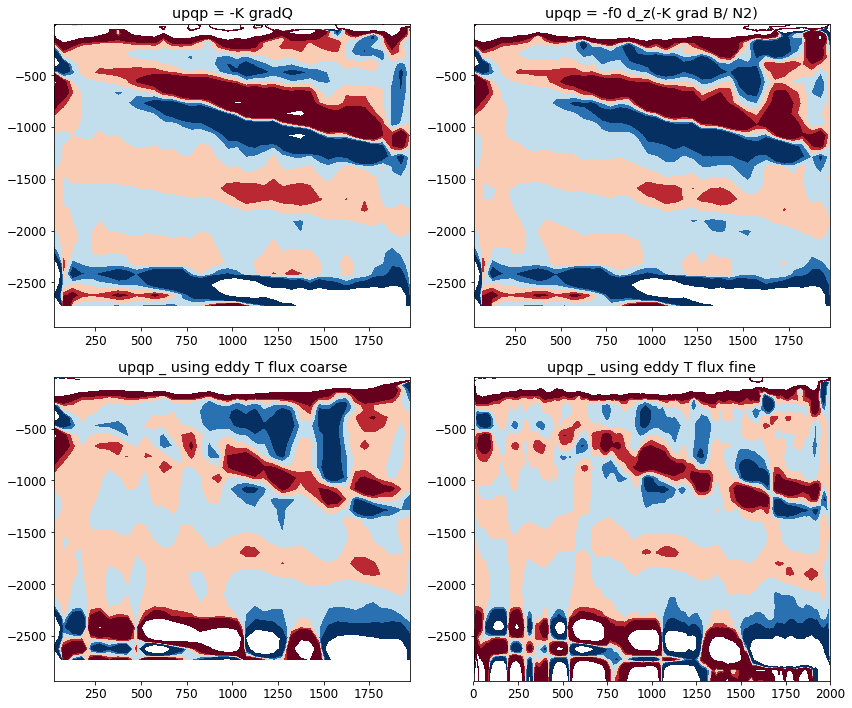

In [147]:
fig , ax = plt.subplots(2,2, figsize=(12,10))
levels = np.linspace(-5e-7, 5e-7,21)

ax[0,0].contourf(Ycoarse/1e3, Z, (-recVQ_corr).sel(XCicoarse=0, method='nearest').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].contourf(Ycoarse/1e3, Z, (PV.recvq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].contourf(Ycoarse/1e3, Z, (PV.vq).sel(XCicoarse=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,0].set_title('upqp _ using eddy T flux coarse')

ax[1,1].contourf(Y/1e3, Z, (vpqp).sel(XC=0, method='nearest') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,1].set_title('upqp _ using eddy T flux fine')

plt.tight_layout()

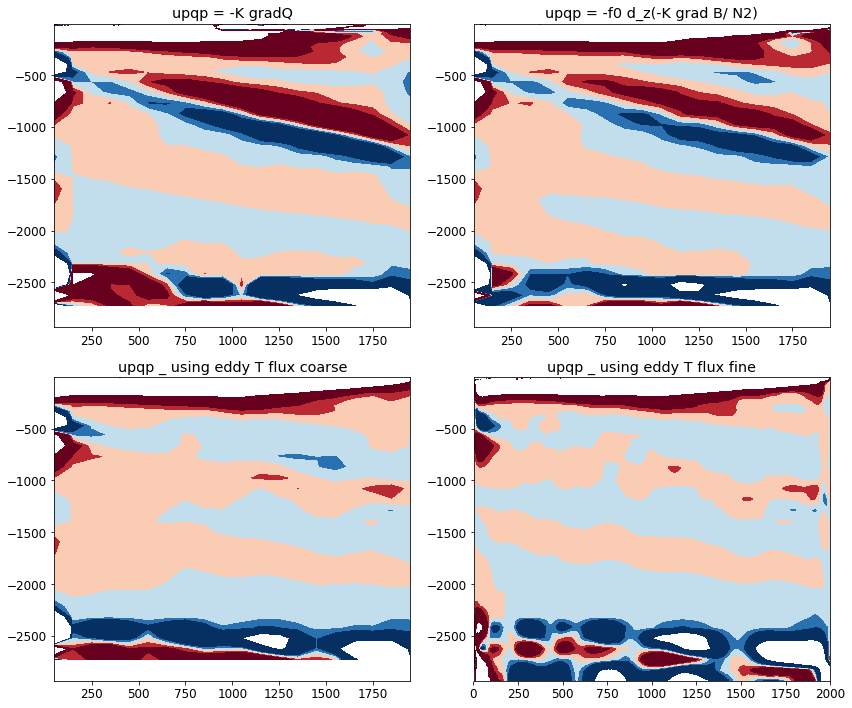

In [421]:
fig , ax = plt.subplots(2,2, figsize=(12,10))
levels = np.linspace(-5e-7, 5e-7,21)

ax[0,0].contourf(Ycoarse/1e3, Z, (-recVQ_corr).sel(XCicoarse=slice(0,8)).mean('XCicoarse').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].contourf(Ycoarse/1e3, Z, (PV.recvq).sel(XCicoarse=slice(0,8)).mean('XCicoarse') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].contourf(Ycoarse/1e3, Z, (PV.vq).sel(XCicoarse=slice(0,8)).mean('XCicoarse') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,0].set_title('upqp _ using eddy T flux coarse')

ax[1,1].contourf(Y/1e3, Z, (vpqp).sel(XC=slice(0,800e3)).mean('XC') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,1].set_title('upqp _ using eddy T flux fine')

plt.tight_layout()

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


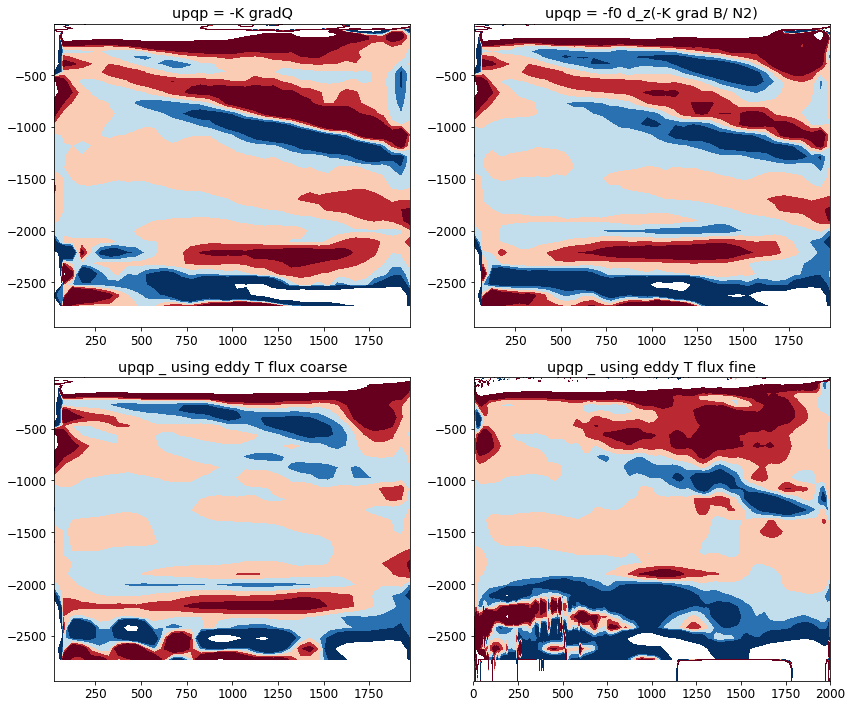

In [148]:
fig , ax = plt.subplots(2,2, figsize=(12,10))

levelsT = np.array([0,0.2,0.4,0.6,0.8, 1, 3, 5,7])
levels = np.linspace(-5e-7, 5e-7,21)

ax[0,0].contourf(Ycoarse/1e3, Z, (-recVQ_corr).sel(XCicoarse=slice(0,20)).mean('XCicoarse').T ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,0].set_title('upqp = -K gradQ')

ax[0,1].contourf(Ycoarse/1e3, Z, (PV.recvq).sel(XCicoarse=slice(0,20)).mean('XCicoarse') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[0,1].set_title('upqp = -f0 d_z(-K grad B/ N2)')

ax[1,0].contourf(Ycoarse/1e3, Z, (PV.vq).sel(XCicoarse=slice(0,20)).mean('XCicoarse') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,0].set_title('upqp _ using eddy T flux coarse')

ax[1,1].contourf(Y/1e3, Z, (vpqp).sel(XC=slice(0,2000e3)).mean('XC') ,
                 vmin=-1e-7,vmax=1e-7, cmap='RdBu_r', levels=levels)
ax[1,1].set_title('upqp _ using eddy T flux fine')

plt.tight_layout()

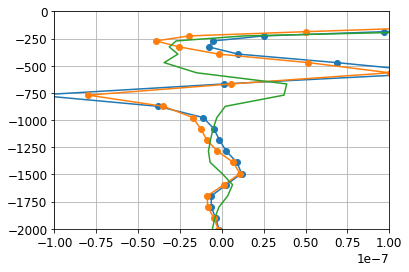

In [149]:
plt.plot(-recVQ_corr.sel(XCicoarse=2, YCicoarse=10), PV.Z, 'o-')
plt.plot(PV.recvq.sel(XCicoarse=2, YCicoarse=10), PV.Z, 'o-')
plt.plot(PV.vq.sel(XCicoarse=2, YCicoarse=10), PV.Z)
plt.xlim([-1e-7, 1e-7])
plt.ylim([-2000, 0])
plt.grid()

PV fluxes are not apparently downgradient. Specially downstream region. 

## Buoyancy fluxes

How well can we use buoyancy fluxes to determine the Kgm? Specially in 3D. Issues of Rotational fluxes an issue? Some of this learning can be applied to the observations (where Argo are providing estimates of v'b'). 

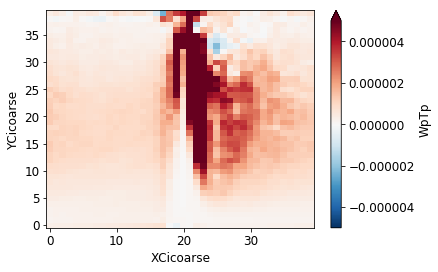

In [150]:
T_coarse.WpTp.mean('Z').plot(vmin=-5e-6)

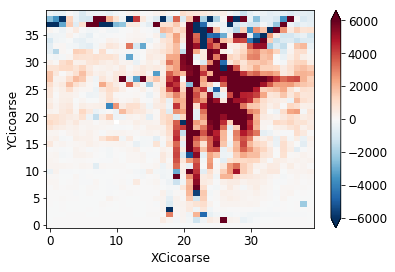

In [158]:
(Kgm.sel(Z=slice(0,-2000)).mean('Z').T).plot(vmin=-6000)

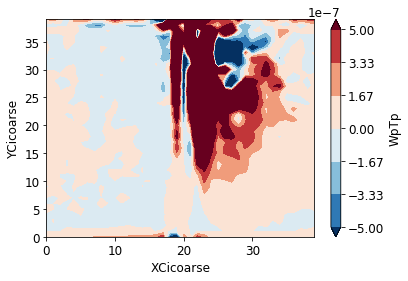

In [151]:
T_coarse.WpTp.sel(Z=slice(-600, -2000)).mean('Z').plot.contourf(vmin=-5e-7)

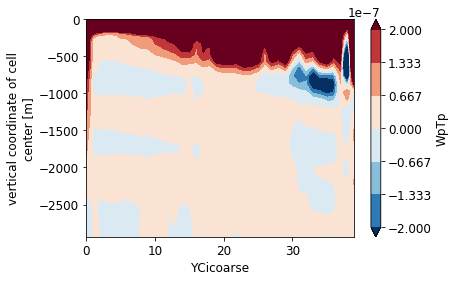

In [152]:

T_coarse.WpTp.isel(XCicoarse=slice(0,8)).mean('XCicoarse').plot.contourf(vmin=-2e-7)


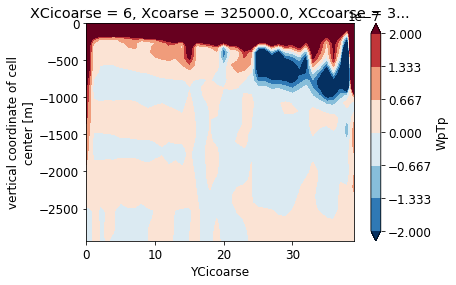

In [153]:
T_coarse.WpTp.isel(XCicoarse=6).plot.contourf(vmin=-2e-7)


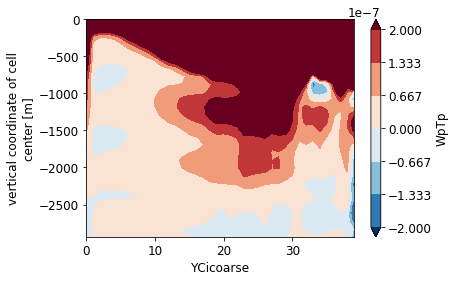

In [155]:
T_coarse.WpTp.isel(XCicoarse=slice(0,40)).mean('XCicoarse').plot.contourf(vmin=-2e-7)